In [314]:
from collections import Counter
from collections import defaultdict
import glob
import itertools
from itertools import izip
import os

from IPython.core.display import HTML, Image
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import numpy as np
import pandas as pd
import scipy
import seaborn as sns.csv
from scipy.stats import hypergeom
from scipy.stats import ks_2samp

import flotilla
from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts.rnaseq import helpers
from gscripts import GO
from gscripts import miso

img_dir = "/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/"

In [315]:
102 + 365 + 2 + 51

520

In [316]:
46 + 60

106

In [317]:
datasets = ["fus", 'taf15', 'tdp43', 'fus_taf15', 'taf15_tdp43', 'R521G', 'T198C',]
rbp_colors = dict(zip(datasets, sns.color_palette("bright", len(datasets))))


rbp_colors = {"fus": '#43A247',
             "FUS": '#43A247',
             'taf15': '#DB1D3D',
             'TAF15': '#DB1D3D',
             'tdp43': '#712878',
             'TDP43': '#712878',
             'fus_taf15': 'y',
             'taf15_tdp43': 'k',
             'R521G': 'c', 
             'T198C': 'c',
             'EWS' : 'g',
              'sALS': 'c',
             'ctrl': (0.90311419262605563, 0.54185316071790801, 0.76495195557089413)}


rbp_names = {"fus": 'FUS',
              'taf15': 'TAF15',
              'tdp43': 'TDP43',
              'fus_taf15': 'FUS TAF15',
              'taf15_tdp43': 'TAF15 TDP43',
             'sALS': "sALS",}

In [318]:
def counts_to_rpkm(featureCountsTable):
    counts = featureCountsTable.ix[:,5:]
    lengths = featureCountsTable['Length']
    mapped_reads = counts.sum()
    return (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)

def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]

In [319]:
gene_id_to_name = region_helpers.gene_id_to_name("/nas3/gpratt/gencode/gencode.v17.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/nas3/gpratt/gencode/gencode.v17.annotation.gtf.db")

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

hg19_gene_id_to_name = region_helpers.gene_id_to_name("/nas3/gpratt/gencode/gencode.v17.annotation.gtf.db")
mm9_gene_id_to_name = region_helpers.gene_id_to_name("/nas3/gpratt/gencode/gencode.vM1.annotation.gtf.db")

pd.Series(mm9_gene_id_to_name).to_csv("/nas3/gpratt/Dropbox/ENCORE-YEOLAB/data/localization/mm9_gene_id.csv")
pd.Series(hg19_gene_id_to_name).to_csv("/nas3/gpratt/Dropbox/ENCORE-YEOLAB/data/localization/hg19_gene_id.csv")

#Make MN Study in flotilla

In [320]:
human_mn_splicing = pd.read_csv("/nas3/gpratt/projects/fet_family/analysis/human_mn_v1/miso_summary_filtered.csv", 
                                index_col=[18, 2])
human_mn_splicing = human_mn_splicing[[splice not in ["ALE", "AFE"] for splice in human_mn_splicing.splice_type]]

splicing_matrix = human_mn_splicing.miso_posterior_mean.unstack()

#Load all Counts / Generate RPKM's

In [321]:
mn_rpkm[name_to_gene_id['USP13']]

cell_type  exp                  knockdown    rep
MN         FUS_TAF15_shRNA_1    FUS_TAF15    1      4.273959
           FUS_TAF15_shRNA_2    FUS_TAF15    2      4.361004
           FUS_shRNA_1          FUS          1      3.865804
           FUS_shRNA_2          FUS          2      4.091183
           Scrm_1               Scrm         1      3.898256
           Scrm_2               Scrm         2      3.120691
           TAF15_TDP43_shRNA_1  TAF15_TDP43  1      4.116227
           TAF15_TDP43_shRNA_2  TAF15_TDP43  2      4.101585
           TAF15_shRNA_1        TAF15        1      3.098114
           TAF15_shRNA_2        TAF15        2      3.433416
           TDP43_shRNA_1        TDP43        1      3.165339
           TDP43_shRNA_2        TDP43        2      2.729395
Name: ENSG00000058056.4, dtype: float64

In [322]:
npc_rpkm[name_to_gene_id['USP13']]

cell_type  exp                knockdown    rep
NPC        NPC_FUS_1_p7_35    FUS          1      2.967257
           NPC_FUS_2_p7_44    FUS          2      6.098777
           NPC_Scrm_1_p7_35   Scrm         1      4.883154
           NPC_Scrm_2_p7_44   Scrm         2      4.553777
           NPC_T+F_1_p7_44    FUS_TAF15    1      5.113141
           NPC_T+F_2_p7_44    FUS_TAF15    2      5.886746
           NPC_T+T_1_p7_44    TAF15_TDP43  1      2.989103
           NPC_T+T_2_p7_44    TAF15_TDP43  2      5.772548
           NPC_TAF15_1_p7_35  TAF15        1      5.645781
           NPC_TAF15_2_p7_44  TAF15        2      4.056212
           NPC_TDP43_1_p_44   TDP43        1      3.857144
Name: ENSG00000058056.4, dtype: float64

In [323]:
#MN
mn_counts = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/all_counts.txt", skiprows=1, index_col=0)
mn_counts.columns = [os.path.basename(item).split(".")[0] for item in mn_counts.columns]
mn_rpkm = helpers.counts_to_rpkm(mn_counts).T
mn_flotilla_rpkm = mn_rpkm.copy()

mn_metadata = pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/sampleInfo.csv", index_col=0)
result = []
for name, item in mn_metadata.iterrows():
    result.append(item.values)
mn_rpkm.index = pd.MultiIndex.from_tuples(result, names=item.index)

#NPC
npc_counts = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/human_npc/all_counts.txt", skiprows=1, index_col=0)
npc_counts.columns = [os.path.basename(item).split(".")[0] for item in npc_counts.columns]

npc_rpkm = helpers.counts_to_rpkm(npc_counts).T
npc_flotilla_rpkm = npc_rpkm.copy()

npc_metadata = pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/human_npc/sampleInfo.csv", index_col=0)
result = []
for name, item in npc_metadata.iterrows():
    result.append(item.values)
npc_rpkm.index = pd.MultiIndex.from_tuples(result, names=item.index)

rpkm = pd.concat([mn_rpkm, npc_rpkm])

In [324]:
for col in mn_counts[mn_counts.columns[5:]]:
    pd.DataFrame(mn_counts[col]).to_csv("/nas3/gpratt/Dropbox/TAF15/geo/human/mn/{}.csv".format(col))

In [325]:
#Rename stuff to work with flotilla
mn_metadata = mn_metadata.rename(columns={"knockdown": "phenotype"})
npc_metadata = npc_metadata.rename(columns={"knockdown": "phenotype"})

mn_flotilla_rpkm.columns = [gene_id.split(".")[0] for gene_id in mn_flotilla_rpkm.columns]
mn_flotilla_rpkm.index = [gene_id.split(".")[0] for gene_id in mn_flotilla_rpkm.index]

npc_flotilla_rpkm.columns = [col.split(".")[0] for col in npc_flotilla_rpkm.columns]
npc_flotilla_rpkm.index = [col.split(".")[0] for col in npc_flotilla_rpkm.index]

In [326]:
mn_study = flotilla.Study(# The metadata describing phenotype and pooled samples
                       mn_metadata,
                       # A version for this data
                       version='0.1.0',
                       expression_data = mn_flotilla_rpkm,
                       # Dataframe of the splicing data
                       splicing_data=splicing_matrix,
                       expression_thresh = 1,
                       species="hg19"
)

mn_subset_study = flotilla.Study(# The metadata describing phenotype and pooled samples
                       mn_metadata[mn_metadata.phenotype.isin(["FUS", "TAF15", "TDP43"])],
                       version='0.1.0',
                       expression_data = mn_flotilla_rpkm[mn_metadata.phenotype.isin(["FUS", "TAF15", "TDP43"])],
                       expression_thresh = 1,
                       species="hg19"
)

npc_study = flotilla.Study(# The metadata describing phenotype and pooled samples
                       npc_metadata,
                       version='0.1.0',
                       expression_data = npc_flotilla_rpkm,
                       expression_thresh = 1,
                       species="hg19"
)

npc_subset_study = flotilla.Study(# The metadata describing phenotype and pooled samples
                       npc_metadata[npc_metadata.phenotype.isin(["FUS", "TAF15", "TDP43"])],
                       version='0.1.0',
                       expression_data = npc_flotilla_rpkm[npc_metadata.phenotype.isin(["FUS", "TAF15", "TDP43"])],
                       expression_thresh = 1,
                       species="hg19"
)

2016-01-25 10:54:31	Initializing Study
2016-01-25 10:54:31	Initializing Predictor configuration manager for Study
2016-01-25 10:54:31	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>


No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.


2016-01-25 10:54:31	Added ExtraTreesClassifier to default predictors
2016-01-25 10:54:31	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-01-25 10:54:31	Added ExtraTreesRegressor to default predictors
2016-01-25 10:54:31	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-01-25 10:54:31	Added GradientBoostingClassifier to default predictors
2016-01-25 10:54:31	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2016-01-25 10:54:31	Added GradientBoostingRegressor to default predictors
2016-01-25 10:54:31	Loading metadata
2016-01-25 10:54:31	Loading species metadata from ~/flotilla_packages
https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2016-01-25 10:54:48	Loading expression data
2016-01-25 10:54:48	Initializing expression
2016-01-25 10:54:4

Error loading species hg19 data No phenotype to color mapping was provided, falling back on reasonable defaults.


2016-01-25 10:54:57	Initializing Study
2016-01-25 10:54:57	Initializing Predictor configuration manager for Study
2016-01-25 10:54:57	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-01-25 10:54:57	Added ExtraTreesClassifier to default predictors
2016-01-25 10:54:57	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-01-25 10:54:57	Added ExtraTreesRegressor to default predictors
2016-01-25 10:54:57	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-01-25 10:54:57	Added GradientBoostingClassifier to default predictors
2016-01-25 10:54:57	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2016-01-25 10:54:57	Added GradientBoostingRegressor to default predictors
2016-01-25 10:54:57	Loading metadata
2016-01-25 10:54:57	Loading species metadata from ~/f

No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.
Error loading species hg19 data 

2016-01-25 10:55:07	Loading expression data
2016-01-25 10:55:07	Initializing expression
2016-01-25 10:55:07	Done initializing expression
2016-01-25 10:55:10	Successfully initialized a Study object!
2016-01-25 10:55:10	Initializing Study
2016-01-25 10:55:10	Initializing Predictor configuration manager for Study
2016-01-25 10:55:10	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-01-25 10:55:10	Added ExtraTreesClassifier to default predictors
2016-01-25 10:55:10	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-01-25 10:55:10	Added ExtraTreesRegressor to default predictors
2016-01-25 10:55:10	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-01-25 10:55:10	Added GradientBoostingClassifier to default predictors
2016-01-25 10:55:10	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boo

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.
Error loading species hg19 data 

2016-01-25 10:55:19	Loading expression data
2016-01-25 10:55:19	Initializing expression
2016-01-25 10:55:19	Done initializing expression
2016-01-25 10:55:27	Successfully initialized a Study object!
2016-01-25 10:55:28	Initializing Study
2016-01-25 10:55:28	Initializing Predictor configuration manager for Study
2016-01-25 10:55:28	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-01-25 10:55:28	Added ExtraTreesClassifier to default predictors
2016-01-25 10:55:28	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-01-25 10:55:28	Added ExtraTreesRegressor to default predictors
2016-01-25 10:55:28	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-01-25 10:55:28	Added GradientBoostingClassifier to default predictors
2016-01-25 10:55:28	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boo

No phenotype to color mapping was provided, falling back on reasonable defaults.
No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.
Error loading species hg19 data 

2016-01-25 10:55:37	Loading expression data
2016-01-25 10:55:37	Initializing expression
2016-01-25 10:55:37	Done initializing expression
2016-01-25 10:55:40	Successfully initialized a Study object!


#Basic QC 
Correlations 
------------

In [327]:
def format_names(names):
    cell_type, exp, knockdown, rep = names
    return "{} {} KD rep {}".format(cell_type, knockdown, rep)

In [328]:
# num_rows = 4
# num_cols = 3
# with dataviz.Figure(os.path.join(img_dir, "replicate_plotting.svg"), figsize=(1.5 * num_cols, 1.5 * num_rows)) as fig:
#     max_combinations = np.max(rpkm.groupby(level=(["cell_type", "knockdown"])).count().values)
#     gs = gridspec.GridSpec(num_rows, num_cols)
#     count = 0
#     for x, (name, group) in enumerate(rpkm.groupby(level=(["cell_type", "knockdown"]))):
#         for y, (name1, name2) in enumerate(itertools.combinations(group.index, 2)):

#             x = count / 3
#             y = count % 3

#             ax = fig.add_subplot(gs[x,y]) 
#             series1 = rpkm.ix[name1]
#             series2 = rpkm.ix[name2]

#             dataviz.loglog_hist2d(series1, series2, ax=ax)
#             sns.despine(ax=ax)
            

#             formatted_name1 = format_names(name1)
#             formatted_name2 = format_names(name2)
            
#             ax.set_xlabel(formatted_name1, fontsize=6)
#             ax.set_ylabel(formatted_name1, fontsize=6)            
#             r2 = scipy.stats.linregress(series1, series2)[2]
#             ax.text(2, 3, "$R^2$={:.2f}".format(r2), fontsize=6)
#             #ax.set_title("{}\nvs\n{}".format(formatted_name1, formatted_name2), fontsize=10)
#             [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
#             [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
#             count += 1

Figure Legend: Correlation between technical Replicates for MN and NPC and their knockdowns of FUS, TAF15, TDP43 and the double TAF15/TDP43 and TAF15/FUS knockdowns

#Check Knockdowns

In [329]:
mn_study.expression.data[[mn_study.expression.maybe_renamed_to_feature_id("FUS")[0],
                      mn_study.expression.maybe_renamed_to_feature_id("TAF15")[0],
                      mn_study.expression.maybe_renamed_to_feature_id("TARDBP")[0]]]

ENSG00000089280  ENSG00000172660  ENSG00000120948
FUS_shRNA_1                 2.793034         7.178087        28.663085
FUS_shRNA_2                 2.640107         6.659736        28.532364
FUS_TAF15_shRNA_1           3.407149         4.355524        26.316867
FUS_TAF15_shRNA_2           2.751437         4.265410        29.316705
Scrm_1                      6.424281         6.560036        26.879956
Scrm_2                      7.242226         6.936004        26.182758
TAF15_shRNA_1               6.691984         2.556731        27.370291
TAF15_shRNA_2               6.491468         2.370395        27.875746
TAF15_TDP43_shRNA_1         6.182758         5.714977        12.567875
TAF15_TDP43_shRNA_2         7.148412         5.893919        13.453078
TDP43_shRNA_1               6.197280         7.224160        11.192080
TDP43_shRNA_2               7.036821         7.995239        11.536159

In [330]:
npc_study.expression.data[[npc_study.expression.maybe_renamed_to_feature_id("FUS")[0],
                      npc_study.expression.maybe_renamed_to_feature_id("TAF15")[0],
                      npc_study.expression.maybe_renamed_to_feature_id("TARDBP")[0]]]

ENSG00000089280  ENSG00000172660  ENSG00000120948
NPC_FUS_1_p7_35          19.085010        39.579364        40.324690
NPC_FUS_2_p7_44          17.882191        66.548483        67.592412
NPC_Scrm_1_p7_35         84.468844        54.080171        61.716993
NPC_Scrm_2_p7_44         74.519081        40.183723        69.131202
NPC_TAF15_1_p7_35        98.721287        12.973605        60.302487
NPC_TAF15_2_p7_44       103.935100        12.386852        64.809201
NPC_TDP43_1_p_44         55.742206        36.700331        31.723241
NPC_T+F_1_p7_44          26.403299        12.486408        62.746433
NPC_T+F_2_p7_44          29.753210        14.237639        59.996021
NPC_T+T_1_p7_44          63.695818        10.721307        36.391138
NPC_T+T_2_p7_44          70.293516        11.775678        37.407457

#PCA

MN All Data
----

/nas3/gpratt/anaconda/lib/python2.7/site-packages/flotilla-0.2.5.dev0-py2.7.egg/flotilla/data_model/metadata.py:186: UserWarning: MetaData.phenotype_series will be deprecated in 0.3.0
/nas3/gpratt/anaconda/lib/python2.7/site-packages/flotilla-0.2.5.dev0-py2.7.egg/flotilla/visualize/decomposition.py:176: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
/nas3/gpratt/anaconda/lib/python2.7/site-packages/flotilla-0.2.5.dev0-py2.7.egg/flotilla/visualize/decomposition.py:183: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


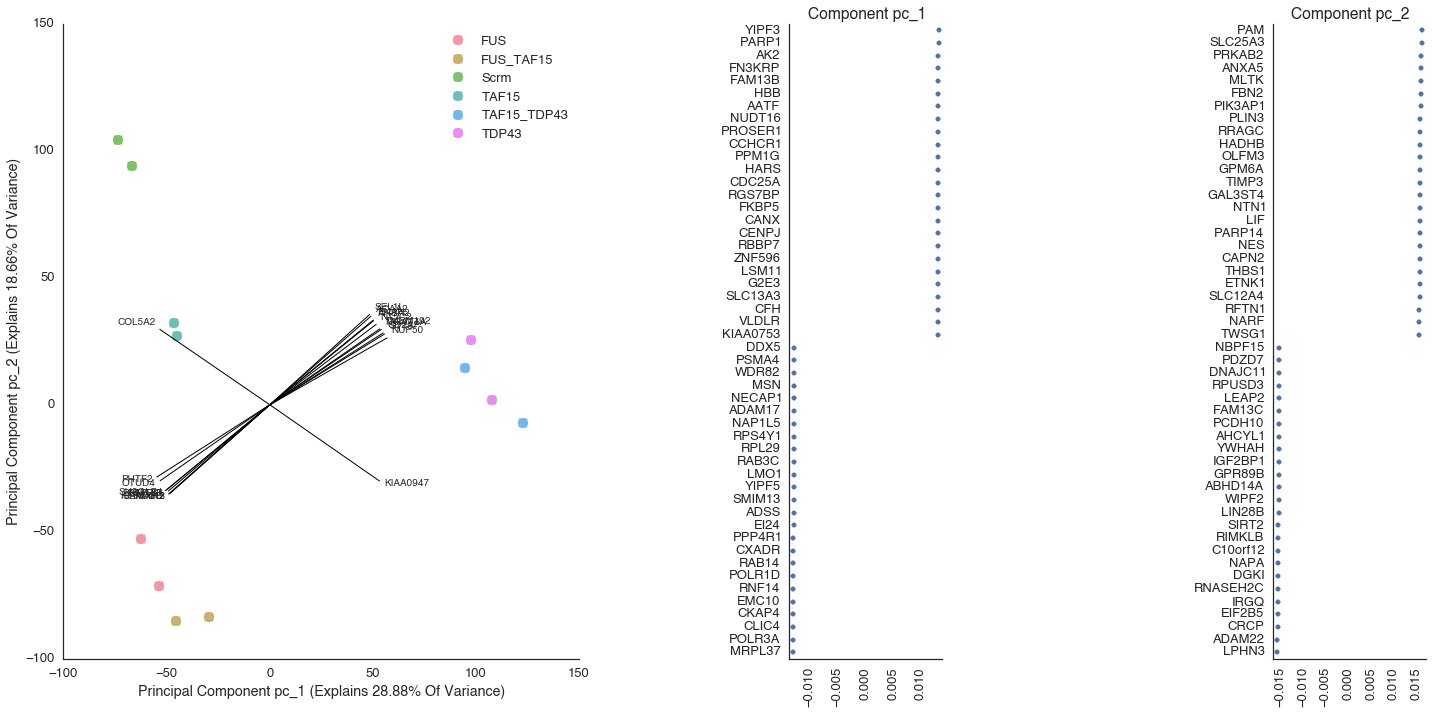

In [615]:
dv = mn_study.plot_pca(feature_subset = "gene_type: protein_coding")
dv.reduced_fig.savefig(os.path.join(img_dir, "mn_qc_pca.pdf"))
dv.reduced_fig.savefig(os.path.join(img_dir, "mn_qc_pca.svg"))

Figure Legend: PCA of just protein coding genes for MNs for all knockdowns and double knockdowns

MN Only FUS TAF15 and TDP43 KD
-----

In [332]:
# dv = mn_subset_study.plot_pca(feature_subset = "gene_type: protein_coding")
# dv.reduced_fig.savefig(os.path.join(img_dir, "mn_subset_qc_pca.pdf"))
# dv.reduced_fig.savefig(os.path.join(img_dir, "mn_subset_qc_pca.svg"))

Figure Legend: PCA of just protein coding genes in MNs for only single knockdowns of TAF15, FUS and TDP43

#NPC All Data

In [333]:
# dv = npc_study.plot_pca(feature_subset = "gene_type: protein_coding")
# dv.reduced_fig.savefig(os.path.join(img_dir, "npc_qc_pca.svg"))
# dv.reduced_fig.savefig(os.path.join(img_dir, "npc_qc_pca.pdf"))

Figure Legend: PCA of just protein coding genes for NPC for all knockdowns and double knockdowns

NPC Only FUS TAF15 and TDP43 KD
------

In [334]:
# dv = npc_subset_study.plot_pca(feature_subset = "gene_type: protein_coding")
# dv.reduced_fig.savefig(os.path.join(img_dir, "npc_subset_qc_pca.svg"))
# dv.reduced_fig.savefig(os.path.join(img_dir, "npc_subset_qc_pca.pdf"))

Figure Legend: PCA of just protein coding genes in MNs for only single knockdowns of TAF15, FUS and TDP43

#Get List of Expressed Genes

In [335]:
scramble_controls = rpkm.xs("Scrm", level="knockdown")

mn_scrable_controls = scramble_controls.ix['MN']
npc_scramble_controls = scramble_controls.ix['NPC']

expressed_genes = {"mn" : list(gencode_to_ensembl(mn_scrable_controls[mn_scrable_controls > 1].dropna(axis=1).columns)),
                 "npc": list(gencode_to_ensembl(npc_scramble_controls[npc_scramble_controls > 1].dropna(axis=1).columns)) }

In [336]:
# with dataviz.Figure(os.path.join(img_dir, "overlapping_expressed_genes.svg"), figsize=(10, 10)) as fig:
#     ax = fig.add_subplot(2,2,1)
#     venn2([set(expressed_genes['mn']), set(expressed_genes['npc'])], 
#           set_labels=["MN", "NPC"], ax=ax)

#     ax.set_title("Overlapping Expressed Genes")

Figure Legend: Overlap of Expressed Genes in MN and NPC

#Knockdown Analysis

In [337]:
!ls -lah /nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/tdp43_only.csv

-rw-r--r-- 1 gpratt yeolab 5.6M Aug 15 17:25 /nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/tdp43_only.csv


In [338]:
result = {
    "fus": pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/fus_only.csv", index_col=0),
    "taf15": pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/taf15_only.csv", index_col=0),
    "tdp43": pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/tdp43_only.csv", index_col=0),
    "taf15_tdp43": pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/taf15_tdp43_only.csv", index_col=0),
    "fus_taf15": pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/fus_taf15_only.csv", index_col=0),
}

mn = pd.concat(result, names=['rbp', 'gene'])

result = {
    "fus": pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/human_npc/deseq/fus_only.csv", index_col=0),
    "taf15": pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/human_npc/deseq/taf15_only.csv", index_col=0),
    "tdp43": pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/human_npc/deseq/tdp43_only.csv", index_col=0),
    "taf15_tdp43": pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/human_npc/deseq/taf15_tdp43_only.csv", index_col=0),
    "fus_taf15": pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/human_npc/deseq/fus_taf15_only.csv", index_col=0),
}

npc = pd.concat(result, names=['rbp', 'gene'])

knockdowns = pd.concat({"npc": npc, "mn": mn}, names=['cell_type', 'rbp', 'gene'])
knockdowns["gene_name"] = [gene_id_to_name[item] for item in knockdowns.index.get_level_values("gene")]

iPCS MN Differentation Knockdowns
-----

In [339]:
cashe = {'G298S': 'tdp', 'N352S': 'tdp', 'R521G': 'fus', 'T198C': 'fus'}

ips_knockdowns = pd.concat({os.path.basename(rbp).split(".")[0]: pd.read_csv(rbp, index_col=0) for rbp in glob.glob("/nas3/gpratt/Dropbox/TAF15/Data/anthony_rnaseq/deseq/*")})
ips_knockdowns['gene_names'] = [gene_id_to_name[gene_id] for gene_id in ips_knockdowns.index.get_level_values(level=1)]

results = []
for item in ips_knockdowns.index:
    gene_id = item[1]
    mutation = item[0].upper()
    rbp = cashe[mutation]
    
    results.append([mutation, rbp, gene_id])
    
ips_knockdowns.index = pd.MultiIndex.from_tuples(results, names=["rbp", 'mutation', "gene"])
ips_knockdowns = ips_knockdowns.sortlevel()

In [340]:
ips_significant_knockdowns = ips_knockdowns[(ips_knockdowns.padj <= .05) & (abs(ips_knockdowns.log2FoldChange) > np.log2(1.5))]
ips_signifcant_upregulated = ips_significant_knockdowns[ips_significant_knockdowns.log2FoldChange > 0]
ips_signifcant_downregulated = ips_significant_knockdowns[ips_significant_knockdowns.log2FoldChange < 0]

In [341]:
ips_signifcant_upregulated

baseMean  log2FoldChange     lfcSE  \
rbp   mutation gene                                                        
G298S tdp      ENSG00000006283.13   340.319925        1.439354  0.287022   
               ENSG00000007174.12    14.057491        1.296688  0.355596   
               ENSG00000007944.10   256.774850        1.048535  0.264671   
               ENSG00000008118.5    310.196426        1.141872  0.242881   
               ENSG00000011243.12  2119.429233        0.845272  0.251745   
               ENSG00000013573.12   452.226087        1.097749  0.221919   
               ENSG00000049089.9    151.063617        1.236717  0.282974   
               ENSG00000053108.12   390.480498        1.041441  0.233534   
               ENSG00000060656.15  2064.483990        0.791211  0.194730   
               ENSG00000062038.9    118.974669        1.586006  0.323212   
               ENSG00000069667.11   429.163498        1.376454  0.316619   
               ENSG00000074803.13    12.607612        1.222815  0.349081   
               ENSG00000077616.6    297.445932        0.989065  0.285847   
               ENSG00000078328.15  5929.347833        0.775669  0.211410   
               ENSG00000080709.10    73.102149        1.061203  0.271278   
               ENSG00000082684.10   301.996269        0.783035  0.221354   
               ENSG00000084444.9   1339.101102        0.636998  0.188819   
               ENSG00000085276.13   943.890431        1.170989  0.306286   
               ENSG00000095397.9    599.292377        0.892508  0.247244   
               ENSG00000096093.9    779.616334        0.710685  0.212760   
               ENSG00000099954.13   442.615257        1.178333  0.212013   
               ENSG00000100027.10   560.733352        0.780160  0.228737   
               ENSG00000100307.8    125.098101        0.949461  0.228944   
               ENSG00000100346.13    91.313417        1.532217  0.284918   
               ENSG00000103184.7     89.775267        1.191122  0.264710   
               ENSG00000104881.10    46.842425        1.388498  0.317812   
               ENSG00000104888.5     72.754179        1.316980  0.301408   
               ENSG00000105376.4     54.524382        1.787407  0.312146   
               ENSG00000105499.9    187.942218        1.177377  0.316820   
               ENSG00000107438.4   4583.151257        1.126644  0.318364   
...                                        ...             ...       ...   
T198C fus      ENSG00000253954.2    516.368958        0.642339  0.163885   
               ENSG00000254122.1    211.366809        0.986534  0.313824   
               ENSG00000255397.1    156.455685        0.898384  0.252080   
               ENSG00000255509.2     57.067057        1.959021  0.378044   
               ENSG00000255717.1    144.650592        1.004690  0.285783   
               ENSG00000256323.1     22.893106        1.207887  0.381999   
               ENSG00000259045.1   1657.210512        4.241231  0.216327   
               ENSG00000260025.1    130.306957        0.974447  0.303562   
               ENSG00000260197.1     22.458633        2.758808  0.384554   
               ENSG00000260233.1     34.796667        1.323708  0.338705   
               ENSG00000260306.1    112.976324        0.988878  0.241012   
               ENSG00000260432.1   1042.303026        1.866992  0.261733   
               ENSG00000260563.2     92.049852        1.111590  0.299564   
               ENSG00000260807.2    282.251970        1.334744  0.207974   
               ENSG00000260947.1    237.068962        0.825819  0.214753   
               ENSG00000260973.1     84.196078        0.968286  0.261121   
               ENSG00000261135.1    157.519072        0.907856  0.247628   
               ENSG00000261136.1     48.070363        1.390666  0.384346   
               ENSG00000261308.1    173.696132        0.898454  0.265054   
               ENSG00000261324.2     66.563568        0.999064  0.306598   
          

In [342]:
ips_signifcant_upregulated.groupby(level=["rbp", 'mutation']).count()

baseMean  log2FoldChange  lfcSE  stat  pvalue  padj  \
rbp   mutation                                                        
G298S tdp            219             219    219   219     219   219   
N352S tdp            708             708    708   708     708   708   
R521G fus           1074            1074   1074  1074    1074  1074   
T198C fus            358             358    358   358     358   358   

                gene_names  
rbp   mutation              
G298S tdp              219  
N352S tdp              708  
R521G fus             1074  
T198C fus              358

#Check Differental Expression is Changing as we expect

In [343]:
target_rbp_knockdowns = pd.concat([knockdowns.ix[knockdowns.index.get_level_values("rbp").isin(["fus", "fus_taf15"])].xs(name_to_gene_id['FUS'], level="gene"),
                                   knockdowns.ix[knockdowns.index.get_level_values("rbp").isin(["taf15", "fus_taf15", "taf15_tdp43"])].xs(name_to_gene_id['TAF15'], level="gene"),
                                   knockdowns.ix[knockdowns.index.get_level_values("rbp").isin(["tdp43", "taf15_tdp43"])].xs(name_to_gene_id['TARDBP'], level="gene")])

target_rbp_knockdowns.sortlevel().drop(["lfcSE", "stat", "baseMean", "pvalue"], axis=1)

log2FoldChange          padj gene_name
cell_type rbp                                                
mn        fus               -1.245589  1.059008e-28       FUS
          fus_taf15         -1.087531  1.005990e-15       FUS
          fus_taf15         -0.638688  1.898467e-06     TAF15
          taf15             -1.236571  7.525979e-28     TAF15
          taf15_tdp43       -0.289602  3.769417e-02     TAF15
          taf15_tdp43       -1.083901  1.117652e-38    TARDBP
          tdp43             -1.272201  1.086404e-47    TARDBP
npc       fus               -1.559910  3.046982e-02       FUS
          fus_taf15         -1.439821  1.895647e-12       FUS
          fus_taf15         -1.682750  1.044362e-13     TAF15
          taf15             -1.676685  1.120764e-09     TAF15
          taf15_tdp43       -2.061539  1.800587e-20     TAF15
          taf15_tdp43       -0.923571  4.765308e-05    TARDBP
          tdp43             -0.934987  1.830751e-01    TARDBP

Figure Legend: Verification of significant knockdowns in MN and NPC knockdown datasets

#All significant changes for FUS, TAF15 and TDP43 

In [344]:
target_rbp_knockdowns = pd.concat([knockdowns.xs(name_to_gene_id['FUS'], level="gene"),
                                   knockdowns.xs(name_to_gene_id['TAF15'], level="gene"),
                                   knockdowns.xs(name_to_gene_id['TARDBP'], level="gene")])

target_rbp_knockdowns = target_rbp_knockdowns.sortlevel().drop(["lfcSE", "stat", "baseMean", "pvalue"], axis=1)
target_rbp_knockdowns[target_rbp_knockdowns.padj < .05]

log2FoldChange          padj gene_name
cell_type rbp                                                
mn        fus               -1.245589  1.059008e-28       FUS
          fus_taf15         -1.087531  1.005990e-15       FUS
          fus_taf15         -0.638688  1.898467e-06     TAF15
          taf15             -1.236571  7.525979e-28     TAF15
          taf15_tdp43       -0.289602  3.769417e-02     TAF15
          taf15_tdp43       -1.083901  1.117652e-38    TARDBP
          tdp43             -1.272201  1.086404e-47    TARDBP
npc       fus               -1.559910  3.046982e-02       FUS
          fus_taf15         -1.439821  1.895647e-12       FUS
          fus_taf15         -1.682750  1.044362e-13     TAF15
          taf15             -1.676685  1.120764e-09     TAF15
          taf15_tdp43       -2.061539  1.800587e-20     TAF15
          taf15_tdp43       -0.923571  4.765308e-05    TARDBP

In [345]:
significant_knockdowns = knockdowns[(knockdowns.padj <= .05) & (abs(knockdowns.log2FoldChange) > np.log2(1.5))]

#How Many Genes are changing?

In [346]:
signifcant_upregulated = significant_knockdowns[significant_knockdowns.log2FoldChange > 0]
signifcant_downregulated = significant_knockdowns[significant_knockdowns.log2FoldChange < 0]

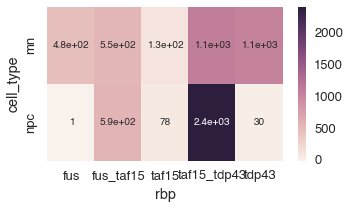

In [347]:
with dataviz.Figure(os.path.join(img_dir, "number_of_changing_genes.svg"), figsize=(5, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(significant_knockdowns.groupby(level=['cell_type', "rbp"]).count().padj.unstack(), annot=True, ax=ax)

Figure Legend: Total Number of Genes changing in both NPC and MN for FUS, FUS/TAF15, TAF15, TAF15/TDP43 and TDP43 knockdowns 

In [348]:
pd.concat({"All": significant_knockdowns.groupby(level=['cell_type', "rbp"]).count().padj.unstack(),
"Significantly Upregulated" :signifcant_upregulated.groupby(level=['cell_type', "rbp"]).count().padj.unstack(),
 "Significantly Downregulaed" :signifcant_downregulated.groupby(level=['cell_type', "rbp"]).count().padj.unstack()})

rbp                                   fus  fus_taf15  taf15  taf15_tdp43  \
                           cell_type                                       
All                        mn         484        554    126         1115   
                           npc          1        587     78         2425   
Significantly Downregulaed mn         427        490    106          925   
                           npc          1        338     48         1360   
Significantly Upregulated  mn          57         64     20          190   
                           npc        NaN        249     30         1065   

rbp                                   tdp43  
                           cell_type         
All                        mn          1068  
                           npc           30  
Significantly Downregulaed mn           882  
                           npc           23  
Significantly Upregulated  mn           186  
                           npc            7

Figure Legend: Total Number of Genes and direction of change in both NPC and MN for FUS, FUS/TAF15, TAF15, TAF15/TDP43 and TDP43 knockdowns 

#How do all the RBPs overlap for upregulation and downregluation?

In [349]:
15 + 17 + 13 + 61 + 3 + 8 + 3 + 6

126

In [350]:
18 + 86 + 1 + 19

124

In [351]:
211 + 279

490

In [352]:
signifcant_upregulated.groupby(level=["cell_type", "rbp"]).count()

baseMean  log2FoldChange  lfcSE  stat  pvalue  padj  \
cell_type rbp                                                                
mn        fus                57              57     57    57      57    57   
          fus_taf15          64              64     64    64      64    64   
          taf15              20              20     20    20      20    20   
          taf15_tdp43       190             190    190   190     190   190   
          tdp43             186             186    186   186     186   186   
npc       fus_taf15         249             249    249   249     249   249   
          taf15              30              30     30    30      30    30   
          taf15_tdp43      1065            1065   1065  1065    1065  1065   
          tdp43               7               7      7     7       7     7   

                       gene_name  
cell_type rbp                     
mn        fus                 57  
          fus_taf15           64  
          taf15               20  
          taf15_tdp43        190  
          tdp43              186  
npc       fus_taf15          249  
          taf15               30  
          taf15_tdp43       1065  
          tdp43                7

In [353]:
significant_all_knockdowns.groupby(level=["cell_type", "rbp"]).count()

baseMean  lfcSE  log2FoldChange  padj  pvalue  stat  \
cell_type  rbp                                                                
R521G      fus              2174   2174            2174  2174    2174  2174   
SpinalCord fus               120    120             120   120     120   120   
           taf15               5      5               5     5       5     5   
Straitum   fus               141    141             141   141     141   141   
           taf15             381    381             381   381     381   381   
           tdp43            1440   1440            1440  1440    1440  1440   
WholeBrain taf15             169    169             169   169     169   169   
mn         fus               484    484             484   484     484   484   
           fus_taf15         554    554             554   554     554   554   
           sALS             3876   3876            3876  3876    3876  3876   
           taf15             126    126             126   126     126   126   
           taf15_tdp43      1115   1115            1115  1115    1115  1115   
           tdp43            1068   1068            1068  1068    1068  1068   
npc        fus                 1      1               1     1       1     1   
           fus_taf15         587    587             587   587     587   587   
           taf15              78     78              78    78      78    78   
           taf15_tdp43      2425   2425            2425  2425    2425  2425   
           tdp43              30     30              30    30      30    30   

                        gene_name  
cell_type  rbp                     
R521G      fus               2174  
SpinalCord fus                120  
           taf15                5  
Straitum   fus                141  
           taf15              381  
           tdp43             1440  
WholeBrain taf15              169  
mn         fus                484  
           fus_taf15          554  
           sALS              3876  
           taf15              126  
           taf15_tdp43       1115  
           tdp43             1068  
npc        fus                  1  
           fus_taf15          587  
           taf15               78  
           taf15_tdp43       2425  
           tdp43               30

In [354]:
signifcant_downregulated.groupby(level=["cell_type", "rbp"]).count()

baseMean  log2FoldChange  lfcSE  stat  pvalue  padj  \
cell_type rbp                                                                
mn        fus               427             427    427   427     427   427   
          fus_taf15         490             490    490   490     490   490   
          taf15             106             106    106   106     106   106   
          taf15_tdp43       925             925    925   925     925   925   
          tdp43             882             882    882   882     882   882   
npc       fus                 1               1      1     1       1     1   
          fus_taf15         338             338    338   338     338   338   
          taf15              48              48     48    48      48    48   
          taf15_tdp43      1360            1360   1360  1360    1360  1360   
          tdp43              23              23     23    23      23    23   

                       gene_name  
cell_type rbp                     
mn        fus                427  
          fus_taf15          490  
          taf15              106  
          taf15_tdp43        925  
          tdp43              882  
npc       fus                  1  
          fus_taf15          338  
          taf15               48  
          taf15_tdp43       1360  
          tdp43               23

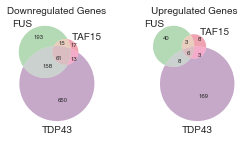

In [355]:
with dataviz.Figure(os.path.join(img_dir, "mn_up_and_down_regulation_overlap.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn3([signifcant_downregulated.ix['mn', 'fus'].index,
    signifcant_downregulated.ix['mn', 'taf15'].index,
    signifcant_downregulated.ix['mn', 'tdp43'].index,],
            set_labels=("FUS", "TAF15", "TDP43"), 
        set_colors=(rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['tdp43']), ax=ax)
    ax.set_title("Downregulated Genes", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels]
    [label.set_fontsize(10) for label in venn.set_labels]

    
    ax = fig.add_subplot(1,2,2)
    venn = venn3([signifcant_upregulated.ix['mn', 'fus'].index,
    signifcant_upregulated.ix['mn', 'taf15'].index,
    signifcant_upregulated.ix['mn', 'tdp43'].index,],
            set_labels=("FUS", "TAF15", "TDP43"), 
            set_colors=(rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['tdp43']), ax=ax)
    ax.set_title("Upregulated Genes", fontsize=10)

    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels]

Figure Legend: Venn Diagram of co-up and downregulated changes for TAF15, TDP43 and FUS in MNs

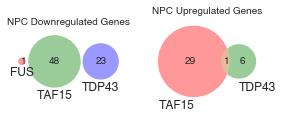

In [356]:
with dataviz.Figure(os.path.join(img_dir, "npc_up_and_down_regulation_overlap.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn3([signifcant_downregulated.ix['npc', 'fus'].index,
    signifcant_downregulated.ix['npc', 'taf15'].index,
    signifcant_downregulated.ix['npc', 'tdp43'].index,],
            set_labels=("FUS", "TAF15", "TDP43"), ax = ax )
    ax.set_title("NPC Downregulated Genes", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels]
    
    ax = fig.add_subplot(1,2,2)
    venn2([#signifcant_upregulated.ix['npc', 'fus'].index,
    signifcant_upregulated.ix['npc', 'taf15'].index,
    signifcant_upregulated.ix['npc', 'tdp43'].index,],
            set_labels=("TAF15", "TDP43"), ax = ax )
    ax.set_title("NPC Upregulated Genes", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels]

Figure Legend: Venn Diagram of co-up and downregulated changes for TAF15, TDP43 and FUS in NPCs

#How do the pairwise knockdowns work together for FUS and TAF15?

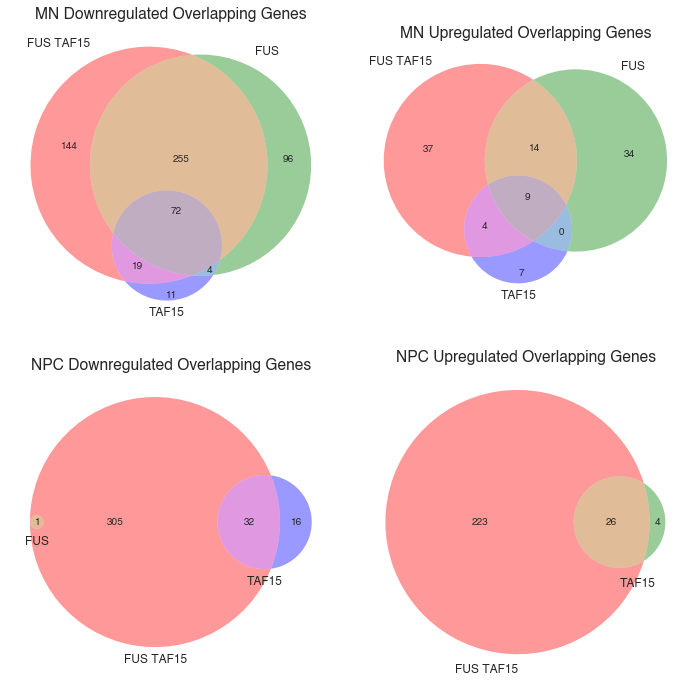

In [357]:
with dataviz.Figure(os.path.join(img_dir, "up_and_down_regulation_overlap_fus_taf15.svg"), figsize=(10, 10)) as fig:
    ax = fig.add_subplot(2,2,1)
    venn3([signifcant_downregulated.ix['mn', 'fus_taf15'].index,
    signifcant_downregulated.ix['mn', 'fus'].index,
    signifcant_downregulated.ix['mn', 'taf15'].index,],
            set_labels=("FUS TAF15", "FUS", "TAF15"), ax=ax)
    ax.set_title("MN Downregulated Overlapping Genes")
    
    ax = fig.add_subplot(2,2,2)
    venn3([signifcant_upregulated.ix['mn', 'fus_taf15'].index,
    signifcant_upregulated.ix['mn', 'fus'].index,
    signifcant_upregulated.ix['mn', 'taf15'].index,],
            set_labels=("FUS TAF15", "FUS", "TAF15"), ax=ax )
    ax.set_title("MN Upregulated Overlapping Genes")
    
    ax = fig.add_subplot(2,2,3)
    venn3([signifcant_downregulated.ix['npc', 'fus_taf15'].index,
    signifcant_downregulated.ix['npc', 'fus'].index,
    signifcant_downregulated.ix['npc', 'taf15'].index,],
            set_labels=("FUS TAF15", "FUS", "TAF15"), ax=ax)
    ax.set_title("NPC Downregulated Overlapping Genes")
    
    ax = fig.add_subplot(2,2,4)
    venn2([signifcant_upregulated.ix['npc', 'fus_taf15'].index,
    #signifcant_upregulated.ix['npc', 'fus'].index,
    signifcant_upregulated.ix['npc', 'taf15'].index,],
            set_labels=("FUS TAF15", "TAF15"), ax=ax )
    ax.set_title("NPC Upregulated Overlapping Genes")

Figure Legend: Venn Diagram of co-up and downregulated changes for the double knockdowns TAF15 and FUS and the single knockdowns of TAF15 and FUS in both MNs and NPCs

#For figure Just the MN FUS / TAF15 Upregulation

In [358]:
img_dir

'/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/'

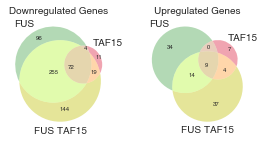

In [359]:
with dataviz.Figure(os.path.join(img_dir, "mn_up_and_down_regulation_overlap_fus_taf15.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn3([signifcant_downregulated.ix['mn', 'fus'].index,
                  signifcant_downregulated.ix['mn', 'taf15'].index,
                  signifcant_downregulated.ix['mn', 'fus_taf15'].index,],
            set_labels=("FUS", "TAF15", "FUS TAF15"), 
            set_colors=(rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['fus_taf15']), ax=ax)
    ax.set_title("Downregulated Genes", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn3([signifcant_upregulated.ix['mn', 'fus'].index,
                  signifcant_upregulated.ix['mn', 'taf15'].index,
                  signifcant_upregulated.ix['mn', 'fus_taf15'].index,
                  ],
            set_labels=("FUS", "TAF15", "FUS TAF15"), 
            set_colors=(rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['fus_taf15']), ax=ax)
    ax.set_title("Upregulated Genes", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels]

Figure Legend: Venn Diagram of co-up and downregulated changes for the double knockdowns TAF15 and FUS and the single knockdowns of TAF15 and FUS in MNs 

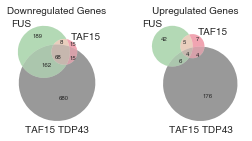

In [360]:
with dataviz.Figure(os.path.join(img_dir, "mn_up_and_down_regulation_overlap_taf15_tbp43.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn3([signifcant_downregulated.ix['mn', 'fus'].index,
                  signifcant_downregulated.ix['mn', 'taf15'].index,
                  signifcant_downregulated.ix['mn', 'taf15_tdp43'].index,],
            set_labels=("FUS", "TAF15", "TAF15 TDP43"), 
            set_colors=(rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['taf15_tdp43']), ax=ax)
    ax.set_title("Downregulated Genes", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels]
    
    ax = fig.add_subplot(1,2,2)
    venn = venn3([signifcant_upregulated.ix['mn', 'fus'].index,
                  signifcant_upregulated.ix['mn', 'taf15'].index,
                  signifcant_upregulated.ix['mn', 'taf15_tdp43'].index,
                  ],
            set_labels=("FUS", "TAF15", "TAF15 TDP43"), 
            set_colors=(rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['taf15_tdp43']), ax=ax)
    ax.set_title("Upregulated Genes", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels]

Figure Legend: Venn Diagram of co-up and downregulated changes for the double knockdowns TAF15 and TDP43 and the single knockdowns of TAF15 and TDP43 in MNs 

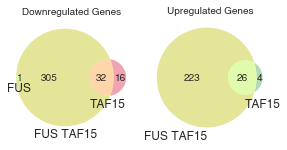

In [361]:
with dataviz.Figure(os.path.join(img_dir, "npc_up_and_down_regulation_overlap_fus_taf15.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn3([signifcant_downregulated.ix['npc', 'fus_taf15'].index,
    signifcant_downregulated.ix['npc', 'fus'].index,
    signifcant_downregulated.ix['npc', 'taf15'].index,],
            set_labels=("FUS TAF15", "FUS", "TAF15"), 
            set_colors=( rbp_colors['fus_taf15'], rbp_colors['fus'], rbp_colors['taf15']), ax=ax)

    ax.set_title("Downregulated Genes", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels]
    
    ax = fig.add_subplot(1,2,2)
    venn2([signifcant_upregulated.ix['npc', 'fus_taf15'].index,
    #signifcant_upregulated.ix['npc', 'fus'].index,
    signifcant_upregulated.ix['npc', 'taf15'].index,],
            set_labels=("FUS TAF15", "TAF15"), 
            set_colors=(rbp_colors['fus_taf15'], rbp_colors['fus'], rbp_colors['taf15']), ax=ax)
    ax.set_title("Upregulated Genes", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels]

Figure Legend: Venn Diagram of co-up and downregulated changes for the double knockdowns TAF15 and FUS and the single knockdowns of TAF15 and FUS in NPCs 

In [362]:
# with dataviz.Figure(os.path.join(img_dir, "npc_up_and_down_regulation_overlap_taf15_tbp43.svg"), figsize=(4, 2)) as fig:
#     ax = fig.add_subplot(1,2,1)
#     venn3([signifcant_downregulated.ix['npc', 'taf15_tdp43'].index,
#     signifcant_downregulated.ix['npc', 'fus'].index,
#     signifcant_downregulated.ix['npc', 'taf15'].index,],
#             set_labels=("TAF15 TDP43", "FUS", "TAF15"), 
#             set_colors=( rbp_colors['taf15_tdp43'], rbp_colors['fus'], rbp_colors['taf15']), ax=ax)

#     ax.set_title("Downregulated Genes", fontsize=10)
#     [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
#     [label.set_fontsize(10) for label in venn.set_labels]
    
#     ax = fig.add_subplot(1,2,2)
#     venn2([signifcant_upregulated.ix['npc', 'taf15_tdp43'].index,
#     #signifcant_upregulated.ix['npc', 'fus'].index,
#     signifcant_upregulated.ix['npc', 'taf15'].index,],
#             set_labels=("TAF15 TDP43", "TAF15"), 
#             set_colors=(rbp_colors['taf15_tdp43'], rbp_colors['fus'], rbp_colors['taf15']), ax=ax)
#     ax.set_title("Upregulated Genes", fontsize=10)
#     [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
#     [label.set_fontsize(10) for label in venn.set_labels]

Figure Legend: Venn Diagram of co-up and downregulated changes for the double knockdowns TAF15 and TDP43 and the single knockdowns of TAF15 and TDP43 in NPCs 

<matplotlib_venn._common.VennDiagram instance at 0x2aaafcbb8b90>

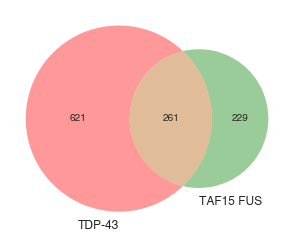

In [363]:
venn2([signifcant_downregulated.ix[('mn', 'tdp43')].index,
       signifcant_downregulated.ix[('mn', 'fus_taf15')].index],
     set_labels=["TDP-43", "TAF15 FUS"])

In [364]:
rpkm[name_to_gene_id['TARDBP']]

cell_type  exp                  knockdown    rep
MN         FUS_TAF15_shRNA_1    FUS_TAF15    1      28.663085
           FUS_TAF15_shRNA_2    FUS_TAF15    2      28.532364
           FUS_shRNA_1          FUS          1      26.316867
           FUS_shRNA_2          FUS          2      29.316705
           Scrm_1               Scrm         1      26.879956
           Scrm_2               Scrm         2      26.182758
           TAF15_TDP43_shRNA_1  TAF15_TDP43  1      27.370291
           TAF15_TDP43_shRNA_2  TAF15_TDP43  2      27.875746
           TAF15_shRNA_1        TAF15        1      12.567875
           TAF15_shRNA_2        TAF15        2      13.453078
           TDP43_shRNA_1        TDP43        1      11.192080
           TDP43_shRNA_2        TDP43        2      11.536159
NPC        NPC_FUS_1_p7_35      FUS          1      40.324690
           NPC_FUS_2_p7_44      FUS          2      67.592412
           NPC_Scrm_1_p7_35     Scrm         1      61.716993
           NPC_Scrm_2

In [365]:
knockdowns[knockdowns.gene_name == "TARDBP"]

baseMean  log2FoldChange  \
cell_type rbp         gene                                               
mn        fus         ENSG00000120948.11   2756.528844        0.082385   
          fus_taf15   ENSG00000120948.11   2194.635352        0.020345   
          taf15       ENSG00000120948.11   2591.071793        0.027129   
          taf15_tdp43 ENSG00000120948.11   1818.807078       -1.083901   
          tdp43       ENSG00000120948.11   1678.425568       -1.272201   
npc       fus         ENSG00000120948.11   9065.471545       -0.076243   
          fus_taf15   ENSG00000120948.11  10261.163140       -0.157148   
          taf15       ENSG00000120948.11  11492.009338       -0.150759   
          taf15_tdp43 ENSG00000120948.11  12040.139625       -0.923571   
          tdp43       ENSG00000120948.11   7835.048280       -0.934987   

                                             lfcSE       stat        pvalue  \
cell_type rbp         gene                                                    
mn        fus         ENSG00000120948.11  0.071774   1.147836  2.510364e-01   
          fus_taf15   ENSG00000120948.11  0.077108   0.263850  7.918955e-01   
          taf15       ENSG00000120948.11  0.067696   0.400746  6.886069e-01   
          taf15_tdp43 ENSG00000120948.11  0.080864 -13.403994  5.729499e-41   
          tdp43       ENSG00000120948.11  0.085372 -14.901797  3.208355e-50   
npc       fus         ENSG00000120948.11  0.306328  -0.248894  8.034424e-01   
          fus_taf15   ENSG00000120948.11  0.186516  -0.842542  3.994845e-01   
          taf15       ENSG00000120948.11  0.220243  -0.684515  4.936498e-01   
          taf15_tdp43 ENSG00000120948.11  0.189114  -4.883678  1.041253e-06   
          tdp43       ENSG00000120948.11  0.315999  -2.958831  3.088088e-03   

                                                  padj gene_name  
cell_type rbp         gene                                        
mn        fus         ENSG00000120948.11  5.013857e-01    TARDBP  
          fus_taf15   ENSG00000120948.11  9.208056e-01    TARDBP  
          taf15       ENSG00000120948.11  9.321952e-01    TARDBP  
          taf15_tdp43 ENSG00000120948.11  1.117652e-38    TARDBP  
          tdp43       ENSG00000120948.11  1.086404e-47    TARDBP  
npc       fus         ENSG00000120948.11  9.999920e-01    TARDBP  
          fus_taf15   ENSG00000120948.11  7.342710e-01    TARDBP  
          taf15       ENSG00000120948.11  8.883317e-01    TARDBP  
          taf15_tdp43 ENSG00000120948.11  4.765308e-05    TARDBP  
          tdp43       ENSG00000120948.11  1.830751e-01    TARDBP

In [366]:
signifcant_downregulated[signifcant_downregulated.gene_name == "TARDBP"]

baseMean  log2FoldChange  \
cell_type rbp         gene                                               
mn        taf15_tdp43 ENSG00000120948.11   1818.807078       -1.083901   
          tdp43       ENSG00000120948.11   1678.425568       -1.272201   
npc       taf15_tdp43 ENSG00000120948.11  12040.139625       -0.923571   

                                             lfcSE       stat        pvalue  \
cell_type rbp         gene                                                    
mn        taf15_tdp43 ENSG00000120948.11  0.080864 -13.403994  5.729499e-41   
          tdp43       ENSG00000120948.11  0.085372 -14.901797  3.208355e-50   
npc       taf15_tdp43 ENSG00000120948.11  0.189114  -4.883678  1.041253e-06   

                                                  padj gene_name  
cell_type rbp         gene                                        
mn        taf15_tdp43 ENSG00000120948.11  1.117652e-38    TARDBP  
          tdp43       ENSG00000120948.11  1.086404e-47    TARDBP  
npc       taf15_tdp43 ENSG00000120948.11  4.765308e-05    TARDBP

<matplotlib_venn._common.VennDiagram instance at 0x2aaafd214998>

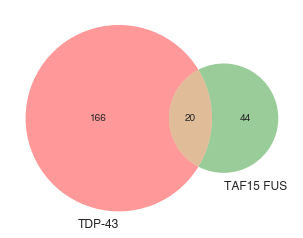

In [367]:
venn2([signifcant_upregulated.ix[('mn', 'tdp43')].index,
       signifcant_upregulated.ix[('mn', 'fus_taf15')].index],
     set_labels=["TDP-43", "TAF15 FUS"])

#Combine all of the double knockdown venns

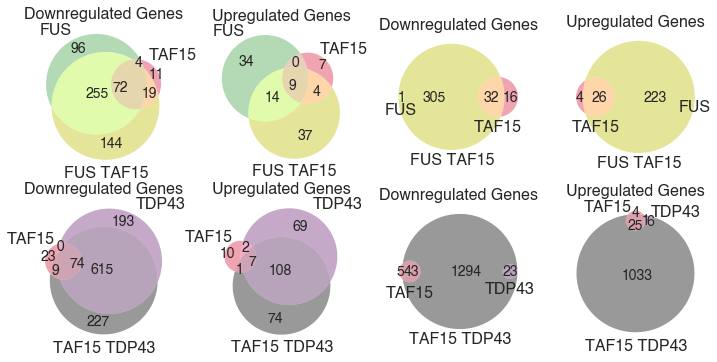

In [368]:
num_rows = 2
num_cols = 4
with dataviz.Figure(os.path.join(img_dir, "all_up_and_down_regulation_overlap.svg"), figsize=(num_cols *2.5,  num_rows*2.5)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)
    counter = 0
    for x, rbp in enumerate(['fus_taf15', 'taf15_tdp43']):
        for y, cell_type in enumerate(['mn', 'npc']):
            for z, (name, df) in enumerate({"Downregulated Genes": signifcant_downregulated, "Upregulated Genes": signifcant_upregulated}.items()):
                counter += 1
                ax = fig.add_subplot(num_rows, num_cols, counter)
                double_name = " ".join(rbp.split("_")).upper()
                single_1, single_2 = rbp.split("_")
                try:
                    a = set(df.ix[cell_type, single_1].index)
                except KeyError:
                    a = set()
                try:
                    b = set(df.ix[cell_type, single_2].index)
                except KeyError:
                    b = set()
                try:
                    c= set(df.ix[cell_type, rbp].index)
                except KeyError:
                    c = set()
                venn = venn3([a, b, c],
                        set_labels=(single_1.upper(), single_2.upper(), double_name), 
                        set_colors=(rbp_colors[single_1], rbp_colors[single_2], rbp_colors[rbp]), ax=ax)
                ax.set_title(name, fontsize=16)
                [label.set_fontsize(14) for label in venn.subset_labels if label is not None]
                [label.set_fontsize(16) for label in venn.set_labels]


Figure Legend: Venn Diagram of co-up and downregulated changes for the double knockdowns TAF15 and FUS or TAF15 and TDP43 and the respective single knockdowns in both MN (first 2 columns) or NPC (second 2 columns)

#Overlaps between cell types

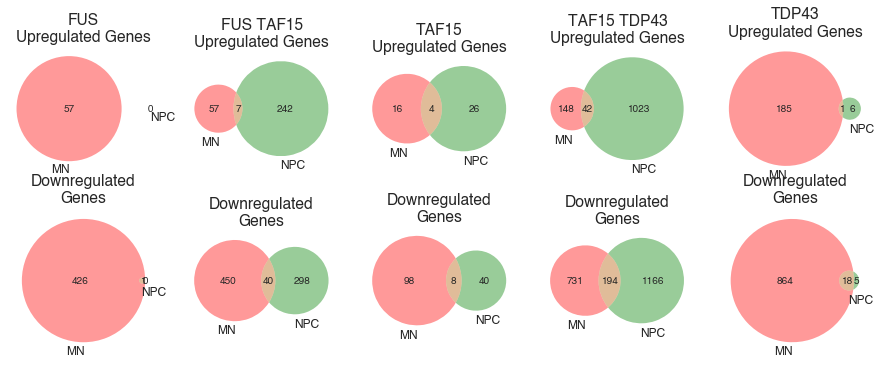

In [369]:
num_rows = 2
num_cols = 5
overlapping = {}
with dataviz.Figure(os.path.join(img_dir, "up_and_down_regulation_overlap_between_cell_types.svg"), figsize=(num_cols * 2.5, num_rows * 2.5)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)
    for x, ((downregulated_name, downregluated_df), (upregulated_name, upregluated_df)) in enumerate(zip(signifcant_downregulated.groupby(level="rbp"), signifcant_upregulated.groupby(level="rbp"))):
        
        ax = fig.add_subplot(gs[1,x]) 
        venn2([downregluated_df.ix['mn'].index.get_level_values(level='gene'),
               downregluated_df.ix['npc'].index.get_level_values(level='gene'),
        ],
                set_labels=("MN", "NPC"), ax =ax )
        ax.set_title("Downregulated\nGenes")

        ax = fig.add_subplot(gs[0,x]) 
        venn2([upregluated_df.ix['mn'].index.get_level_values(level='gene'),
        upregluated_df.ix['npc'].index.get_level_values(level='gene'),
        ],
                set_labels=("MN", "NPC"), ax =ax )
        ax.set_title(rbp_names[upregulated_name] + "\nUpregulated Genes")
        
        overlapping["downregulated_" + downregulated_name] = Counter(downregluated_df.ix['mn'].index.get_level_values(level='gene') & downregluated_df.ix['npc'].index.get_level_values(level='gene'))
        overlapping["upregulated_" + upregulated_name] = Counter(upregluated_df.ix['mn'].index.get_level_values(level='gene') & upregluated_df.ix['npc'].index.get_level_values(level='gene'),)


Figure Legend: Venn Diagram of co-up and downregulated changes the same knockdown in NPC and MNs

#ALS Specific Gene Analysis

In [370]:
name_to_gene_id_lower = {key.lower(): value for key, value in name_to_gene_id.items()}
als_specific_genes = pd.read_excel("/nas3/gpratt/Dropbox/TAF15/Data/als_specific_genes/Workbook1.xlsx", "Sheet1")

als_specifc_gene_list = []
for als_gene in als_specific_genes['Gene symbol']:
    try:
        als_specifc_gene_list.append(name_to_gene_id[als_gene])
    except KeyError:
        print als_gene

ALS3
ALS7
SYNE


In [371]:
HTML(significant_knockdowns[[gene_id in als_specifc_gene_list for gene_id in significant_knockdowns.index.get_level_values(level="gene")]].to_html())

In [372]:
combined_significant_knockdowns = pd.concat([significant_knockdowns, ips_significant_knockdowns])

In [373]:
filtered_kds = combined_significant_knockdowns.ix[['R521G', 'mn']]
unfiltered_kds = pd.concat([knockdowns, ips_knockdowns]).ix[['R521G', 'mn']].log2FoldChange.unstack()

filtered_kds = filtered_kds[[gene_id in als_specifc_gene_list for gene_id in filtered_kds.index.get_level_values(level="gene")]].log2FoldChange.unstack()
unfiltered_kds = unfiltered_kds[filtered_kds.columns]
unfiltered_kds.columns = [gene_id_to_name[name] for name in unfiltered_kds.columns]

In [374]:
img_dir

'/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/'

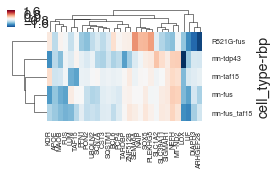

In [375]:
clustermap = sns.clustermap(unfiltered_kds.drop("taf15_tdp43", level=1).fillna(0), figsize=(3.5,2))
[label.set_fontsize(7) for label in clustermap.ax_heatmap.get_xticklabels()]
[label.set_fontsize(7) for label in clustermap.ax_heatmap.get_yticklabels()]

plt.savefig(os.path.join(img_dir, "als_specific_genes_l2fc.pdf"))
plt.savefig(os.path.join(img_dir, "als_specific_genes_l2fc.svg"))

In [376]:
ips_significant_knockdowns[[gene_id in als_specifc_gene_list for gene_id in ips_significant_knockdowns.index.get_level_values(level="gene")]]

baseMean  log2FoldChange     lfcSE  \
rbp   mutation gene                                                        
G298S tdp      ENSG00000144619.10   401.709530        1.813898  0.315249   
               ENSG00000147955.12  1160.731839       -0.729510  0.216811   
               ENSG00000214944.5     55.676331       -1.276704  0.317466   
N352S tdp      ENSG00000108518.7   2216.234028       -0.646413  0.180958   
               ENSG00000128342.4     20.073676       -1.472071  0.334325   
               ENSG00000130203.5     59.169472       -1.191164  0.223942   
               ENSG00000134532.11   459.547061        0.721451  0.259088   
               ENSG00000144619.10   745.866733        1.116987  0.332177   
               ENSG00000147955.12   831.605432       -0.784952  0.155228   
               ENSG00000171680.16  1267.888838        0.785665  0.195979   
               ENSG00000178568.9    164.473126        1.005419  0.332338   
               ENSG00000183036.6    425.573594        1.032323  0.310282   
               ENSG00000214944.5     36.365051       -1.159907  0.288217   
R521G fus      ENSG00000092421.12  2997.224423        1.057152  0.225233   
               ENSG00000100285.9   1681.878856       -0.975048  0.329171   
               ENSG00000101439.4    737.028483       -0.604241  0.200062   
               ENSG00000105854.8    264.534514       -0.975499  0.166779   
               ENSG00000108518.7   2630.612229       -0.863740  0.189970   
               ENSG00000128342.4     35.242698       -1.462428  0.395345   
               ENSG00000133195.7    113.911089       -0.694937  0.235992   
               ENSG00000134532.11   444.782210        0.770088  0.235632   
               ENSG00000139734.13    17.190049       -1.823672  0.397738   
               ENSG00000147955.12  1044.936171       -0.882205  0.134331   
               ENSG00000171680.16  1324.702695        0.960109  0.148221   
               ENSG00000188021.7   1655.469276       -0.593890  0.132590   
               ENSG00000214944.5     45.077891       -2.132020  0.324036   
               ENSG00000249437.3    986.200792        0.752378  0.230935   
T198C fus      ENSG00000092421.12  2720.059517        1.088093  0.169917   
               ENSG00000100285.9   1692.310181       -1.112191  0.362102   
               ENSG00000127824.9     82.019009       -1.304046  0.384369   
               ENSG00000130203.5     89.812265       -1.013003  0.310422   
               ENSG00000134115.8     96.368123       -3.072495  0.371590   
               ENSG00000134532.11   505.999127        1.089386  0.305648   
               ENSG00000140945.11   841.250779       -0.885001  0.235129   
               ENSG00000147955.12  1121.430384       -0.742156  0.182117   
               ENSG00000149654.5     91.694048       -1.102146  0.355601   
               ENSG00000150938.5   2671.869028        1.058346  0.289799   
               ENSG00000214944.5     49.340917       -1.915904  0.362598   
               ENSG00000262359.1    224.636447       -1.756715  0.301473   

                                       stat        pvalue          padj  \
rbp   mutation gene                                                       
G298S tdp      ENSG00000144619.10  5.753859  8.722912e-09  1.462687e-05   
               ENSG00000147955.12 -3.364730  7.661859e-04  4.694434e-02   
               ENSG00000214944.5  -4.021552  5.781604e-05  8.192776e-03   
N352S tdp      ENSG00000108518.7  -3.572171  3.540345e-04  6.788567e-03   
               ENSG00000128342.4  -4.403111  1.067095e-05  5.901189e-04   
               ENSG00000130203.5  -5.319067  1.043007e-07  1.631108e-05   
               ENSG00000134532.11  2.784577  5.359753e-03  4.208178e-02   
               ENSG00000144619.10  3.362627  7.720469e-04  1.159956e-02   
               ENSG00000147955.12 -5.056756  4.264473e-07  5.022338e-05   
               ENSG00000171680.16  4.008923  6.099626e-05  2.070725e-03   
               ENSG00

It looks like LIF is one of the few genes that is consistantly downregulated in MNs for both FUS and TDP mutants and konckdowns.  Lets double check by looking at the rpkms

#Lif Only Analysis

In [377]:
def gene_specific_formatting(series):
    df = pd.DataFrame(series)
    df['cell_type'] = df.index.get_level_values(level='cell_type')
    df['exp'] = df.index.get_level_values(level='exp')
    df['knockdown'] = df.index.get_level_values(level='knockdown')
    df['rep'] = df.index.get_level_values(level='rep')
    #hacky way to reorder this ish

    reorder = {'Scrm' : 0 , 
     'TAF15_TDP43': 1, 
     'TDP43': 2, 
     'TAF15': 3,
     'FUS_TAF15': 4,
     'FUS': 5}

    new_index = []
    for index in df.index:
        index = list(index)
        index.append(reorder[index[2]])
        new_index.append(index)
    df.index = pd.MultiIndex.from_tuples(new_index, names=['cell_type', 'exp', 'knockdown', 'rep', "sort_order"])
    df = df.sortlevel("sort_order")
    return df

In [378]:
lif_only = rpkm[name_to_gene_id['LIF']].copy()
lif_only_df = gene_specific_formatting(lif_only)

In [379]:
img_dir

'/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/'

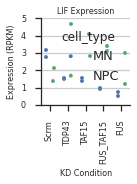

In [380]:
num_rows = 2
num_cols = 1
with sns.axes_style("ticks", {'axes.grid': True}):
    with dataviz.Figure(os.path.join(img_dir, "lif_kd_expression.svg"), figsize=(2.0 * num_cols, 2.0 * num_rows)) as fig:
        ax = fig.add_subplot(num_rows,num_cols,1)

        sns.stripplot("knockdown", "ENSG00000128342.4", 
                       "cell_type", 
                       data=lif_only_df.drop("TAF15_TDP43", level="knockdown"), 
                      size=4,
                      linewidth=.1,
                      jitter=.05,
                       ax=ax)


        ax.set_ylabel("Expression (RPKM)", fontsize=8)
        ax.set_title("LIF Expression", fontsize=8)
        ax.set_xlabel("KD Condition", fontsize=8)
        sns.despine(ax=ax)
        [tick.set_rotation(90) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(8) for tick in ax.get_yticklabels()]

In [381]:
stat3_only = rpkm[name_to_gene_id['STAT3']].copy()
stat3_only = gene_specific_formatting(stat3_only)

In [382]:
stat3_only

ENSG00000168610.10  \
cell_type exp                 knockdown   rep sort_order                       
MN        Scrm_1              Scrm        1   0                    44.334587   
          Scrm_2              Scrm        2   0                    45.262888   
NPC       NPC_Scrm_1_p7_35    Scrm        1   0                    17.838766   
          NPC_Scrm_2_p7_44    Scrm        2   0                    12.354919   
MN        TAF15_TDP43_shRNA_1 TAF15_TDP43 1   1                    43.007549   
          TAF15_TDP43_shRNA_2 TAF15_TDP43 2   1                    42.736920   
NPC       NPC_T+T_1_p7_44     TAF15_TDP43 1   1                    21.507611   
          NPC_T+T_2_p7_44     TAF15_TDP43 2   1                    19.308973   
MN        TDP43_shRNA_1       TDP43       1   2                    43.097719   
          TDP43_shRNA_2       TDP43       2   2                    39.474013   
NPC       NPC_TDP43_1_p_44    TDP43       1   2                    25.317465   
MN        TAF15_shRNA_1       TAF15       1   3                    40.320459   
          TAF15_shRNA_2       TAF15       2   3                    38.683375   
NPC       NPC_TAF15_1_p7_35   TAF15       1   3                    19.409152   
          NPC_TAF15_2_p7_44   TAF15       2   3                    24.611085   
MN        FUS_TAF15_shRNA_1   FUS_TAF15   1   4                    39.807770   
          FUS_TAF15_shRNA_2   FUS_TAF15   2   4                    37.580115   
NPC       NPC_T+F_1_p7_44     FUS_TAF15   1   4                    20.987292   
          NPC_T+F_2_p7_44     FUS_TAF15   2   4                    20.520847   
MN        FUS_shRNA_1         FUS         1   5                    37.184651   
          FUS_shRNA_2         FUS         2   5                    37.412899   
NPC       NPC_FUS_1_p7_35     FUS         1   5                     7.103218   
          NPC_FUS_2_p7_44     FUS         2   5                    16.054412   

                                                         cell_type  \
cell_type exp                 knockdown   rep sort_order             
MN        Scrm_1              Scrm        1   0                 MN   
          Scrm_2              Scrm        2   0                 MN   
NPC       NPC_Scrm_1_p7_35    Scrm        1   0                NPC   
          NPC_Scrm_2_p7_44    Scrm        2   0                NPC   
MN        TAF15_TDP43_shRNA_1 TAF15_TDP43 1   1                 MN   
          TAF15_TDP43_shRNA_2 TAF15_TDP43 2   1                 MN   
NPC       NPC_T+T_1_p7_44     TAF15_TDP43 1   1                NPC   
          NPC_T+T_2_p7_44     TAF15_TDP43 2   1                NPC   
MN        TDP43_shRNA_1       TDP43       1   2                 MN   
          TDP43_shRNA_2       TDP43       2   2                 MN   
NPC       NPC_TDP43_1_p_44    TDP43       1   2                NPC   
MN        TAF15_shRNA_1       TAF15       1   3                 MN   
          TAF15_shRNA_2       TAF15       2   3                 MN   
NPC       NPC_TAF15_1_p7_35   TAF15       1   3                NPC   
          NPC_TAF15_2_p7_44   TAF15       2   3                NPC   
MN        FUS_TAF15_shRNA_1   FUS_TAF15   1   4                 MN   
          FUS_TAF15_shRNA_2   FUS_TAF15   2   4                 MN   
NPC       NPC_T+F_1_p7_44     FUS_TAF15   1   4                NPC   
          NPC_T+F_2_p7_44     FUS_TAF15   2   4                NPC   
MN        FUS_shRNA_1         FUS         1   5                 MN   
          FUS_shRNA_2         FUS         2   5                 MN   
NPC       NPC_FUS_1_p7_35     FUS         1   5                NPC   
          NPC_FUS_2_p7_44     FUS         2   5                NPC   

                                                                          exp  \
cell_type exp                 knockdown   rep sort_order                        
MN        Scrm_1              Scrm        1   0                        Scrm_1   
          Scrm_2              Scrm        2   0                

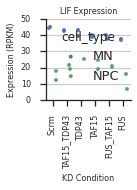

In [383]:
num_rows = 2
num_cols = 1
with sns.axes_style("ticks", {'axes.grid': True}):
    with dataviz.Figure(os.path.join(img_dir, "stat3_kd_expression.svg"), figsize=(2.0 * num_cols, 2.0 * num_rows)) as fig:
        ax = fig.add_subplot(num_rows,num_cols,1)

        sns.stripplot("knockdown", "ENSG00000168610.10", 
                       "cell_type", 
                       data=stat3_only, 
                      size=4,
                      linewidth=.1,
                      jitter=.05,
                       ax=ax)


        ax.set_ylabel("Expression (RPKM)", fontsize=8)
        ax.set_title("LIF Expression", fontsize=8)
        ax.set_xlabel("KD Condition", fontsize=8)
        sns.despine(ax=ax)
        [tick.set_rotation(90) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(8) for tick in ax.get_yticklabels()]

In [384]:
knockdowns[knockdowns.gene_name == "STAT3"]

baseMean  log2FoldChange  \
cell_type rbp         gene                                              
mn        fus         ENSG00000168610.10  7964.115646       -0.229943   
          fus_taf15   ENSG00000168610.10  6334.296867       -0.307889   
          taf15       ENSG00000168610.10  7999.419652       -0.090264   
          taf15_tdp43 ENSG00000168610.10  7328.049979       -0.265533   
          tdp43       ENSG00000168610.10  7189.210319       -0.200753   
npc       fus         ENSG00000168610.10  3778.601493       -0.185376   
          fus_taf15   ENSG00000168610.10  5273.274857        0.254284   
          taf15       ENSG00000168610.10  6074.044167        0.300533   
          taf15_tdp43 ENSG00000168610.10  8716.313366        0.538314   
          tdp43       ENSG00000168610.10  4626.937128        0.299248   

                                             lfcSE      stat        pvalue  \
cell_type rbp         gene                                                   
mn        fus         ENSG00000168610.10  0.058403 -3.937183  8.244388e-05   
          fus_taf15   ENSG00000168610.10  0.055952 -5.502746  3.739212e-08   
          taf15       ENSG00000168610.10  0.051659 -1.747281  8.058867e-02   
          taf15_tdp43 ENSG00000168610.10  0.050918 -5.214880  1.839361e-07   
          tdp43       ENSG00000168610.10  0.063860 -3.143636  1.668629e-03   
npc       fus         ENSG00000168610.10  0.341380 -0.543019  5.871168e-01   
          fus_taf15   ENSG00000168610.10  0.203346  1.250500  2.111170e-01   
          taf15       ENSG00000168610.10  0.228091  1.317600  1.876377e-01   
          taf15_tdp43 ENSG00000168610.10  0.216088  2.491177  1.273205e-02   
          tdp43       ENSG00000168610.10  0.322891  0.926778  3.540416e-01   

                                              padj gene_name  
cell_type rbp         gene                                    
mn        fus         ENSG00000168610.10  0.001128     STAT3  
          fus_taf15   ENSG00000168610.10  0.000001     STAT3  
          taf15       ENSG00000168610.10  0.373954     STAT3  
          taf15_tdp43 ENSG00000168610.10  0.000003     STAT3  
          tdp43       ENSG00000168610.10  0.011301     STAT3  
npc       fus         ENSG00000168610.10  0.999992     STAT3  
          fus_taf15   ENSG00000168610.10  0.572532     STAT3  
          taf15       ENSG00000168610.10  0.774437     STAT3  
          taf15_tdp43 ENSG00000168610.10  0.073020     STAT3  
          tdp43       ENSG00000168610.10  0.959298     STAT3

#Lets try GO Analysis

In [385]:
hg19go = GO.hg19GO()

#Down Regulated Genes

In [386]:
signifcant_downregulated.xs(name_to_gene_id['ITGA5'], level="gene")

baseMean  log2FoldChange     lfcSE       stat  \
cell_type rbp                                                            
mn        fus          272.159783       -1.032274  0.149863  -6.888132   
          fus_taf15    201.508570       -1.405066  0.172947  -8.124252   
          taf15        255.279670       -0.955220  0.132104  -7.230798   
          taf15_tdp43  204.424704       -2.274050  0.187817 -12.107827   
          tdp43        205.940543       -1.924744  0.185952 -10.350778   

                             pvalue          padj gene_name  
cell_type rbp                                                
mn        fus          5.652987e-12  2.980178e-10     ITGA5  
          fus_taf15    4.501291e-16  3.910252e-14     ITGA5  
          taf15        4.801651e-13  7.875280e-11     ITGA5  
          taf15_tdp43  9.600418e-34  1.610566e-31     ITGA5  
          tdp43        4.151004e-25  4.685335e-23     ITGA5

In [387]:
for name, df in signifcant_downregulated.groupby(level="rbp"):
    df.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/downregulated_" + name + ".csv")
    
for name, df in signifcant_upregulated.groupby(level="rbp"):
    df.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/upregulated_" + name + ".csv")

In [388]:
#This takes a few minutes...
downregulated_go = {}
for name, df in signifcant_downregulated.groupby(level=["cell_type", "rbp"]):
    cell_type = name[0]
    downregulated_go[name] = hg19go.enrichment(gencode_to_ensembl(df.index.get_level_values(level="gene")),
                                               background=expressed_genes[cell_type])
    
downregulated_go = pd.concat(downregulated_go, names=['cell_type', 'rbp', 'go_term_id'])
downregulated_go = downregulated_go[downregulated_go['Bonferroni-corrected Hypergeometric p-Value'] < .05]

upregulated_go = {}
for name, df in signifcant_upregulated.groupby(level=["cell_type", "rbp"]):
    cell_type = name[0]
    upregulated_go[name] = hg19go.enrichment(gencode_to_ensembl(df.index.get_level_values(level="gene")),
                                             background=expressed_genes[cell_type])
    
upregulated_go = pd.concat(upregulated_go,  names=['cell_type', 'rbp', 'go_term_id'])
upregulated_go = upregulated_go[upregulated_go['Bonferroni-corrected Hypergeometric p-Value'] < .05]


#All Terms Up and Down Regulated

In [389]:
HTML(downregulated_go[downregulated_go['Bonferroni-corrected Hypergeometric p-Value'] < .05].ix['mn', 'fus_taf15'].to_html())

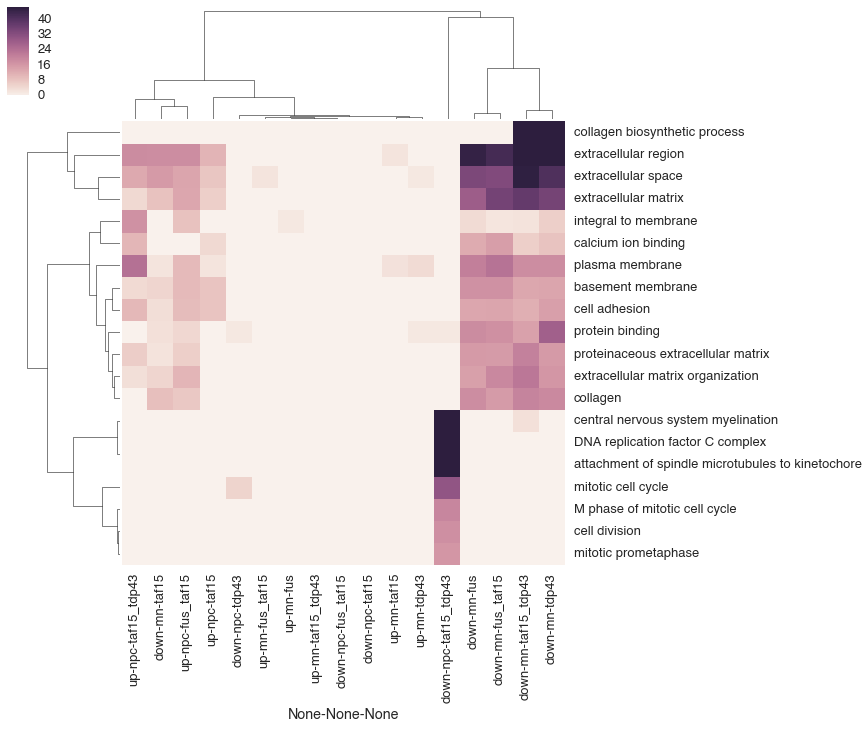

In [390]:
dataviz.plot_go_enrichment(pd.concat({"up":upregulated_go, "down": downregulated_go}), max_terms=20, filter_value=3, figsize=(10,10))
plt.savefig(os.path.join(img_dir, "all_go.pdf"))
plt.savefig(os.path.join(img_dir, "all_go.svg"))

Figure Legend: Top 20 Enriched GO terms for all knockdowns in NPC and MNs

#Down Regulated GO Terms

In [391]:
HTML(downregulated_go.to_html())

#Downregulated Everything

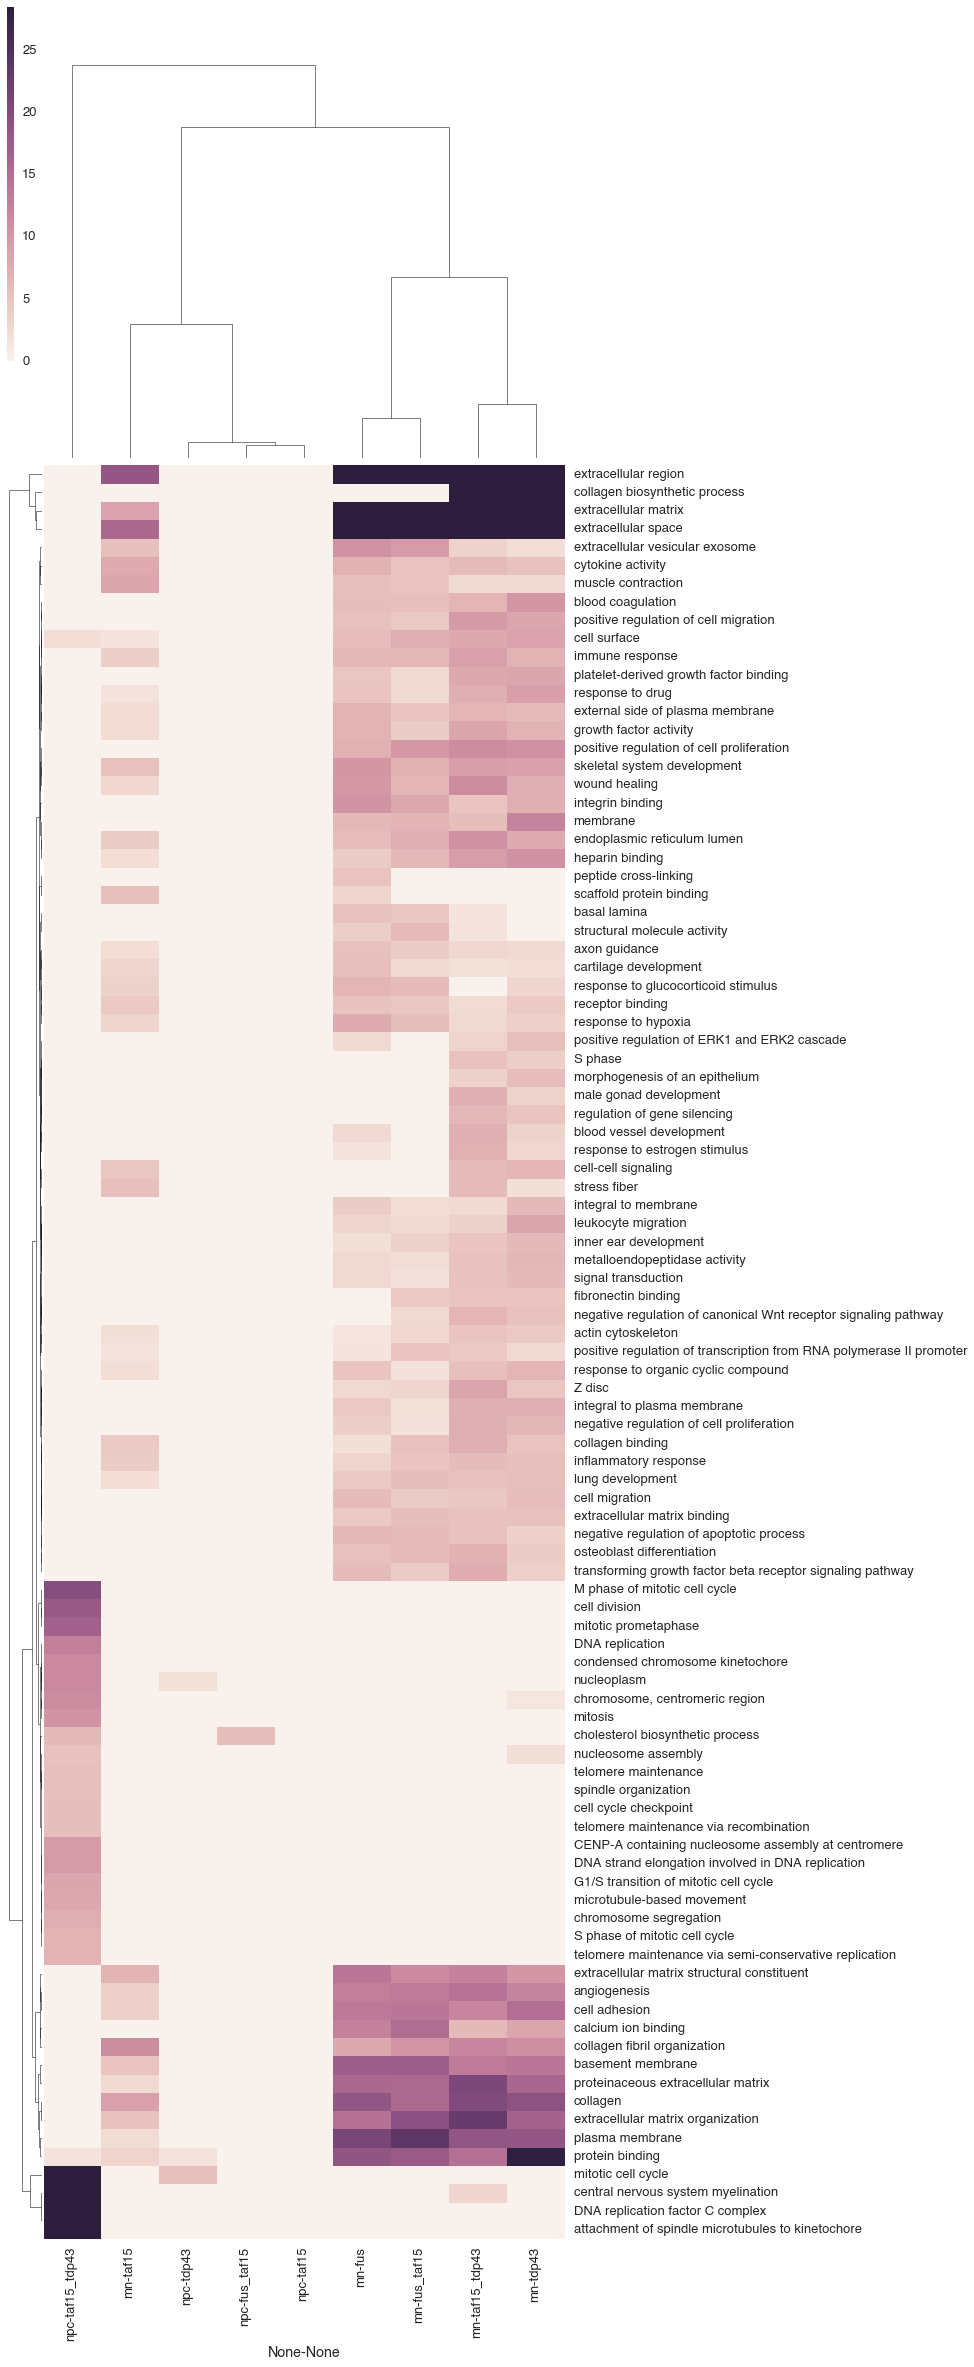

In [392]:
dataviz.plot_go_enrichment(downregulated_go, filter_value=5, figsize=(10,40))

Figure Legend: All Enriched GO terms for Downregulated Genes in all knockdowns

#Downregulated MN

In [393]:
#dataviz.plot_go_enrichment(downregulated_go.ix['mn'], filter_value=5, figsize=(10,40))


Figure Legend: All Enriched GO terms for Downregulated Genes in MN knockdowns

#DownRegulated NPC

In [394]:
#dataviz.plot_go_enrichment(downregulated_go.ix['npc'], filter_value=5)

Figure Legend: All Enriched GO terms for Downregulated Genes in NPC knockdowns

#Up Regulated GO Terms

In [395]:
#HTML(upregulated_go.to_html())

#Upregulated Everything

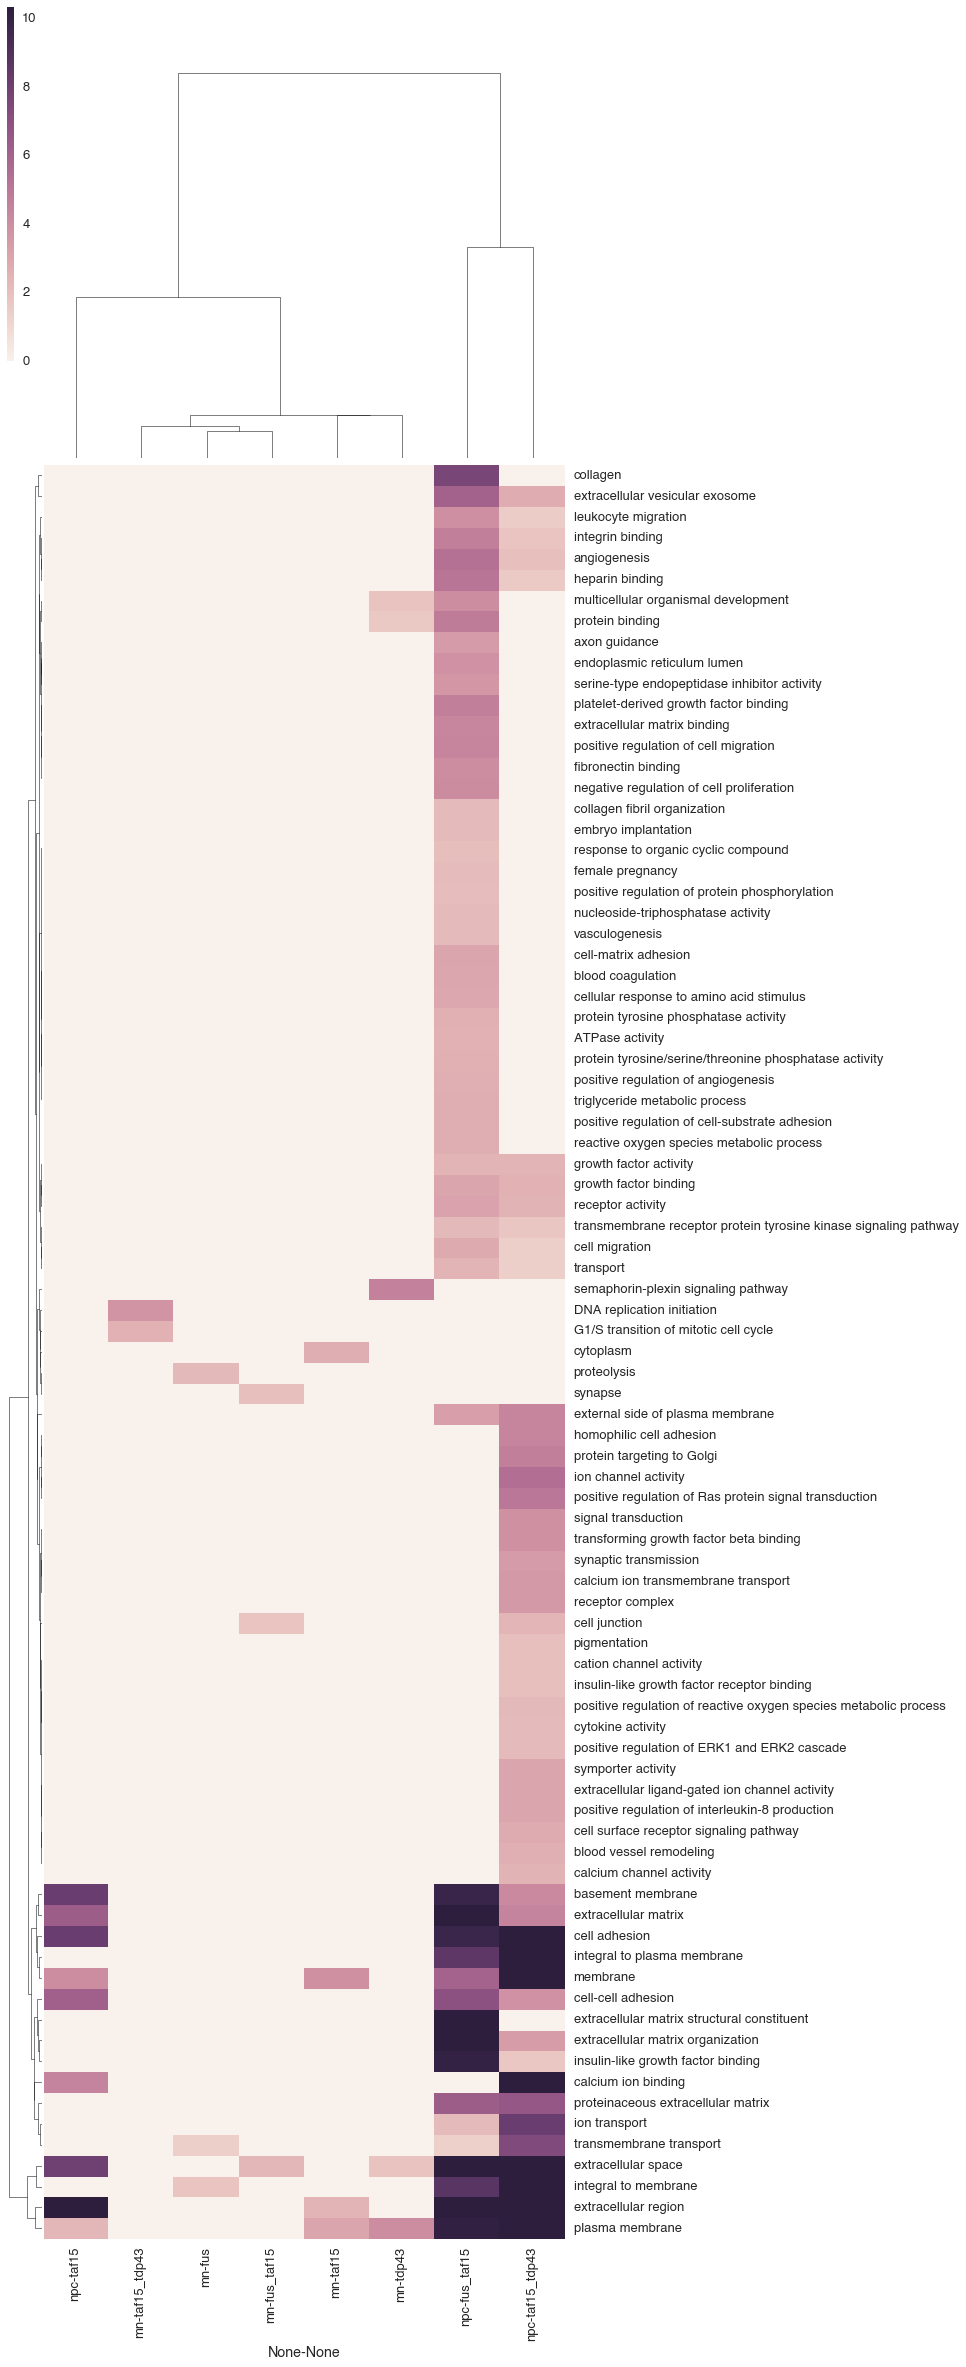

In [396]:
dataviz.plot_go_enrichment(upregulated_go, filter_value=2, figsize=(10,40))

Figure Legend: All Enriched GO terms for upregulated Genes in all knockdowns

#Upregulated MN

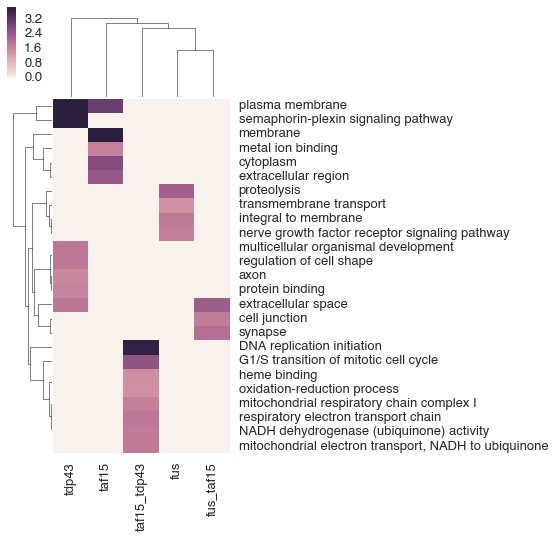

In [397]:
dataviz.plot_go_enrichment(upregulated_go.ix['mn'], filter_value=1, figsize=(4,8))
plt.savefig(os.path.join(img_dir, "mn_upregulated_go.pdf"))
plt.savefig(os.path.join(img_dir, "mn_upregulated_go.svg"))

Figure Legend: All Enriched GO terms for upregulated Genes in MN knockdowns

#Upregulated NPC

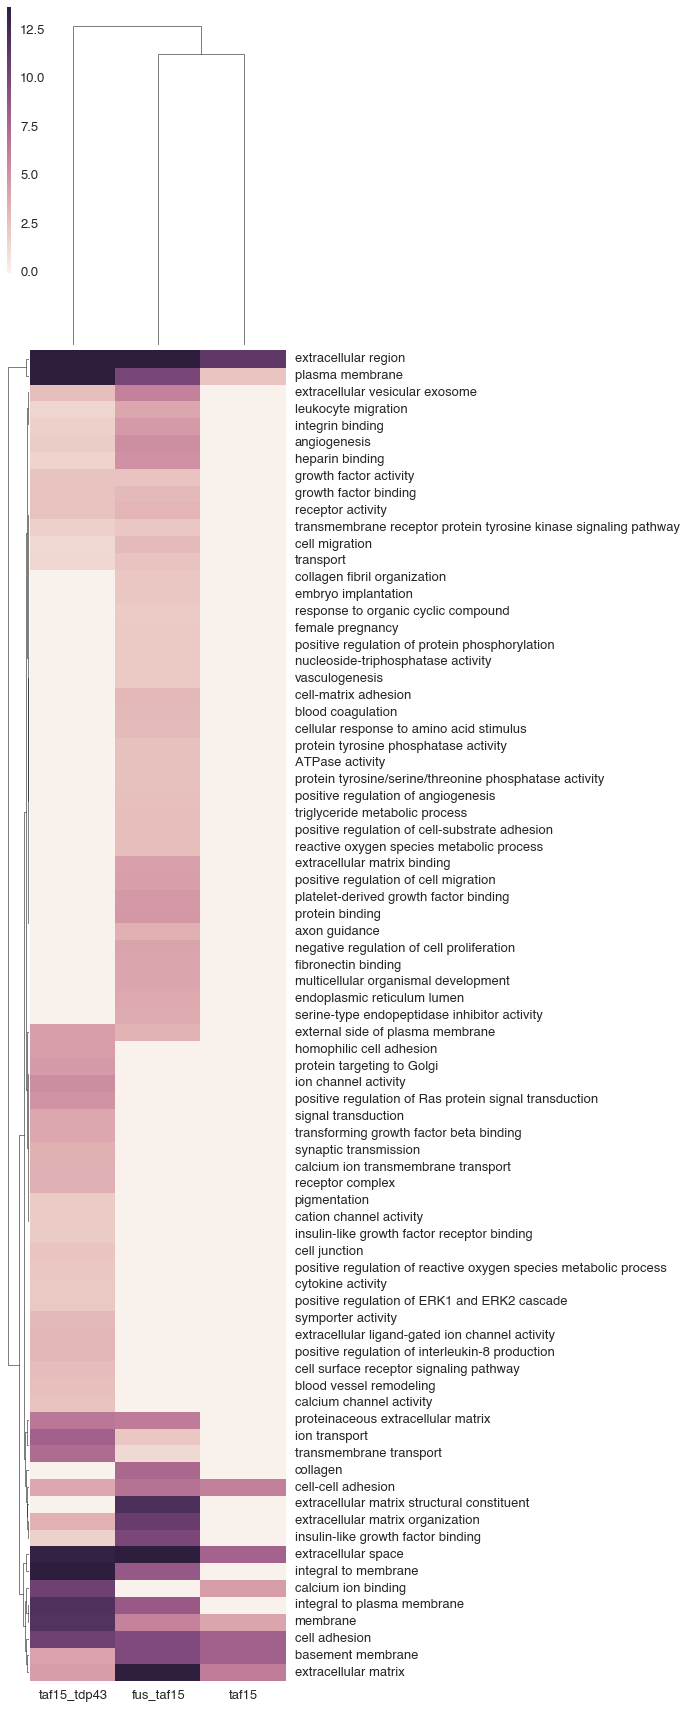

In [398]:
dataviz.plot_go_enrichment(upregulated_go.ix['npc'], filter_value=2, figsize=(5,30))

Figure Legend: All Enriched GO terms for upregulated Genes in NPC knockdowns

#GO Comparison between Overlapping MN and NPC Changing Genes 

In [399]:
overlapping_downregulated_go = {}
overlapping_upregulated_go = {}
for (downregulated_name, downregluated_df), (upregulated_name, upregluated_df) in zip(signifcant_downregulated.groupby(level="rbp"), signifcant_upregulated.groupby(level="rbp")):
    overlapping_downregulated_genes = (downregluated_df.ix['mn'].index.get_level_values(level='gene') & downregluated_df.ix['npc'].index.get_level_values(level='gene'))
    overlapping_upregulated_genes = (upregluated_df.ix['mn'].index.get_level_values(level='gene') & upregluated_df.ix['npc'].index.get_level_values(level='gene'))

    overlapping_downregulated_go[downregulated_name] = hg19go.enrichment(gencode_to_ensembl(overlapping_downregulated_genes),
                                                                         background=(set(expressed_genes['mn']) | set(expressed_genes['npc'])))
    overlapping_upregulated_go[upregulated_name] = hg19go.enrichment(gencode_to_ensembl(overlapping_upregulated_genes),
                                                                     background=(set(expressed_genes['mn']) | set(expressed_genes['npc'])))
    
overlapping_downregulated_go = pd.concat(overlapping_downregulated_go)
overlapping_upregulated_go = pd.concat(overlapping_upregulated_go)

overlapping_downregulated_go = overlapping_downregulated_go[overlapping_downregulated_go['Bonferroni-corrected Hypergeometric p-Value'] < .05].dropna()
overlapping_upregulated_go = overlapping_upregulated_go[overlapping_upregulated_go['Bonferroni-corrected Hypergeometric p-Value'] < .05].dropna()


overlapping_all_go = pd.concat({"downregulated": overlapping_downregulated_go,
                      "upregulated": overlapping_upregulated_go})

overlapping_all_go = overlapping_all_go[overlapping_all_go['Bonferroni-corrected Hypergeometric p-Value'] < .05].dropna()

#Overlapping All GO Terms

In [400]:
#dataviz.plot_go_enrichment(overlapping_all_go, figsize=(5,15))

Figure Legend: GO Enrichment of genes that are changing in both MN and NPC in the same direction. (this is all significant events for all pairs of knockdowns, there aren’t many overlaps and so not many common changes)

#Overlapping upregulated GO Terms

In [401]:
HTML(overlapping_upregulated_go.to_html())

#Double Knockdown Unique Changes Analysis

In [402]:
tdp43_taf15_downregulated = set(signifcant_downregulated.ix['mn', 'taf15_tdp43'].index) - (set(signifcant_downregulated.ix['mn', 'tdp43'].index)  | set(signifcant_downregulated.ix['mn', 'taf15'].index))
tdp43_taf15_upregulated = set(signifcant_upregulated.ix['mn', 'taf15_tdp43'].index) - (set(signifcant_upregulated.ix['mn','tdp43'].index)  | set(signifcant_upregulated.ix['mn', 'taf15'].index))

fus_taf15_downregulated = set(signifcant_downregulated.ix['mn', 'fus_taf15'].index) - (set(signifcant_downregulated.ix['mn','fus'].index)  | set(signifcant_downregulated.ix['mn', 'taf15'].index))
fus_taf15_upregulated = set(signifcant_upregulated.ix['mn', 'fus_taf15'].index) - (set(signifcant_upregulated.ix['mn', 'fus'].index)  | set(signifcant_upregulated.ix['mn', 'taf15'].index))

npc_tdp43_taf15_downregulated = set(signifcant_downregulated.ix['npc', 'taf15_tdp43'].index) - (set(signifcant_downregulated.ix['npc', 'tdp43'].index)  | set(signifcant_downregulated.ix['npc', 'taf15'].index))
npc_tdp43_taf15_upregulated = set(signifcant_upregulated.ix['npc', 'taf15_tdp43'].index) - (set(signifcant_upregulated.ix['npc','tdp43'].index)  | set(signifcant_upregulated.ix['npc', 'taf15'].index))

npc_fus_taf15_downregulated = set(signifcant_downregulated.ix['npc', 'fus_taf15'].index) - (set(signifcant_downregulated.ix['npc','fus'].index)  | set(signifcant_downregulated.ix['npc', 'taf15'].index))
npc_fus_taf15_upregulated = set(signifcant_upregulated.ix['npc', 'fus_taf15'].index) - set(signifcant_upregulated.ix['npc', 'taf15'].index)

In [403]:
unique_changes = pd.concat({
"mn_fus_taf15_downregulated": hg19go.enrichment(gencode_to_ensembl(fus_taf15_downregulated), 
                                              background=expressed_genes['mn']),
"mn_fus_taf15_upregulated": hg19go.enrichment(gencode_to_ensembl(fus_taf15_upregulated), 
                  background=expressed_genes['mn']),
"mn_tdp43_taf15_downregulated": hg19go.enrichment(gencode_to_ensembl(tdp43_taf15_downregulated),
                  background=expressed_genes['mn']),
"mn_tdp43_taf15_upregulated": hg19go.enrichment(gencode_to_ensembl(tdp43_taf15_upregulated), 
                  background=expressed_genes['mn']),
"npc_fus_taf15_downregulated": hg19go.enrichment(gencode_to_ensembl(npc_fus_taf15_downregulated), 
                                              background=expressed_genes['npc']),
"npc_fus_taf15_upregulated": hg19go.enrichment(gencode_to_ensembl(npc_fus_taf15_upregulated), 
                  background=expressed_genes['npc']),
"npc_tdp43_taf15_downregulated": hg19go.enrichment(gencode_to_ensembl(npc_tdp43_taf15_downregulated),
                  background=expressed_genes['npc']),
"npc_tdp43_taf15_upregulated": hg19go.enrichment(gencode_to_ensembl(npc_tdp43_taf15_upregulated), 
                  background=expressed_genes['npc']),})

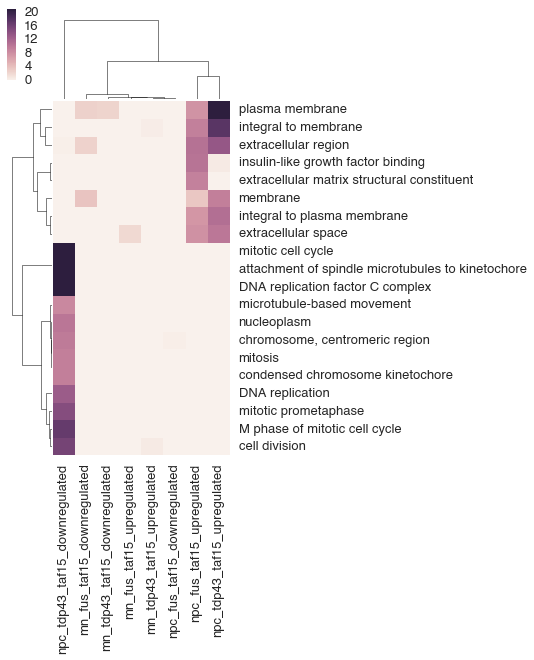

In [404]:
dataviz.plot_go_enrichment(unique_changes, filter_value=1, max_terms=20, figsize=(4, 8))
plt.savefig(os.path.join(img_dir, "double_knockdown_go_enrichment.svg"))
plt.savefig(os.path.join(img_dir, "double_knockdown_go_enrichment.pdf"))

Figure Legend: GO Encirchement for top 20 enriched go terms from genes that are uniquely changing in the double knockdown, but not the single knockdown of TAF15 and either FUS or TDP43

In double knockdowns extra-celleular go terms are also dis-regulated 

In [405]:
unique_changes

GO Term Description  \
                            GO Term Accession                                                      
mn_fus_taf15_downregulated  GO:0005539                                 glycosaminoglycan binding   
                            GO:0005509                                       calcium ion binding   
                            GO:0045596               negative regulation of cell differentiation   
                            GO:0031012                                      extracellular matrix   
                            GO:0001570                                            vasculogenesis   
                            GO:0016020                                                  membrane   
                            GO:0030198                         extracellular matrix organization   
                            GO:0000786                                                nucleosome   
                            GO:0005198                              structural molecule activity   
                            GO:0005080                                  protein kinase C binding   
                            GO:0005886                                           plasma membrane   
                            GO:0005576                                      extracellular region   
                            GO:0007389                             pattern specification process   
                            GO:0045944         positive regulation of transcription from RNA ...   
                            GO:0005515                                           protein binding   
                            GO:0006334                                       nucleosome assembly   
                            GO:0003779                                             actin binding   
                            GO:0007155                                             cell adhesion   
                            GO:0007154                                        cell communication   
                            GO:0030036                           actin cytoskeleton organization   
                            GO:0008152                                         metabolic process   
                            GO:0007417                        central nervous system development   
                            GO:0006955                                           immune response   
                            GO:0008284                 positive regulation of cell proliferation   
                            GO:0016324                                    apical plasma membrane   
                            GO:0042127                          regulation of cell proliferation   
                            GO:0008017                                       microtubule binding   
                            GO:0007420                                         brain development   
                            GO:0006897                                               endocytosis   
                            GO:0004930                       G-protein coupled receptor activity   
...                                                                                          ...   
npc_tdp43_taf15_upregulated GO:2001213                     negative regulation of vasculogenesis   
                            GO:2001214                     positive regulation of vasculogenesis   
                            GO:2001220         negative regulation of G2 phase of mitotic cel...   
                            GO:2001222                            regulation of neuron migration   
                            GO:2001223                   negative regulation of neuron migration   
                            GO:2001224                   positive regulation of neuron migration   
                            GO:2001234         negative regulation of apoptotic signaling pat...   
                            GO:2001235         positive regulation of apoptot

In [406]:
#ax = dataviz.plot_go_enrichment(unique_changes, filter_value=1, figsize=(30,30))


Figure Legend: GO Encirchement for all enriched go terms from genes that are uniquely changing in the double knockdown, but not the single knockdown of TAF15 and either FUS or TDP43

#Overlap all TAF15, TDP43 and FUS Genes and the double konckdowns see what comes out

In [407]:
rbp_overlap_downregulated = hg19go.enrichment(gencode_to_ensembl(signifcant_downregulated.ix['mn', 'tdp43'].index & signifcant_downregulated.ix['mn', 'taf15'].index & signifcant_downregulated.ix['mn', 'fus'].index),
                                             background=(set(expressed_genes['mn']))).dropna()
rbp_overlap_upregulated = hg19go.enrichment(gencode_to_ensembl(signifcant_upregulated.ix['mn', 'tdp43'].index & signifcant_upregulated.ix['mn', 'taf15'].index & signifcant_upregulated.ix['mn', 'fus'].index),
                                           background=(set(expressed_genes['mn']))).dropna()

double_rbp_overlap_downregulated = hg19go.enrichment(gencode_to_ensembl(signifcant_downregulated.ix['mn', 'fus_taf15'].index & signifcant_downregulated.ix['mn', 'taf15'].index & signifcant_downregulated.ix['mn', 'fus'].index),
                                             background=(set(expressed_genes['mn']))).dropna()
double_rbp_overlap_upregulated = hg19go.enrichment(gencode_to_ensembl(signifcant_upregulated.ix['mn', 'fus_taf15'].index & signifcant_upregulated.ix['mn', 'taf15'].index & signifcant_upregulated.ix['mn', 'fus'].index),
                                           background=(set(expressed_genes['mn']))).dropna()

In [408]:
rbp_overlap_downregulated[rbp_overlap_downregulated['Bonferroni-corrected Hypergeometric p-Value'] < .05]

GO Term Description  \
GO Term Accession                                                      
GO:0005576                                      extracellular region   
GO:0005615                                       extracellular space   
GO:0005581                                                  collagen   
GO:0031012                                      extracellular matrix   
GO:0005125                                         cytokine activity   
GO:0030199                              collagen fibril organization   
GO:0001501                               skeletal system development   
GO:0006936                                        muscle contraction   
GO:0005604                                         basement membrane   
GO:0005201               extracellular matrix structural constituent   
GO:0030198                         extracellular matrix organization   
GO:0007267                                       cell-cell signaling   
GO:0006954                                     inflammatory response   
GO:0005102                                          receptor binding   
GO:0007507                                         heart development   
GO:0042060                                             wound healing   
GO:0008083                                    growth factor activity   
GO:0001666                                       response to hypoxia   
GO:0005788                               endoplasmic reticulum lumen   
GO:0032496                            response to lipopolysaccharide   
GO:0003779                                             actin binding   
GO:0006955                                           immune response   
GO:0005578                        proteinaceous extracellular matrix   
GO:0007166                   cell surface receptor signaling pathway   
GO:0007179         transforming growth factor beta receptor signa...   
GO:0007186              G-protein coupled receptor signaling pathway   
GO:0007411                                             axon guidance   
GO:0007155                                             cell adhesion   
GO:0001525                                              angiogenesis   
GO:0045944         positive regulation of transcription from RNA ...   
GO:0042493                                          response to drug   

                   Bonferroni-corrected Hypergeometric p-Value  \
GO Term Accession                                                
GO:0005576                                        2.055916e-18   
GO:0005615                                        1.919191e-14   
GO:0005581                                        5.637564e-12   
GO:0031012                                        1.131472e-09   
GO:0005125                                        5.116866e-09   
GO:0030199                                        2.528224e-08   
GO:0001501                                        2.645987e-08   
GO:0006936                                        3.536656e-08   
GO:0005604                                        7.290098e-08   
GO:0005201                                        1.031769e-07   
GO:0030198                                        9.627571e-07   
GO:0007267                                        2.293986e-06   
GO:0006954                                        8.024465e-06   
GO:0005102                                        1.788805e-05   
GO:0007507                                        2.418294e-05   
GO:0042060                                        3.536997e-05   
GO:0008083                                        1.348880e-04   
GO:0001666                                        1.515109e-04   
GO:0005788                                        1.603863e-04   
GO:0032496                                        2.068948e-04   
GO:0003779                                        8.033077e-04   
GO:0006955                                        9.441130e-04   
GO:0005578                                        1.000807e-03   
GO:0007166            

In [409]:
(255 + 72) / ((96  + 255 + 72 + 4) * 1.0)

0.765807962529274

In [410]:
(19 + 72) / ((4  + 19 + 72 + 11) * 1.0)

0.8584905660377359

In [411]:
832 + 69

901

In [412]:
double_rbp_overlap_downregulated[double_rbp_overlap_downregulated['Bonferroni-corrected Hypergeometric p-Value'] < .05]

GO Term Description  \
GO Term Accession                                                      
GO:0005576                                      extracellular region   
GO:0005615                                       extracellular space   
GO:0005581                                                  collagen   
GO:0006936                                        muscle contraction   
GO:0031012                                      extracellular matrix   
GO:0005125                                         cytokine activity   
GO:0030199                              collagen fibril organization   
GO:0001501                               skeletal system development   
GO:0005201               extracellular matrix structural constituent   
GO:0005102                                          receptor binding   
GO:0006954                                     inflammatory response   
GO:0030198                         extracellular matrix organization   
GO:0006955                                           immune response   
GO:0007267                                       cell-cell signaling   
GO:0005604                                         basement membrane   
GO:0051384                       response to glucocorticoid stimulus   
GO:0001666                                       response to hypoxia   
GO:0043434                      response to peptide hormone stimulus   
GO:0005788                               endoplasmic reticulum lumen   
GO:0007507                                         heart development   
GO:0042060                                             wound healing   
GO:0007166                   cell surface receptor signaling pathway   
GO:0003779                                             actin binding   
GO:0008083                                    growth factor activity   
GO:0032496                            response to lipopolysaccharide   
GO:0005578                        proteinaceous extracellular matrix   
GO:0005886                                           plasma membrane   
GO:0043123         positive regulation of I-kappaB kinase/NF-kapp...   
GO:0007179         transforming growth factor beta receptor signa...   
GO:0007186              G-protein coupled receptor signaling pathway   
GO:0042493                                          response to drug   
GO:0007411                                             axon guidance   
GO:0019048                                    virus-host interaction   
GO:0001525                                              angiogenesis   
GO:0005515                                           protein binding   
GO:0005509                                       calcium ion binding   

                   Bonferroni-corrected Hypergeometric p-Value  \
GO Term Accession                                                
GO:0005576                                        2.318086e-16   
GO:0005615                                        2.549853e-14   
GO:0005581                                        2.686223e-11   
GO:0006936                                        3.026535e-09   
GO:0031012                                        7.461400e-09   
GO:0005125                                        2.013167e-08   
GO:0030199                                        8.349050e-08   
GO:0001501                                        1.223304e-07   
GO:0005201                                        3.394629e-07   
GO:0005102                                        3.997078e-07   
GO:0006954                                        1.552708e-06   
GO:0030198                                        3.695767e-06   
GO:0006955                                        6.837858e-06   
GO:0007267                                        8.750685e-06   
GO:0005604                                        9.755018e-06   
GO:0051384                                        2.102811e-05   
GO:0001666                                        2.833177e-05   
GO:0043434                                        2.884423

In [413]:
overlapping_downregulated_go = {}
overlapping_upregulated_go = {}
for (downregulated_name, downregluated_df), (upregulated_name, upregluated_df) in zip(signifcant_downregulated.groupby(level="rbp"), signifcant_upregulated.groupby(level="rbp")):
    overlapping_downregulated_genes = (downregluated_df.ix['mn'].index.get_level_values(level='gene') & downregluated_df.ix['npc'].index.get_level_values(level='gene'))
    overlapping_upregulated_genes = (upregluated_df.ix['mn'].index.get_level_values(level='gene') & upregluated_df.ix['npc'].index.get_level_values(level='gene'))

    overlapping_downregulated_go[downregulated_name] = hg19go.enrichment(gencode_to_ensembl(overlapping_downregulated_genes),
                                                                         background=(set(expressed_genes['mn']) | set(expressed_genes['npc'])))
    overlapping_upregulated_go[upregulated_name] = hg19go.enrichment(gencode_to_ensembl(overlapping_upregulated_genes),
                                                                     background=(set(expressed_genes['mn']) | set(expressed_genes['npc'])))
    
overlapping_downregulated_go = pd.concat(overlapping_downregulated_go)
overlapping_upregulated_go = pd.concat(overlapping_upregulated_go)

overlapping_downregulated_go = overlapping_downregulated_go[overlapping_downregulated_go['Bonferroni-corrected Hypergeometric p-Value'] < .05].dropna()
overlapping_upregulated_go = overlapping_upregulated_go[overlapping_upregulated_go['Bonferroni-corrected Hypergeometric p-Value'] < .05].dropna()


overlapping_all_go = pd.concat({"downregulated": overlapping_downregulated_go,
                      "upregulated": overlapping_upregulated_go})

overlapping_all_go = overlapping_all_go[overlapping_all_go['Bonferroni-corrected Hypergeometric p-Value'] < .05].dropna()

In [414]:
# mt_sig_go_terms = unique_changes.ix['fus_taf15_upregulated'].ix[[
#                                               #'GO:0042773',
#                                               #'GO:0016266', 
#                                               #'GO:0022904', 
#                                               #'GO:0008137',
#                                               #'GO:0005747',
#                                               #'GO:0005743',
#                                               #'GO:0006120'
#                                               ]]

# mt_sig_gene_names = set([])
# for item in mt_sig_go_terms['Gene symbols in List'].values:
#     mt_sig_gene_names |= set(item.split(","))

# mt_sig_gene_ids = set([])
# for item in mt_sig_go_terms['Ensembl Gene IDs in List'].values:
#     mt_sig_gene_ids |= set(item.split(","))

#Are the mitochonidral Genes Actually Changing

In [415]:
#Count based analysis
# mito_counts = mn_counts.ix[all_counts.index.isin(mito_genes.values())].copy()
# mito_counts = mito_counts.drop(['Chr', 'Strand', 'Start', 'End', 'Length'], axis=1)
# counts = np.log2(mito_counts.mul(1 / mito_counts.Scrm_1, axis=0))
# counts.index = gencode_to_ensembl(counts.index)
# counts  = counts.ix[mt_sig_gene_ids]

# num_samples = len(counts.columns)
# colors = sns.color_palette("Set2", num_samples)

# with dataviz.Figure(os.path.join(img_dir, "gene_expression.svg"), figsize=(30, 10)) as fig:
#     ax = fig.add_subplot(2,2,1)
#     width = .35
#     ind = np.arange(len(counts.FUS_TAF15_shRNA_1)) * ((num_samples + 10) * width)
    
#     for x, (color, col) in enumerate(zip(colors, counts.columns)):
#         ax.bar(ind + (width * x), counts[col], width, label=col, color=color)

#     ax.set_xticks(np.arange(len(counts.index)) * ((num_samples + 10) * width))
#     ax.set_xticklabels(counts.index, rotation=90)
#     ax.legend(loc=0)

In [416]:
mm_rpkm = rpkm.ix['MN']
log2_normalized = np.log2(mn_rpkm / mn_rpkm.ix['MN', 'Scrm_1', 'Scrm', 1])

In [417]:
compared = pd.concat({"fus_taf15": pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/fus_taf15.csv", index_col=0),
    "fus_taf15_only": pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/fus_taf15_only.csv", index_col=0)},
          names=['rbp', 'gene'])

series_1 = compared.irow(0)
series_2 = compared.irow(1)

print scipy.stats.linregress(series_1, series_2)
significant_compared = compared[(compared.padj <= .05) & (abs(compared.log2FoldChange) > np.log2(1.5))]

LinregressResult(slope=111.78742113811309, intercept=-53.659747037016245, rvalue=0.99548274730091757, pvalue=3.0562269358573433e-05, stderr=5.330775409829779)


/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


In [418]:
significant_compared.groupby(level="rbp").count()

baseMean  log2FoldChange  lfcSE  stat  pvalue  padj
rbp                                                                
fus_taf15            849             849    849   849     849   849
fus_taf15_only       554             554    554   554     554   554

In [419]:
# mt_result = knockdowns.ix[[gene.split(".")[0] in mt_sig_gene_ids for gene in knockdowns.index.get_level_values(level="gene")]]
# mt_result.log2FoldChange.unstack()

In [420]:
# mito_genes = {name: gene_id for name, gene_id in name_to_gene_id.items() if name.startswith("MT-")}

In [421]:
# mt_rpkm = rpkm[mito_genes.values()]
# mt_rpkm = mt_rpkm.rename(columns=gene_id_to_name)

In [422]:
# interesting_data = pd.concat([mt_rpkm.xs("FUS_TAF15", level="knockdown"), mt_rpkm.xs("Scrm", level="knockdown")])
# interesting_data += 1
# sns.clustermap(np.log10(interesting_data.ix['MN']), figsize=(15,2.0))
# plt.savefig(os.path.join(img_dir, "double_knockdown_rpkm.svg"))
# plt.savefig(os.path.join(img_dir, "double_knockdown_rpkm.pdf"))

In [423]:
# interesting_data = pd.concat([mt_rpkm.xs("FUS_TAF15", level="knockdown"), mt_rpkm.xs("Scrm", level="knockdown")])
# interesting_data = interesting_data.ix['MN'][list(mt_sig_gene_names)] 
# sns.clustermap(interesting_data, figsize=(5, 2.5))
# plt.savefig(os.path.join(img_dir, "significantly_changing_mt_genes.svg"))

#Raw RPKMs

In [424]:
compared.index = pd.MultiIndex.from_tuples([(rbp, gene.split(".")[0]) for rbp, gene in compared.index], names=['rbp', 'gene'])


In [425]:
significant_compared  = compared[(compared.padj <= .05) & (abs(compared.log2FoldChange) > np.log2(1.5))]

In [426]:
# interesting_data = mt_rpkm
# interesting_data = interesting_data.ix['MN'][list(mt_sig_gene_names)] 
# interesting_data = interesting_data.T

# num_samples = len(interesting_data.columns)
# colors = sns.color_palette("Set2", num_samples)
# with dataviz.Figure(os.path.join(img_dir, "gene_expression_rpkm.svg"), figsize=(30, 10)) as fig:
#     ax = fig.add_subplot(2,2,1)
#     width = .35
#     ind = np.arange(len(interesting_data)) * ((num_samples + 10) * width)
    
#     for x, (color, col) in enumerate(zip(colors, interesting_data.columns)):
#         ax.bar(ind + (width * x), interesting_data[col], width, label=col, color=color)

#     ax.set_xticks(np.arange(len(interesting_data.index)) * ((num_samples + 10) * width))
#     ax.set_xticklabels(interesting_data.index, rotation=90)
#     ax.legend(loc=0)
#     ax.set_ylim(0, 50)

#Log2 Fold Change

In [427]:
# scrm_fold = interesting_data.T
# scrm_fold = scrm_fold.div(scrm_fold.ix[["Scrm_1", "Scrm", "1"]].irow(0), axis=1).T
# scrm_fold = np.log2(scrm_fold)

# num_samples = len(scrm_fold.columns)
# colors = sns.color_palette("Set2", num_samples)
# with dataviz.Figure(os.path.join(img_dir, "gene_expression_rpkm.svg"), figsize=(30, 10)) as fig:
#     ax = fig.add_subplot(2,2,1)
#     width = .35
#     ind = np.arange(len(scrm_fold)) * ((num_samples + 10) * width)
    
#     for x, (color, col) in enumerate(zip(colors, scrm_fold.columns)):
#         ax.bar(ind + (width * x), scrm_fold[col], width, label=col, color=color)

#     ax.set_xticks(np.arange(len(scrm_fold.index)) * ((num_samples + 10) * width))
#     ax.set_xticklabels(scrm_fold.index, rotation=90)
#     ax.legend(loc=0)

#Overlaps between iPSC MN data and any of our other datasets

In [428]:
gene_id_to_type_ens = {gene.split(".")[0]: gene_type for gene, gene_type in gene_id_to_type.items()}

In [429]:
mn_expressed_genes = [gene for gene in expressed_genes['mn'] if gene_id_to_type_ens[gene] == 'protein_coding']

In [430]:
len(mn_expressed_genes)

11607

#GO Analysis of up and downregulated ips genes

In [431]:
#This takes a few minutes...
ips_downregulated_go = {}
for name, df in ips_signifcant_downregulated.groupby(level=["rbp", "mutation"]):
    cell_type = name[0]
    ips_downregulated_go[name] = hg19go.enrichment(gencode_to_ensembl(df.index.get_level_values(level="gene")),
                                               background=expressed_genes['mn'])
    
ips_downregulated_go = pd.concat(ips_downregulated_go, names=['cell_type', 'rbp', 'go_term_id'])
ips_downregulated_go = ips_downregulated_go[ips_downregulated_go['Bonferroni-corrected Hypergeometric p-Value'] < .05]

ips_upregulated_go = {}
for name, df in ips_signifcant_upregulated.groupby(level=["rbp", "mutation"]):
    cell_type = name[0]
    ips_upregulated_go[name] = hg19go.enrichment(gencode_to_ensembl(df.index.get_level_values(level="gene")),
                                             background=expressed_genes['mn'])
    
ips_upregulated_go = pd.concat(ips_upregulated_go,  names=["rbp", "mutation", 'go_term_id'])
ips_upregulated_go = ips_upregulated_go[ips_upregulated_go['Bonferroni-corrected Hypergeometric p-Value'] < .05]

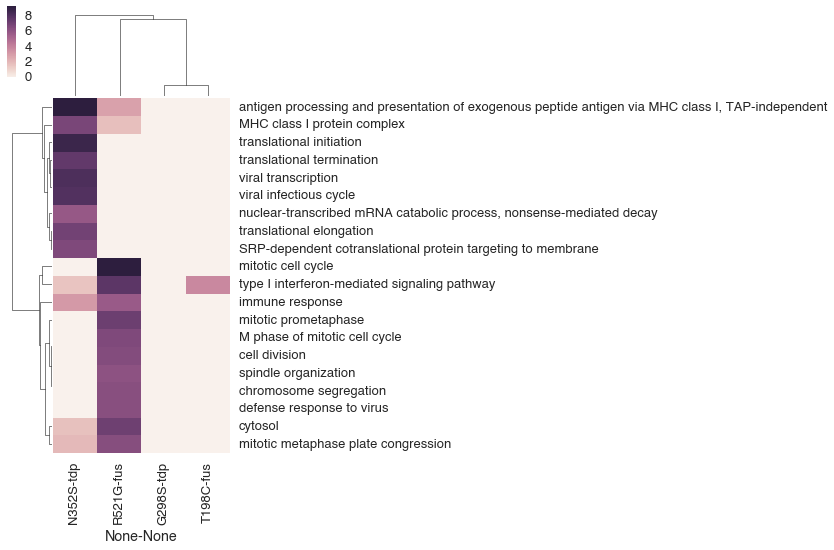

In [432]:
dataviz.plot_go_enrichment(ips_downregulated_go, filter_value=1, max_terms=20, figsize=(4, 8))

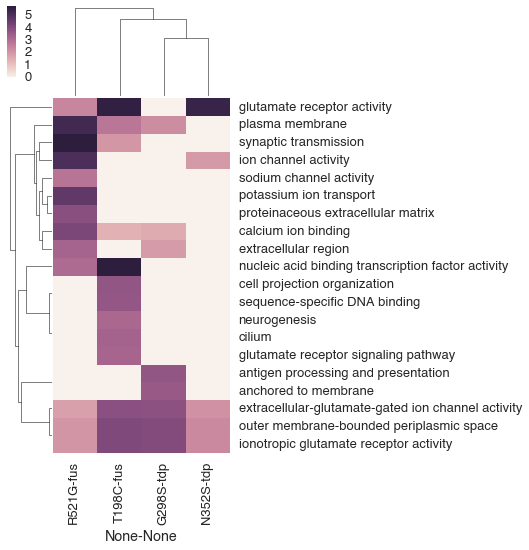

In [433]:
dataviz.plot_go_enrichment(ips_upregulated_go, filter_value=1, max_terms=20, figsize=(4, 8))

In [434]:
HTML(ips_downregulated_go.to_html())

In [435]:
HTML(ips_upregulated_go.to_html())

In [436]:
for (cell_type, rbp), df in ips_signifcant_downregulated.groupby(level=["rbp", "mutation"]):
    result[rbp, cell_type, "downregulated"] = Counter(gencode_to_ensembl(df.index.get_level_values(level="gene")))

for (cell_type, rbp), df in ips_signifcant_upregulated.groupby(level=["rbp", "mutation"]):
    result[rbp, cell_type, "upregulated"] = Counter(gencode_to_ensembl(df.index.get_level_values(level="gene")))

In [437]:
coding_ips_signifcant_downregulated = ips_signifcant_downregulated[[gene_id_to_type[gene] == 'protein_coding' for gene in ips_signifcant_downregulated.index.get_level_values(level="gene")]]
coding_signifcant_downregulated = signifcant_downregulated[[gene_id_to_type[gene] == 'protein_coding' for gene in signifcant_downregulated.index.get_level_values(level="gene")]]
coding_ips_signifcant_upregulated = ips_signifcant_upregulated[[gene_id_to_type[gene] == 'protein_coding' for gene in ips_signifcant_upregulated.index.get_level_values(level="gene")]]
coding_signifcant_upregulated = signifcant_upregulated[[gene_id_to_type[gene] == 'protein_coding' for gene in signifcant_upregulated.index.get_level_values(level="gene")]]

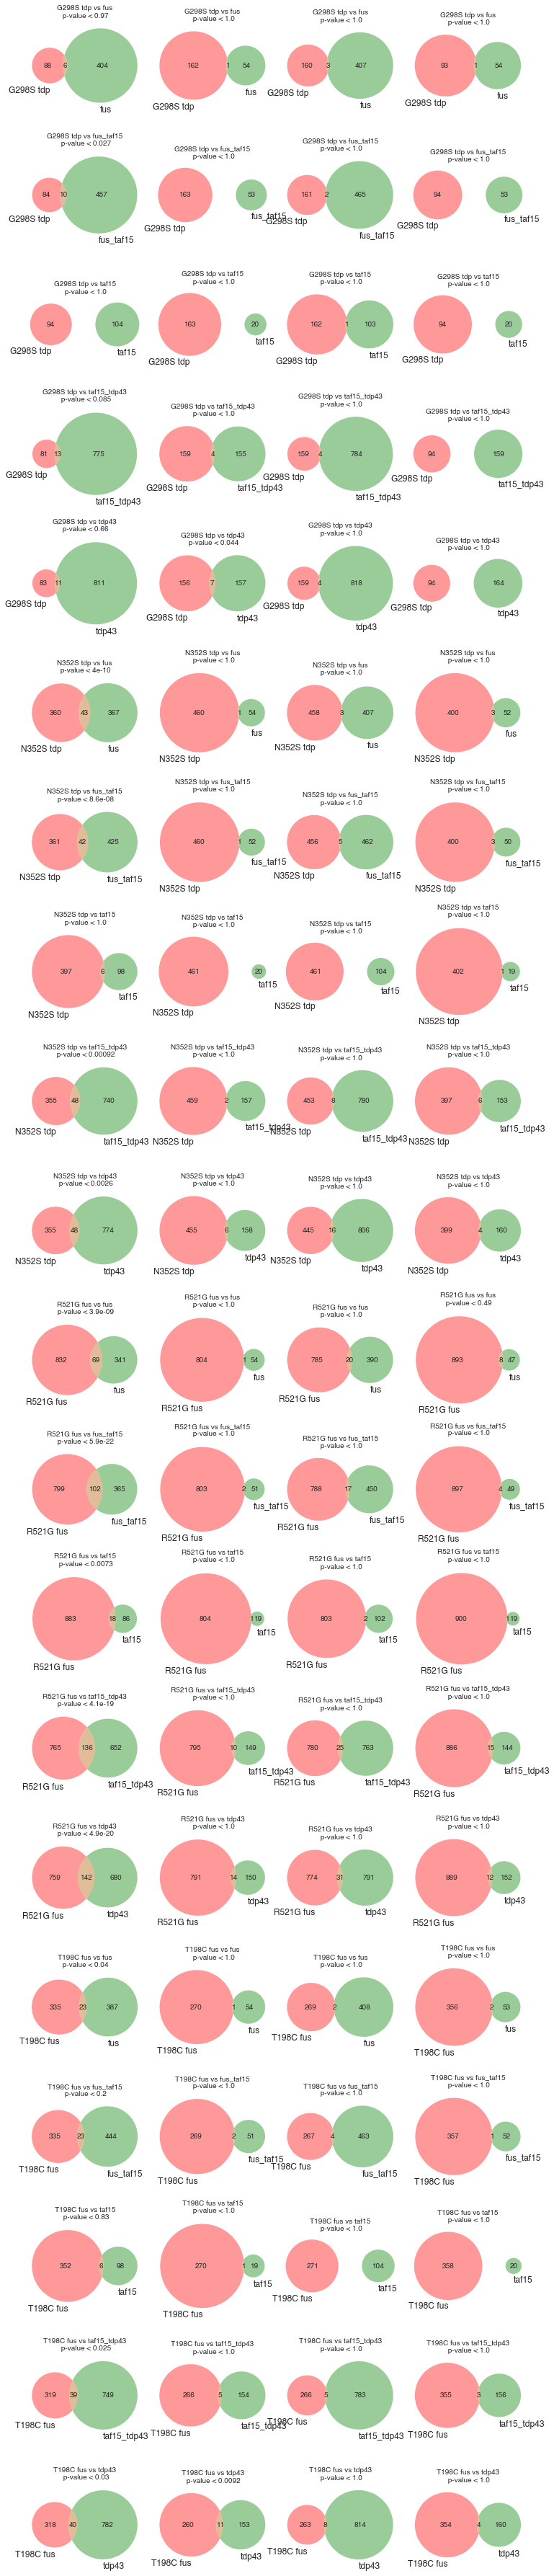

In [438]:
count = 0
row_num = 20
col_num = 4
gs = gridspec.GridSpec(row_num, col_num)
with dataviz.Figure(os.path.join(img_dir, "up_and_down_regulation_overlap_taf15_tdp43.svg"), figsize=(col_num * 2.5, row_num * 2.5)) as fig:
    for (ips_downregulated_name, ips_downregulated_df), (ips_upregulated_name, ips_upregulated_df) in zip(coding_ips_signifcant_downregulated.groupby(level=['rbp', 'mutation']), 
                                                                                                          coding_ips_signifcant_upregulated.groupby(level=['rbp', 'mutation'])):
        for (cell_downregulated_name, cell_downregulated_df), (cell_upregulated_name, cell_upregulated_df) in zip(coding_signifcant_downregulated.ix['mn'].groupby(level=["rbp"]),
                                                                                                                  coding_signifcant_upregulated.ix['mn'].groupby(level=["rbp"])):


            ips_down = set(ips_downregulated_df.ix[ips_downregulated_name].index.get_level_values(level='gene'))
            cell_down = set(cell_downregulated_df.ix[cell_downregulated_name].index.get_level_values(level='gene'))

            ips_up = set(ips_upregulated_df.ix[ips_upregulated_name].index.get_level_values(level='gene'))
            cell_up = set(cell_upregulated_df.ix[cell_upregulated_name].index.get_level_values(level='gene'))


            p_value_down = min(hypergeom.sf(len(ips_down & cell_down), len(mn_expressed_genes), len(ips_down), len(cell_down)) * 20, 1.0)
            p_value_up = min(hypergeom.sf(len(ips_up & cell_up), len(mn_expressed_genes), len(ips_up), len(cell_up)) * 20, 1.0)

            p_value_down_up = min(hypergeom.sf(len(ips_down & cell_up), len(mn_expressed_genes), len(ips_down), len(cell_up)) * 20, 1.0)
            p_value_up_down = min(hypergeom.sf(len(ips_up & cell_down), len(mn_expressed_genes), len(ips_up), len(cell_down)) * 20, 1.0)

            ax = fig.add_subplot(gs[count, 0])
            venn2([ips_down,
                   cell_down,
                   ], set_labels=(" ".join(ips_downregulated_name), cell_downregulated_name), ax =ax )
            ax.set_title("{} vs {}\n p-value < {:.2}".format(" ".join(ips_downregulated_name), 
                                                             cell_downregulated_name,
                                                             p_value_down), fontsize=10)

            ax = fig.add_subplot(gs[count, 1])
            venn2([ips_up,
                   cell_up,
                   ], set_labels=(" ".join(ips_upregulated_name), cell_upregulated_name), ax =ax )
            ax.set_title("{} vs {}\n p-value < {:.2}".format(" ".join(ips_upregulated_name), 
                                                             cell_upregulated_name,
                                                             p_value_up), fontsize=10)
            
            ax = fig.add_subplot(gs[count, 2])
            venn2([ips_up,
                   cell_down,
                   ], set_labels=(" ".join(ips_upregulated_name), cell_upregulated_name), ax =ax )
            ax.set_title("{} vs {}\n p-value < {:.2}".format(" ".join(ips_upregulated_name), 
                                                             cell_upregulated_name,
                                                             p_value_up_down), fontsize=10)
            
            ax = fig.add_subplot(gs[count, 3])
            venn2([ips_down,
                   cell_up,
                   ], set_labels=(" ".join(ips_upregulated_name), cell_upregulated_name), ax =ax )
            ax.set_title("{} vs {}\n p-value < {:.2}".format(" ".join(ips_upregulated_name), 
                                                             cell_upregulated_name,
                                                             p_value_down_up), fontsize=10)
            
            count += 1


In [439]:
coding_ips_signifcant_downregulated.groupby(level=["rbp", 'mutation']).count()

baseMean  log2FoldChange  lfcSE  stat  pvalue  padj  \
rbp   mutation                                                        
G298S tdp             94              94     94    94      94    94   
N352S tdp            403             403    403   403     403   403   
R521G fus            901             901    901   901     901   901   
T198C fus            358             358    358   358     358   358   

                gene_names  
rbp   mutation              
G298S tdp               94  
N352S tdp              403  
R521G fus              901  
T198C fus              358

In [440]:
len(coding_signifcant_downregulated.ix['mn', 'taf15'])

104

In [441]:
len(coding_signifcant_upregulated.ix['mn', 'taf15'])

20

In [442]:
#the difference in numbers ie explained by coding vs non-coding

901 805 410 55
901 805 467 53
901 805 104 20
901 805 788 159
901 805 822 164


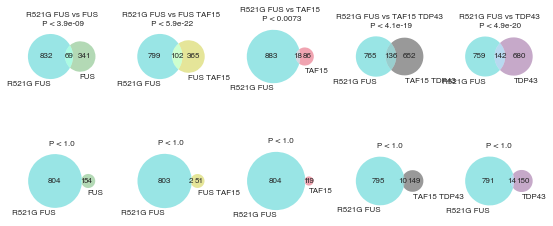

In [443]:
count = 0
row_num = 2
col_num = 5


with dataviz.Figure(os.path.join(img_dir, "r521g_mn_venns.svg"), figsize=(col_num * 1.5, row_num * 2.0)) as fig:
    gs = gridspec.GridSpec(row_num, col_num)
    for (ips_downregulated_name, ips_downregulated_df), (ips_upregulated_name, ips_upregulated_df) in zip(coding_ips_signifcant_downregulated.groupby(level=['rbp', 'mutation']), 
                                                                                                          coding_ips_signifcant_upregulated.groupby(level=['rbp', 'mutation'])):
        for (cell_downregulated_name, cell_downregulated_df), (cell_upregulated_name, cell_upregulated_df) in zip(coding_signifcant_downregulated.ix['mn'].groupby(level=["rbp"]),
                                                                                                                  coding_signifcant_upregulated.ix['mn'].groupby(level=["rbp"])):
            if ips_downregulated_name[0] not in ['R521G']:
                continue
            
            ips_down = set(ips_downregulated_df.ix[ips_downregulated_name].index.get_level_values(level='gene'))
            cell_down = set(cell_downregulated_df.ix[cell_downregulated_name].index.get_level_values(level='gene'))

            ips_up = set(ips_upregulated_df.ix[ips_upregulated_name].index.get_level_values(level='gene'))
            cell_up = set(cell_upregulated_df.ix[cell_upregulated_name].index.get_level_values(level='gene'))
            

            p_value_down = min(hypergeom.sf(len(ips_down & cell_down), len(mn_expressed_genes), len(ips_down), len(cell_down)) * 20, 1.0)
            p_value_up = min(hypergeom.sf(len(ips_up & cell_up), len(mn_expressed_genes), len(ips_up), len(cell_up)) * 20, 1.0)
                        
            ax = fig.add_subplot(gs[0, count])
            venn = venn2([ips_down, cell_down,], 
                  set_labels=(" ".join(ips_downregulated_name).upper(), rbp_names[cell_downregulated_name]),
                  set_colors=(rbp_colors[ips_downregulated_name[0]], rbp_colors[cell_downregulated_name]), 
                  ax=ax)

            ax.set_title("{} vs {}\n P < {:.2}".format(" ".join(ips_downregulated_name).upper(), 
                                                             rbp_names[cell_downregulated_name],
                                                             p_value_down), fontsize=8)
            
            [label.set_fontsize(8) for label in venn.subset_labels if label is not None]
            [label.set_fontsize(8) for label in venn.set_labels]

            
                
            ax = fig.add_subplot(gs[1, count])
            venn = venn2([ips_up, cell_up,], 
                  set_labels=(" ".join(ips_upregulated_name).upper(), rbp_names[cell_upregulated_name]),
                  set_colors=(rbp_colors[ips_downregulated_name[0]], rbp_colors[cell_downregulated_name]), 

                  ax =ax )
            #{} vs {}\n
            ax.set_title("P < {:.2}".format(#" ".join(ips_upregulated_name).upper(), 
                                             #                rbp_names[cell_upregulated_name],
                                                             p_value_up), fontsize=8)
            
            [label.set_fontsize(8) for label in venn.subset_labels if label is not None]
            [label.set_fontsize(8) for label in venn.set_labels]
            count += 1
            print len(ips_down), len(ips_up), len(cell_down), len(cell_up)


#Get GO terms for overlapping Genes

In [444]:
result = {}
for (ips_downregulated_name, ips_downregulated_df), (ips_upregulated_name, ips_upregulated_df) in zip(coding_ips_signifcant_downregulated.groupby(level=['rbp', 'mutation']), 
                                                                                                      coding_ips_signifcant_upregulated.groupby(level=['rbp', 'mutation'])):
    for (cell_downregulated_name, cell_downregulated_df), (cell_upregulated_name, cell_upregulated_df) in zip(coding_signifcant_downregulated.ix['mn'].groupby(level=["rbp"]),
                                                                                                              coding_signifcant_upregulated.ix['mn'].groupby(level=["rbp"])):
        if ips_downregulated_name[0] not in ['R521G']:
            continue

        ips_down = set(ips_downregulated_df.ix[ips_downregulated_name].index.get_level_values(level='gene'))
        cell_down = set(cell_downregulated_df.ix[cell_downregulated_name].index.get_level_values(level='gene'))

        ips_up = set(ips_upregulated_df.ix[ips_upregulated_name].index.get_level_values(level='gene'))
        cell_up = set(cell_upregulated_df.ix[cell_upregulated_name].index.get_level_values(level='gene'))

        merged_down = ips_down & cell_down 
        merged_up = ips_up & cell_up 
        result[(ips_downregulated_name[0], cell_downregulated_name, "down")] = hg19go.enrichment(gencode_to_ensembl(merged_down), background=expressed_genes['mn'])
        result[(ips_upregulated_name[0], cell_upregulated_name, "up")] = hg19go.enrichment(gencode_to_ensembl(merged_up), background=expressed_genes['mn'])
result = pd.concat(result, names=['mutation', 'kd', 'direction'])
result = result[result['Bonferroni-corrected Hypergeometric p-Value'] < .05]

In [445]:
#MAKE THIS A TABLE
HTML(result.xs("down", level='direction').to_html())

#Go Terms for genes uniquely expressed in mutant

In [446]:
unique_genes_result = {}
for (ips_downregulated_name, ips_downregulated_df), (ips_upregulated_name, ips_upregulated_df) in zip(coding_ips_signifcant_downregulated.groupby(level=['rbp', 'mutation']), 
                                                                                                      coding_ips_signifcant_upregulated.groupby(level=['rbp', 'mutation'])):
    for (cell_downregulated_name, cell_downregulated_df), (cell_upregulated_name, cell_upregulated_df) in zip(coding_signifcant_downregulated.ix['mn'].groupby(level=["rbp"]),
                                                                                                              coding_signifcant_upregulated.ix['mn'].groupby(level=["rbp"])):
        if ips_downregulated_name[0] not in ['R521G']:
            continue

        ips_down = set(ips_downregulated_df.ix[ips_downregulated_name].index.get_level_values(level='gene'))
        cell_down = set(cell_downregulated_df.ix[cell_downregulated_name].index.get_level_values(level='gene'))

        ips_up = set(ips_upregulated_df.ix[ips_upregulated_name].index.get_level_values(level='gene'))
        cell_up = set(cell_upregulated_df.ix[cell_upregulated_name].index.get_level_values(level='gene'))

        merged_down = ips_down - cell_down 
        merged_up = ips_up - cell_up 
        print ips_downregulated_name[0], cell_downregulated_name, len(merged_down), len(merged_up)
         
        unique_genes_result[(ips_downregulated_name[0], cell_downregulated_name, "down")] = hg19go.enrichment(gencode_to_ensembl(merged_down), background=expressed_genes['mn'])
        unique_genes_result[(ips_upregulated_name[0], cell_upregulated_name, "up")] = hg19go.enrichment(gencode_to_ensembl(merged_up), background=expressed_genes['mn'])
unique_genes_result = pd.concat(unique_genes_result, names=['mutation', 'kd', 'direction'])
unique_genes_result = unique_genes_result[unique_genes_result['Bonferroni-corrected Hypergeometric p-Value'] < .05]

R521G fus 832 804
R521G fus_taf15 799 803
R521G taf15 883 804
R521G taf15_tdp43 765 795
R521G tdp43 759 791


In [447]:
#MAKE THIS A TABLE
HTML(unique_genes_result.ix['R521G'].xs("down", level="direction").to_html())

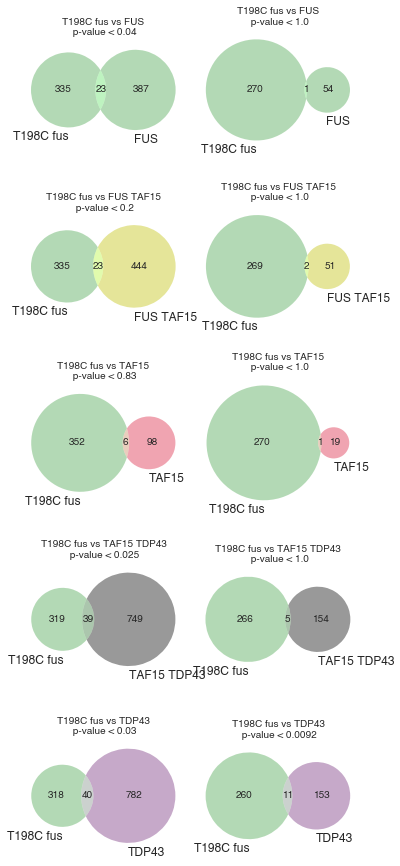

In [448]:
count = 0
row_num = 5
col_num = 2


with dataviz.Figure(os.path.join(img_dir, "t192c_venns.svg"), figsize=(col_num * 2.5, row_num * 2.5)) as fig:
    for (ips_downregulated_name, ips_downregulated_df), (ips_upregulated_name, ips_upregulated_df) in zip(coding_ips_signifcant_downregulated.groupby(level=['rbp', 'mutation']), 
                                                                                                          coding_ips_signifcant_upregulated.groupby(level=['rbp', 'mutation'])):
        for (cell_downregulated_name, cell_downregulated_df), (cell_upregulated_name, cell_upregulated_df) in zip(coding_signifcant_downregulated.ix['mn'].groupby(level=["rbp"]),
                                                                                                                  coding_signifcant_upregulated.ix['mn'].groupby(level=["rbp"])):
            if ips_downregulated_name[0] not in ['T198C']:
                continue

            count += 1

            ips_down = set(ips_downregulated_df.ix[ips_downregulated_name].index.get_level_values(level='gene'))
            cell_down = set(cell_downregulated_df.ix[cell_downregulated_name].index.get_level_values(level='gene'))

            ips_up = set(ips_upregulated_df.ix[ips_upregulated_name].index.get_level_values(level='gene'))
            cell_up = set(cell_upregulated_df.ix[cell_upregulated_name].index.get_level_values(level='gene'))


            p_value_down = min(hypergeom.sf(len(ips_down & cell_down), len(mn_expressed_genes), len(ips_down), len(cell_down)) * 20, 1.0)
            p_value_up = min(hypergeom.sf(len(ips_up & cell_up), len(mn_expressed_genes), len(ips_up), len(cell_up)) * 20, 1.0)

            ax = fig.add_subplot(row_num,col_num,count)
            venn2([ips_down, cell_down,], 
                  set_labels=(" ".join(ips_downregulated_name), rbp_names[cell_downregulated_name]),
                  set_colors=(rbp_colors[ips_downregulated_name[1]], rbp_colors[cell_downregulated_name]), 
                  ax=ax)

            ax.set_title("{} vs {}\n p-value < {:.2}".format(" ".join(ips_downregulated_name), 
                                                             rbp_names[cell_downregulated_name],
                                                             p_value_down), fontsize=10)

            count +=1
            ax = fig.add_subplot(row_num,col_num,count)
            venn2([ips_up, cell_up,], 
                  set_labels=(" ".join(ips_upregulated_name), rbp_names[cell_upregulated_name]),
                  set_colors=(rbp_colors[ips_downregulated_name[1]], rbp_colors[cell_downregulated_name]), 

                  ax =ax )
            ax.set_title("{} vs {}\n p-value < {:.2}".format(" ".join(ips_upregulated_name), 
                                                             rbp_names[cell_upregulated_name],
                                                             p_value_up), fontsize=10)

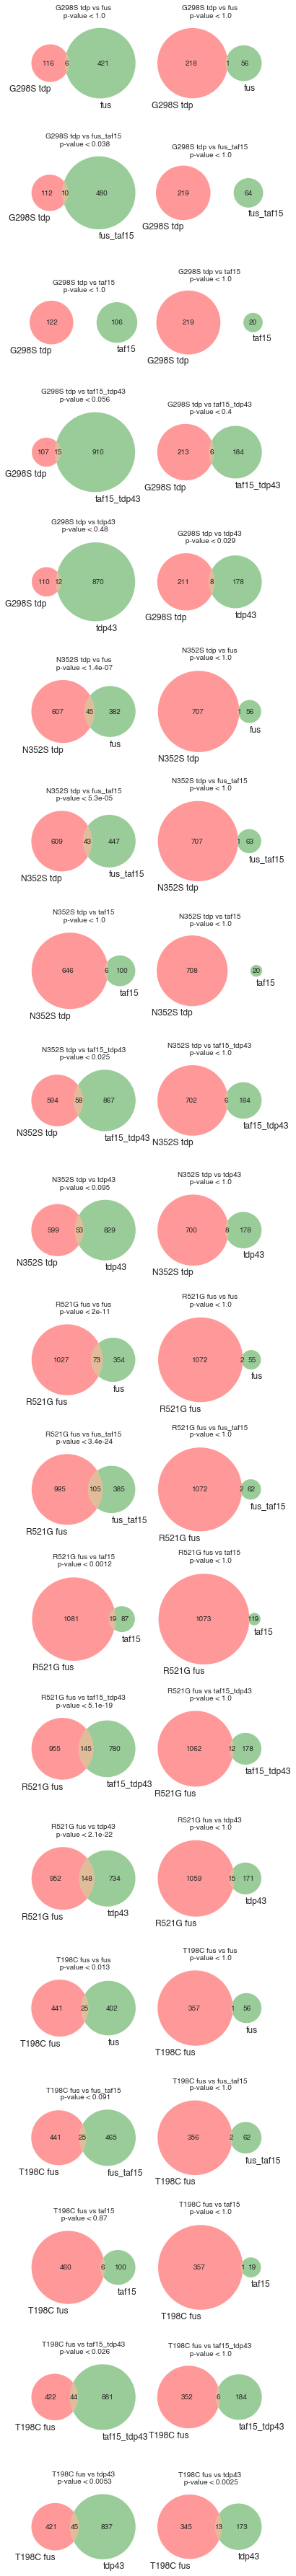

In [449]:
count = 0
row_num = 20
col_num =2

overlapping = {}
with dataviz.Figure(os.path.join(img_dir, "up_and_down_regulation_overlap_taf15_tdp43.svg"), figsize=(col_num * 2.5, row_num * 2.5)) as fig:
    for (ips_downregulated_name, ips_downregulated_df), (ips_upregulated_name, ips_upregulated_df) in zip(ips_signifcant_downregulated.groupby(level=['rbp', 'mutation']), 
                                                                                                          ips_signifcant_upregulated.groupby(level=['rbp', 'mutation'])):
        for (cell_downregulated_name, cell_downregulated_df), (cell_upregulated_name, cell_upregulated_df) in zip(signifcant_downregulated.ix['mn'].groupby(level=["rbp"]),
                                                                                                                  signifcant_upregulated.ix['mn'].groupby(level=["rbp"])):

            count += 1

            ips_down = set(ips_downregulated_df.ix[ips_downregulated_name].index.get_level_values(level='gene'))
            cell_down = set(cell_downregulated_df.ix[cell_downregulated_name].index.get_level_values(level='gene'))

            ips_up = set(ips_upregulated_df.ix[ips_upregulated_name].index.get_level_values(level='gene'))
            cell_up = set(cell_upregulated_df.ix[cell_upregulated_name].index.get_level_values(level='gene'))


            p_value_down = min(hypergeom.sf(len(ips_down & cell_down), len(expressed_genes['mn']), len(ips_down), len(cell_down)) * 20, 1.0)
            p_value_up = min(hypergeom.sf(len(ips_up & cell_up), len(expressed_genes['mn']), len(ips_up), len(cell_up)) * 20, 1.0)
            rbp, cell_type = ips_downregulated_name
            overlapping[(rbp, cell_type, cell_downregulated_name)] = Counter(ips_down & cell_down)
            ax = fig.add_subplot(row_num,col_num,count)
            venn2([ips_down,
                   cell_down,
                   ], set_labels=(" ".join(ips_downregulated_name), cell_downregulated_name), ax =ax )
            ax.set_title("{} vs {}\n p-value < {:.2}".format(" ".join(ips_downregulated_name), 
                                                             cell_downregulated_name,
                                                             p_value_down), fontsize=10)

            count +=1
            ax = fig.add_subplot(row_num,col_num,count)
            venn2([ips_up,
                   cell_up,
                   ], set_labels=(" ".join(ips_upregulated_name), cell_upregulated_name), ax =ax )
            ax.set_title("{} vs {}\n p-value < {:.2}".format(" ".join(ips_upregulated_name), 
                                                             cell_upregulated_name,
                                                             p_value_up), fontsize=10)

In [450]:
overlapping = pd.DataFrame(overlapping).fillna(0)
overlapping.index = [gene_id_to_name[gene_id] for gene_id in overlapping.index]

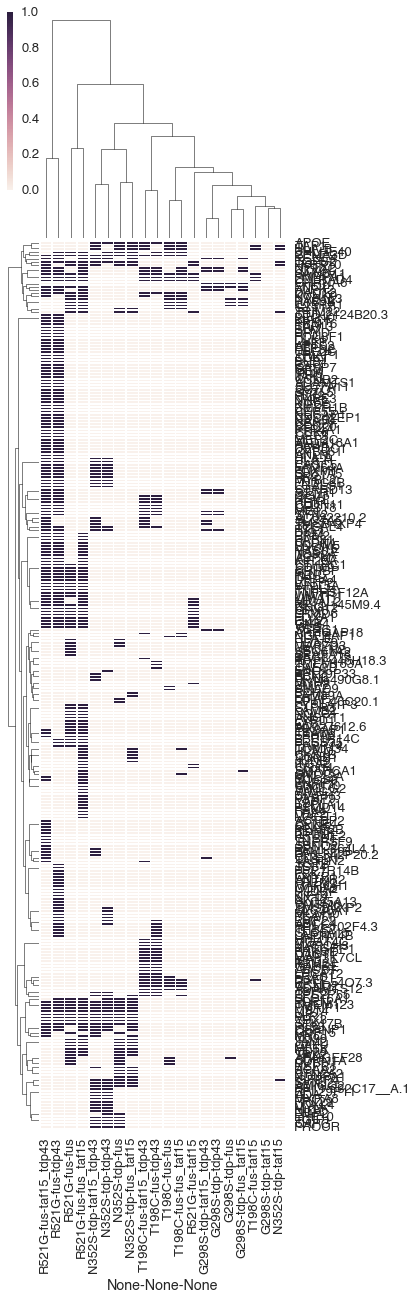

In [451]:
sns.clustermap(overlapping, figsize=(5,20), linewidth=.1)

In [452]:
from matplotlib import pyplot as mpl

In [453]:
overlapping_filtered = overlapping.T.xs("R521G", level=0).T
overlapping_filtered = overlapping_filtered[overlapping_filtered.sum(axis=1) > 1]
overlapping_filtered = overlapping_filtered.T.ix["fus"].T
overlapping_filtered.columns = [rbp_names[rbp] for rbp in overlapping_filtered.columns]

only_fus_taf15 = overlapping_filtered[['FUS', "TAF15", "FUS TAF15"]]
only_fus_taf15 = only_fus_taf15[only_fus_taf15.sum(axis=1) >= 1]

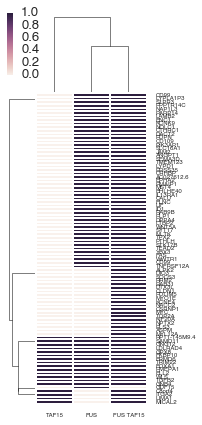

In [454]:
sns.clustermap(only_fus_taf15, figsize=(2.5,7), linewidth=.5)
fig = mpl.gcf()
heatmap = fig.axes[2]
[tick.set_fontsize(6) for tick in heatmap.get_xticklabels()]
[tick.set_fontsize(6) for tick in heatmap.get_yticklabels()]
[tick.set_rotation(0) for tick in heatmap.get_xticklabels()]

fig.savefig(os.path.join(img_dir, "overlapping_r521g_genes.svg"))

This is odd, it looks like I'm getting stuff in the TGF-beta pathway, TGFB2 and DACT2 at least, others maybe, Lif is ringing a bell

Figure Legend: Overlap between TAF15 Knockdowns in either MN or NPC and patient direct iPSC NPCs with known ALS mutati

In [455]:
introns = pybedtools.BedTool("/nas3/gpratt/clipper/clipper/data/regions/hg19_introns.bed")
intron_df = introns.to_dataframe()
intron_df['intron_length'] = intron_df.end - intron_df.start

#Look at intron length distributions


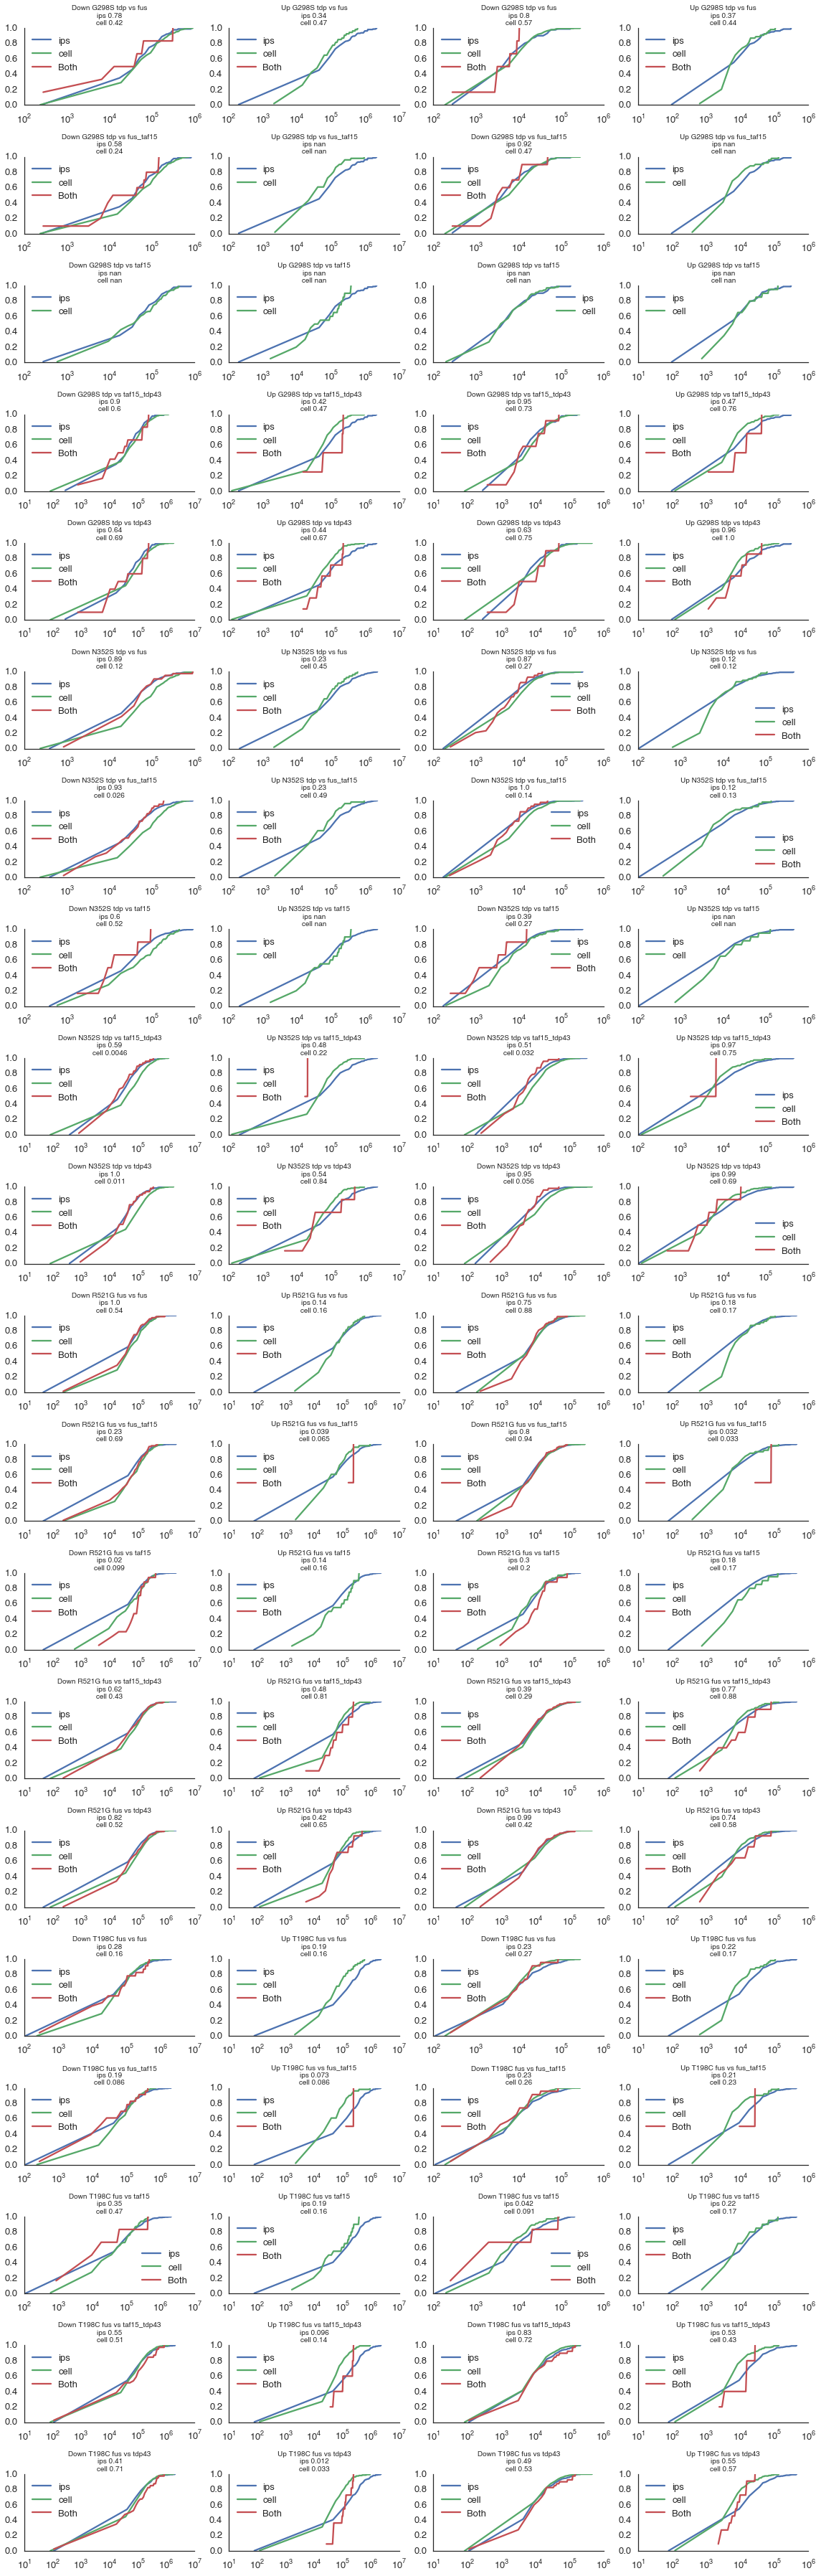

In [456]:
result = {}
count = 0
num_rows = 20
num_cols = 4
gs = gridspec.GridSpec(num_rows, num_cols)

with dataviz.Figure(os.path.join(img_dir, "up_and_down_regulation_overlap_taf15_tdp43.svg"), figsize=(col_num * 8, row_num * 2.5)) as fig:

    for (ips_downregulated_name, ips_downregulated_df), (ips_upregulated_name, ips_upregulated_df) in zip(coding_ips_signifcant_downregulated.groupby(level=['rbp', 'mutation']), 
                                                                                                          coding_ips_signifcant_upregulated.groupby(level=['rbp', 'mutation'])):
        for (cell_downregulated_name, cell_downregulated_df), (cell_upregulated_name, cell_upregulated_df) in zip(coding_signifcant_downregulated.ix['mn'].groupby(level=["rbp"]),
                                                                                                                  coding_signifcant_upregulated.ix['mn'].groupby(level=["rbp"])):
           
            ips_down = set(ips_downregulated_df.ix[ips_downregulated_name].index.get_level_values(level='gene'))
            cell_down = set(cell_downregulated_df.ix[cell_downregulated_name].index.get_level_values(level='gene'))
            both_down = ips_down & cell_down

            ips_up = set(ips_upregulated_df.ix[ips_upregulated_name].index.get_level_values(level='gene'))
            cell_up = set(cell_upregulated_df.ix[cell_upregulated_name].index.get_level_values(level='gene'))
            both_up = ips_up & cell_up
            
            ax = fig.add_subplot(gs[count, 0])
            both_down_len = intron_df[intron_df.name.isin(both_down)].groupby("name").intron_length.sum()
            down_ips_len = intron_df[intron_df.name.isin(ips_down)].groupby("name").intron_length.sum()
            down_cell_len = intron_df[intron_df.name.isin(cell_down)].groupby("name").intron_length.sum()
            
            dataviz.plot_cdf(down_ips_len, label="ips", ax=ax)
            dataviz.plot_cdf(down_cell_len, label="cell", ax=ax)
            if len(both_down_len) > 0:
                dataviz.plot_cdf(both_down_len, label="Both", ax=ax)
                
            ips_down_p_value = ks_2samp(both_down_len, down_ips_len)[1]
            cell_down_p_value = ks_2samp(both_down_len, down_cell_len)[1]
            ax.set_title("Down {} vs {}\nips {:.2}\ncell {:.2}".format(" ".join(ips_downregulated_name), 
                                                                  cell_downregulated_name,
                                                                  ips_down_p_value,
                                                                  cell_down_p_value
                                                                 ), 
                         fontsize=10
                        )
            ax.set_xscale("log")
            ax.legend(loc=0)
            sns.despine(ax=ax)
            
            ax = fig.add_subplot(gs[count, 1])
            both_up_len = intron_df[intron_df.name.isin(both_up)].groupby("name").intron_length.sum()
            both_up_len = intron_df[intron_df.name.isin(both_up)].groupby("name").intron_length.sum()
            up_ips_len = intron_df[intron_df.name.isin(ips_up)].groupby("name").intron_length.sum()
            up_cell_len = intron_df[intron_df.name.isin(cell_up)].groupby("name").intron_length.sum()
            dataviz.plot_cdf(up_ips_len, label="ips", ax=ax)
            dataviz.plot_cdf(up_cell_len, label="cell",ax=ax)           
            if len(both_up_len) > 0:
                dataviz.plot_cdf(both_up_len, label="Both", ax=ax)
                
            ips_up_p_value = ks_2samp(both_up_len, down_ips_len)[1]
            cell_up_p_value = ks_2samp(both_up_len, down_cell_len)[1]
            ax.set_title("Up {} vs {}\nips {:.2}\ncell {:.2}".format(" ".join(ips_upregulated_name), 
                                                                  cell_upregulated_name,
                                                                  ips_up_p_value,
                                                                  cell_up_p_value
                                                                 ), 
                         fontsize=10
                        )
            ax.set_xscale("log")
            ax.legend(loc=0)
            sns.despine(ax=ax)
            
            ax = fig.add_subplot(gs[count, 2])
            both_down_len = intron_df[intron_df.name.isin(both_down)].groupby("name").intron_length.mean()
            down_ips_len = intron_df[intron_df.name.isin(ips_down)].groupby("name").intron_length.mean()
            down_cell_len = intron_df[intron_df.name.isin(cell_down)].groupby("name").intron_length.mean()
            dataviz.plot_cdf(down_ips_len, label="ips", ax=ax)
            dataviz.plot_cdf(down_cell_len, label="cell", ax=ax)           
            if len(both_down_len) > 0:
                dataviz.plot_cdf(both_down_len, label="Both", ax=ax)
                
            ips_down_p_value = ks_2samp(both_down_len, down_ips_len)[1]
            cell_down_p_value = ks_2samp(both_down_len, down_cell_len)[1]
            ax.set_title("Down {} vs {}\nips {:.2}\ncell {:.2}".format(" ".join(ips_downregulated_name), 
                                                                  cell_downregulated_name,
                                                                  ips_down_p_value,
                                                                  cell_down_p_value
                                                                 ), 
                         fontsize=10
                        )
            ax.set_xscale("log")
            ax.legend(loc=0)
            sns.despine(ax=ax)
            
            ax = fig.add_subplot(gs[count, 3])
            both_up_len = intron_df[intron_df.name.isin(both_up)].groupby("name").intron_length.mean()
            up_ips_len = intron_df[intron_df.name.isin(ips_up)].groupby("name").intron_length.mean()
            up_cell_len = intron_df[intron_df.name.isin(cell_up)].groupby("name").intron_length.mean()
            dataviz.plot_cdf(up_ips_len, label="ips", ax=ax)
            dataviz.plot_cdf(up_cell_len, label="cell",ax=ax)
            if len(both_up_len) > 0:
                dataviz.plot_cdf(both_up_len, label="Both", ax=ax)
                
            ips_up_p_value = ks_2samp(both_up_len, down_ips_len)[1]
            cell_up_p_value = ks_2samp(both_up_len, down_cell_len)[1]
            ax.set_title("Up {} vs {}\nips {:.2}\ncell {:.2}".format(" ".join(ips_upregulated_name), 
                                                                  cell_upregulated_name,
                                                                  ips_up_p_value,
                                                                  cell_up_p_value
                                                                 ), 
                         fontsize=10
                        )
            ax.set_xscale("log")
            ax.legend(loc=0)
            sns.despine(ax=ax)
            
            count += 1

In [496]:
genomic_features = get_genomic_regions.GenomicFeatures("hg19")
genomic_regions = genomic_features.get_genomic_regions()

foo


In [511]:
result_downregulated = {}
for name, df in significant_all_downregulated.groupby(level=["cell_type", 'rbp']):
    result_downregulated[name] = genomic_regions["introns"].filter(lambda x: x.name in df.index.get_level_values(level=2)).saveas().to_dataframe()
    
result_upregulated = {}
for name, df in significant_all_upregulated.groupby(level=["cell_type", 'rbp']):
    result_upregulated[name] = genomic_regions["introns"].filter(lambda x: x.name in df.index.get_level_values(level=2)).saveas().to_dataframe()

In [602]:
intron_length_result = pd.concat({"down": pd.concat(result_downregulated),
 "up": pd.concat(result_upregulated)}, names=['direction', 'cell_type', 'rbp', 'foo'])

intron_length_result['intron_length'] = intron_length_result.end - intron_length_result.start 
intron_length_result['rbp'] = intron_length_result.index.get_level_values(2)
intron_length_result['condition'] = intron_length_result.index.get_level_values(1)
intron_length_result['direction'] = intron_length_result.index.get_level_values(0)
intron_length_result['rbp_and_cell_type'] = intron_length_result.rbp + "_" +  intron_length_result.condition

In [603]:
filtered_intron_length_result = intron_length_result[intron_length_result.condition.isin(['npc', 'mn'])]
filtered_intron_length_result = filtered_intron_length_result[filtered_intron_length_result.rbp.isin(['fus', 'taf15', 'tdp43', 'taf15_tdp43 ', 'fus_taf15'])]

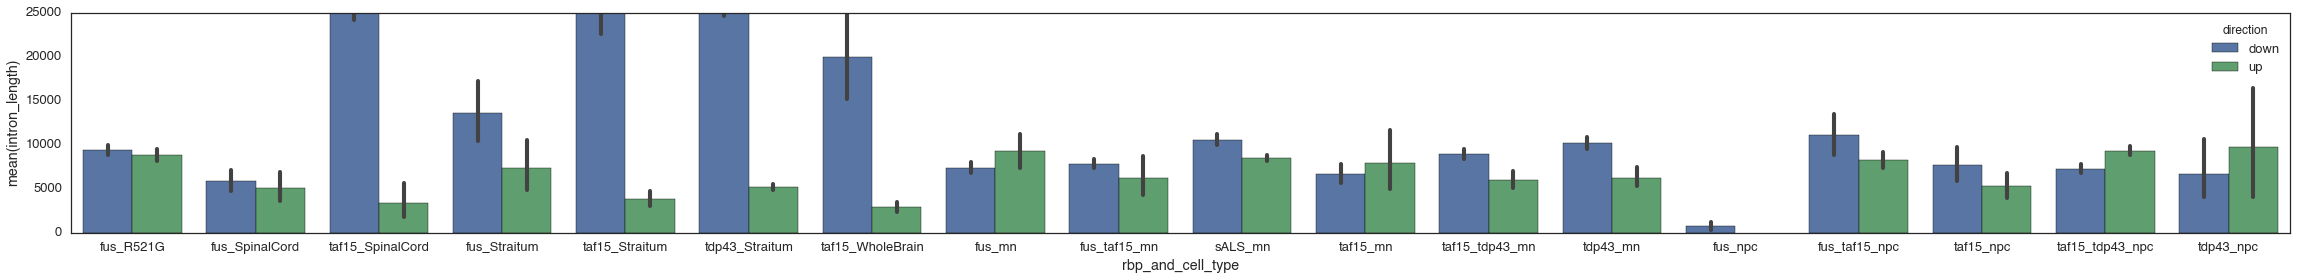

In [573]:
num_rows = 1
num_cols = 8
with dataviz.Figure(os.path.join(img_dir, "intron_length.svg"), figsize=(num_cols * 4,num_rows * 4)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.barplot(data=intron_length_result, x="rbp_and_cell_type", y="intron_length", hue="direction", ax=ax)
    ax.set_ylim(0, 25000)

In [614]:
img_dir

'/nas3/gpratt/Dropbox/TAF15/Data/MN_data/GP_analysis_RNAseq/'

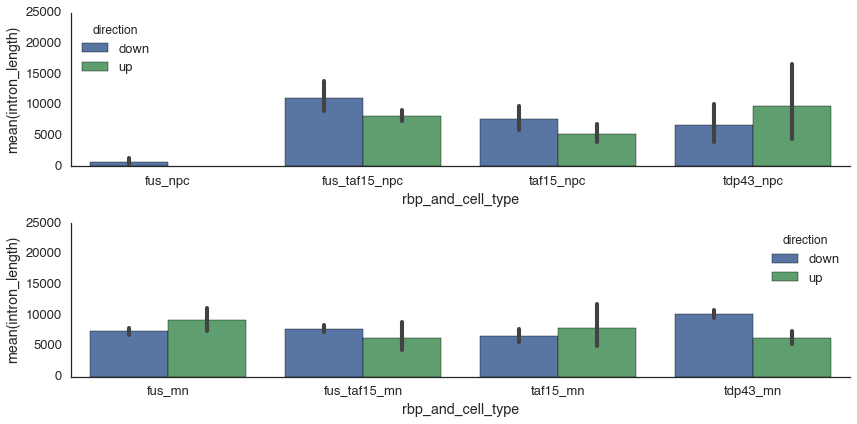

In [613]:
num_rows = 2
num_cols = 4
with dataviz.Figure(os.path.join(img_dir, "intron_length_simplified.svg"), figsize=(num_cols * 3,num_rows * 3)) as fig:
    
    npc_result = filtered_intron_length_result[filtered_intron_length_result.condition.isin(['npc'])]
    mn_result = filtered_intron_length_result[filtered_intron_length_result.condition.isin(['mn'])]
    ax = fig.add_subplot(2,1,1)
    sns.barplot(data=npc_result, x="rbp_and_cell_type", y="intron_length", hue="direction", ax=ax)
    ax.set_ylim(0, 25000)
    sns.despine(ax=ax)
    
    ax = fig.add_subplot(2,1,2)
    sns.barplot(data=mn_result, x="rbp_and_cell_type", y="intron_length", hue="direction", ax=ax)
    ax.set_ylim(0, 25000)
    sns.despine(ax=ax)

('fus', 'mn') Ks_2sampResult(statistic=0.083675930805153287, pvalue=0.0023076363028908344)
need more than 1 value to unpack
('fus_taf15', 'mn') Ks_2sampResult(statistic=0.16802476783762282, pvalue=1.170331831109322e-14)
('fus_taf15', 'npc') Ks_2sampResult(statistic=0.083271304252640843, pvalue=6.2675708183686827e-06)
('taf15', 'mn') Ks_2sampResult(statistic=0.061440497487009083, pvalue=0.35995781636182961)
('taf15', 'npc') Ks_2sampResult(statistic=0.13254304013161766, pvalue=0.0034670083513492832)
('tdp43', 'mn') Ks_2sampResult(statistic=0.13699975781060791, pvalue=7.8020850259159323e-27)
('tdp43', 'npc') Ks_2sampResult(statistic=0.1651629072681704, pvalue=0.42379044103555791)


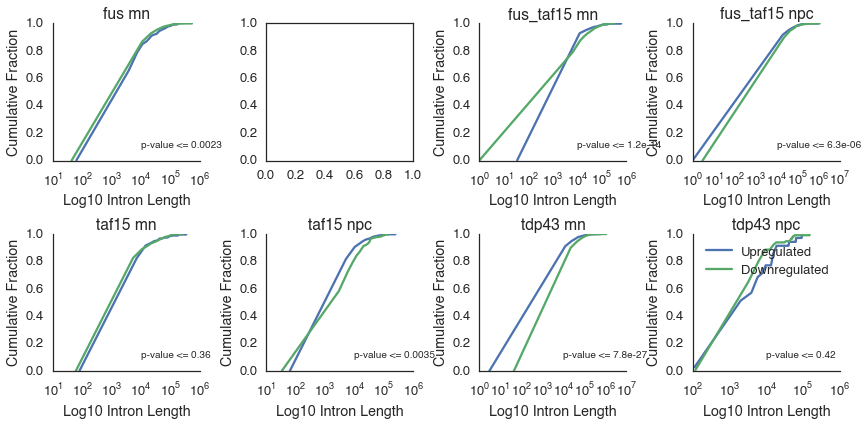

In [732]:
num_rows = 2
num_cols = 4
with dataviz.Figure(os.path.join(img_dir, "intron_length_simplified_cdf.svg"), figsize=(num_cols * 3,num_rows * 3)) as fig:
    for x, (name, df) in enumerate(filtered_intron_length_result.groupby(level=['rbp', 'cell_type'])):
        try:
            ax = fig.add_subplot(2,4, x + 1)
            (down_name, down_df), (up_name, up_df) = list(df.groupby(level=['direction']))
            print name, ks_2samp(up_df.intron_length, down_df.intron_length)
            ax.text(10000, .1, "p-value <= {:.2}".format(ks_2samp(up_df.intron_length, down_df.intron_length).pvalue))
            ax.set_title(" ".join(name))
            dataviz.plot_cdf(up_df.intron_length, label="Upregulated", ax=ax)
            dataviz.plot_cdf(down_df.intron_length, label="Downregulated", ax=ax)
            ax.set_xscale("log")
            if ax.is_last_col() and ax.is_last_row():
                ax.legend()
                
            sns.despine(ax=ax)
            ax.set_ylabel("Cumulative Fraction")
            ax.set_xlabel("Log10 Intron Length")
        except ValueError as e:
            print e
            pass

#Do go analysis of overlapping genes beween KD and mutants

In [457]:
result = {}
for (ips_downregulated_name, ips_downregulated_df), (ips_upregulated_name, ips_upregulated_df) in zip(coding_ips_signifcant_downregulated.groupby(level=['rbp', 'mutation']), 
                                                                                                      coding_ips_signifcant_upregulated.groupby(level=['rbp', 'mutation'])):
    for (cell_downregulated_name, cell_downregulated_df), (cell_upregulated_name, cell_upregulated_df) in zip(coding_signifcant_downregulated.ix['mn'].groupby(level=["rbp"]),
                                                                                                              coding_signifcant_upregulated.ix['mn'].groupby(level=["rbp"])):
        ips_down = set(ips_downregulated_df.ix[ips_downregulated_name].index.get_level_values(level='gene'))
        cell_down = set(cell_downregulated_df.ix[cell_downregulated_name].index.get_level_values(level='gene'))

        ips_up = set(ips_upregulated_df.ix[ips_upregulated_name].index.get_level_values(level='gene'))
        cell_up = set(cell_upregulated_df.ix[cell_upregulated_name].index.get_level_values(level='gene'))

        result[('down', "_".join(ips_downregulated_name), cell_downregulated_name)] = hg19go.enrichment(gencode_to_ensembl(ips_down & cell_down), background=mn_expressed_genes)
        result[('up', "_".join(ips_upregulated_name), cell_upregulated_name)] = hg19go.enrichment(gencode_to_ensembl(ips_up & cell_up), background=mn_expressed_genes)
mutant_overlap = pd.concat(result, names=["direction", "foo", 'GO Term ID']).dropna()

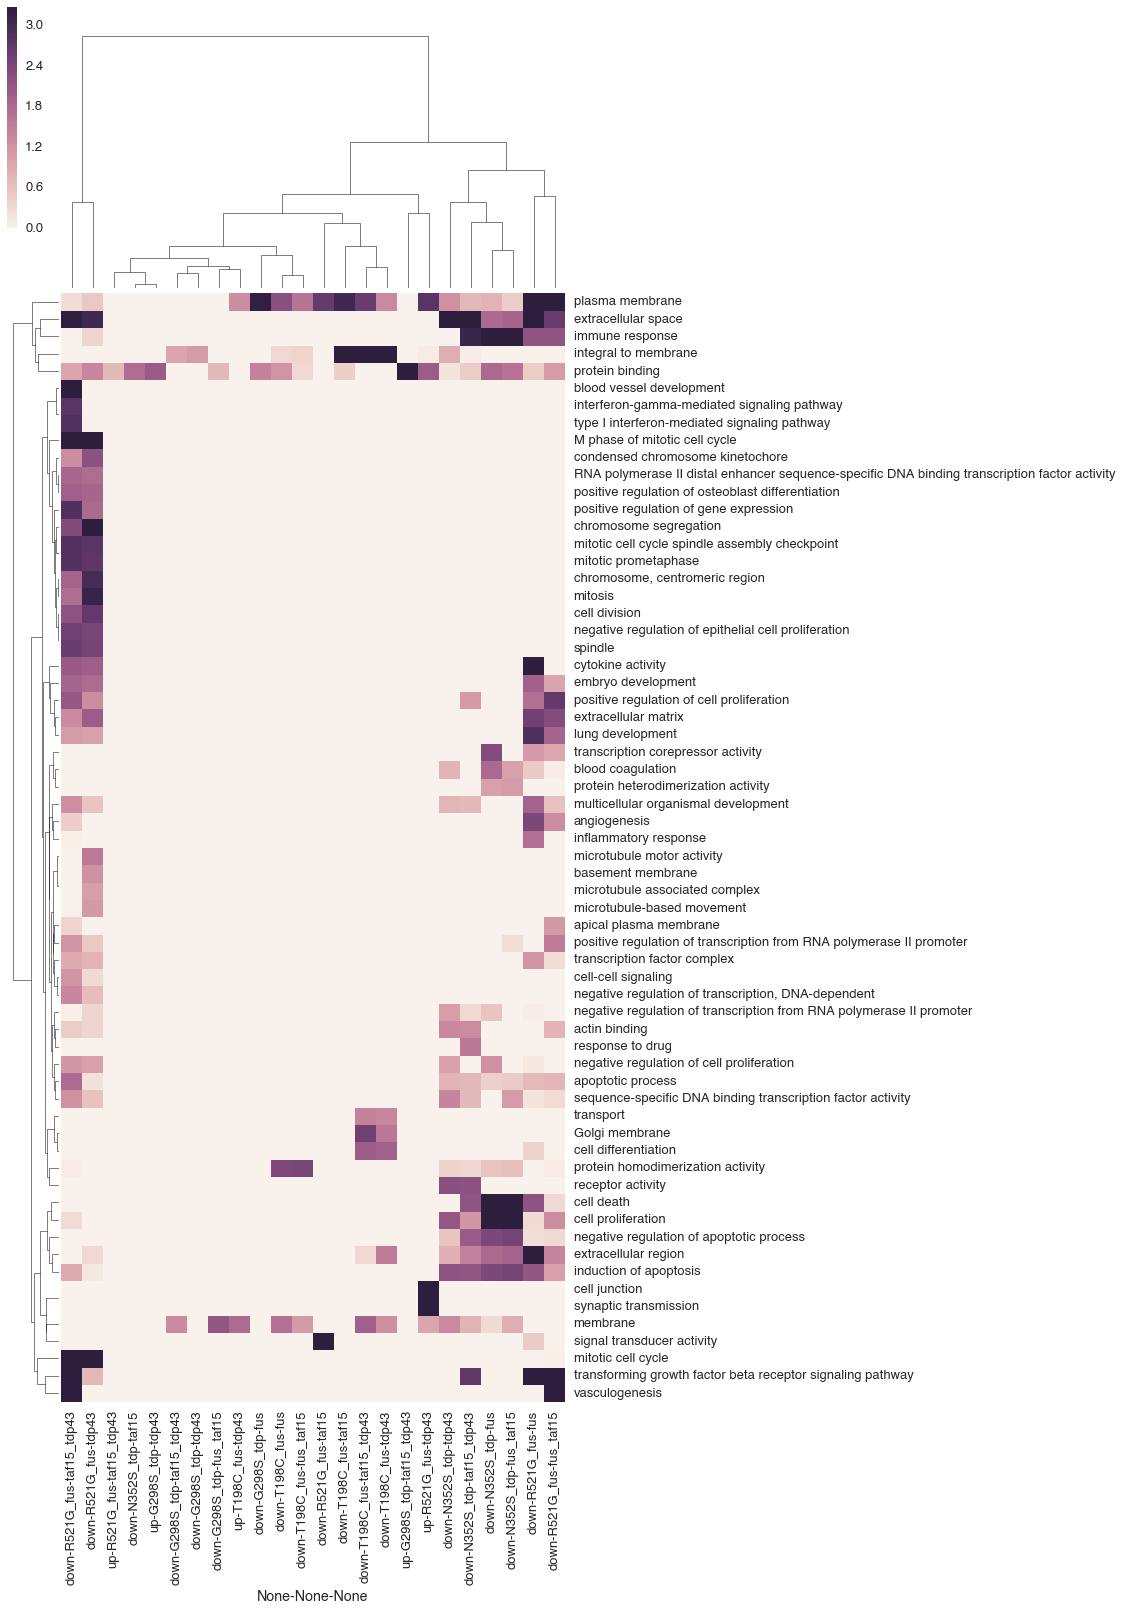

In [458]:
ax = dataviz.plot_go_enrichment(mutant_overlap, filter_value=1, figsize=(10,25))

#Splcing Analysis

In [459]:
!scp tscc-login1.sdsc.edu:/home/gpratt/projects/fet_family/analysis/human_mn_v1/miso/foo.csv .

foo.csv                                       100%  383MB  38.3MB/s   00:10    


In [460]:
all_splicing_events = pd.read_csv("/nas3/gpratt/projects/fet_family/analysis/human_mn_v1/miso/miso_diff_merged.csv", index_col=[0,1,2])

new_index = []
for rbp, factor, event in all_splicing_events.index:
    splice_type = factor.split("_")[-1]
    
    rbp, control = factor.split("vs")
    rbp_rep = rbp.split("_")[-1]
    rbp = "_".join(rbp.split("_")[:-2])
    control_rep = control.split("_")[-2]
    new_index.append([rbp, rbp_rep, control_rep, splice_type, event])
all_splicing_events.index = pd.MultiIndex.from_tuples(new_index, names=['rbp', 'rbp_rep', "control_rep", "splice_type", 'event'])

#How should I should I filter differental splicing Analysis?

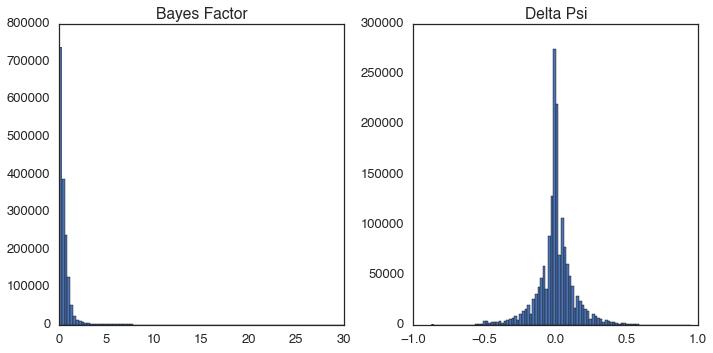

In [461]:
with dataviz.Figure(os.path.join(img_dir, "miso_descriptives.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(1,2,1)
    ax.hist(all_splicing_events.bayes_factor[all_splicing_events.bayes_factor < 30], bins=100)
    ax.set_title("Bayes Factor")
    
    ax = fig.add_subplot(1,2,2)
    ax.hist(all_splicing_events['diff'], bins=100)
    ax.set_title("Delta Psi")

I'll set an arbitary filter at Bayse factor > 3 and differental splicing > .25

In [462]:
significant_splicing_events = all_splicing_events[(all_splicing_events.bayes_factor > 2) & (abs(all_splicing_events['diff']) > .20)]
inclusion_splicing_events = significant_splicing_events[significant_splicing_events['diff'] > 0]
exclusion_splicing_events = significant_splicing_events[significant_splicing_events['diff'] < 0]


result = []
for item in significant_splicing_events.index:
    try:
        result.append(name_to_gene_id[mn_study.splicing.feature_renamer_series[item[4]]])
    except:
        result.append(item[3])
significant_splicing_events['target_gene'] = result


result = []
for item in exclusion_splicing_events.index:
     try:
        result.append(name_to_gene_id[mn_study.splicing.feature_renamer_series[item[4]]])
     except:
         result.append(item[3])
exclusion_splicing_events['target_gene'] = result

result = []
for item in inclusion_splicing_events.index:
    try:
        result.append(name_to_gene_id[mn_study.splicing.feature_renamer_series[item[4]]])
    except:
        result.append(item[3])
inclusion_splicing_events['target_gene'] = result


/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nas/nas0/gpratt/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

#Are there major shifts in inclusion / exclusion for different splice types?


In [463]:
HTML(pd.concat({"all": significant_splicing_events.groupby(level=['rbp', 'rbp_rep', 'control_rep', 'splice_type']).count()['sample1_posterior_mean'],
            "included": inclusion_splicing_events.groupby(level=['rbp', 'rbp_rep', 'control_rep',  'splice_type']).count()['sample1_posterior_mean'],
            "excluded": exclusion_splicing_events.groupby(level=['rbp', 'rbp_rep', 'control_rep',  'splice_type']).count()['sample1_posterior_mean'],}).unstack(level=0).to_html())

Doesn't look like it

#Stringent Filtering for human MN data, what are the reprducable changes?

In [464]:
significant_splicing_events.groupby(level=['rbp', 'splice_type', 'event']).mean()[(significant_splicing_events.groupby(level=['rbp', 'splice_type', 'event']).count() >= 4).sample1_posterior_mean]

sample1_posterior_mean  \
rbp   splice_type event                                                                        
FUS   A3SS        chr11:67374429:67374547:+@chr11:67374770|673748...                   0.925   
                  chr20:23383630:23383709:-@chr20:23377819|233778...                   0.715   
                  chr9:34647086:34647255:+@chr9:34647386|34647472...                   0.325   
                  chr9:34647086:34647255:+@chr9:34647386|34647489...                   0.145   
                  chr9:34647086:34647255:+@chr9:34647386|34647538...                   0.185   
      A5SS        chr14:51094749:51095180|51095189:+@chr14:510989...                   0.590   
                  chr21:34127664:34127524|34127541:-@chr21:341234...                   0.535   
                  chr2:182779943:182781154|182781732:+@chr2:18278...                   0.550   
                  chr3:122439102:122439235|122440500:+@chr3:12244...                   0.700   
      AFE         118424@uc001adm.1@uc001adn.1                                         0.910   
                  118424@uc001adm.1@uc001ado.1uc001adp.1                               0.860   
                  23268@uc001kqh.2@uc001kqj.2                                          0.900   
                  26289@uc001dho.1@uc001dhm.1uc001dhn.1                                0.900   
                  29970@uc003fcu.1@uc003fcr.1                                          0.245   
                  3712@uc001zlr.1@uc001zlp.1uc001zlq.1                                 0.225   
                  4147@uc010mbj.1@uc003yie.1                                           0.515   
                  488@uc001tqn.2@uc001tql.2uc001tqk.2                                  0.535   
                  55249@uc001flg.1@uc009wqw.1                                          0.765   
                  57579@uc003pfm.1@uc003pfh.2                                          0.490   
                  64778@uc003fia.2@uc003fhy.1                                          0.480   
                  64778@uc003fia.2@uc003fhz.2                                          0.430   
                  7871@uc003djh.2uc003dji.1@uc003djg.1                                 0.630   
                  84033@uc001hsp.1@uc001hsn.1uc009xez.1                                0.100   
                  960@uc001mvz.1@uc0011573.uc001mwc.2                                  0.130   
                  960@uc001mwa.1@uc0011566.uc001mwc.2                                  0.105   
      ALE         112817@uc001knx.1@uc001kny.1uc001knz.1                               0.205   
                  164312@uc002wmp.2@uc002wmo.2                                         0.765   
                  4853@uc009who.1@uc001eik.1                                           0.615   
                  56001@uc004eiv.2uc004eiu.2uc004eix.2@uc004ejd.1                      0.445   
                  56001@uc004eiy.2uc004ejb.2uc004eja.2@uc010noa.1                      0.655   
...                                                                                      ...   
TDP43 ALE         51082@uc001uro.1@uc010aam.1uc001urp.1                                0.410   
                  84617@uc002kqv.1uc002kqw.1uc002kqx.1@uc002kqy.2                      0.240   
      MXE         chr14:103592664:103593029:+@chr14:103593342:103...                   0.135   
                  chr17:47755295:47755525:-@chr17:47753257:477533...                   0.330   
                  chr6:30848557:30848902:+@chr6:30852315:30852487...                   0.290   
                  chr6:30850711:30850760:+@chr6:30852315:30852487...                   0.230   
      RI          chr16:15125592-15125763:+@chr16:15126718-151268...                   0.560   
                  chr3:49141139-49141064:-@chr3:49140842-49140778:-                    0.425   
                  chr3:50098895-50098980:+@chr3:50099395-50099541:+                    0.385   
                  chr6:163984452-16398

In [465]:
confident_inclusion_splicing_events = inclusion_splicing_events.groupby(level=['rbp', 'splice_type', 'event']).first()[(inclusion_splicing_events.groupby(level=['rbp', 'splice_type', 'event']).count() >= 4).sample1_posterior_mean]

In [466]:
confident_inclusion_splicing_events

sample1_posterior_mean  \
rbp         splice_type event                                                                        
FUS         A3SS        chr11:67374429:67374547:+@chr11:67374770|673748...                    0.94   
                        chr20:23383630:23383709:-@chr20:23377819|233778...                    0.76   
            A5SS        chr14:51094749:51095180|51095189:+@chr14:510989...                    0.60   
                        chr2:182779943:182781154|182781732:+@chr2:18278...                    0.57   
                        chr3:122439102:122439235|122440500:+@chr3:12244...                    0.78   
            AFE         118424@uc001adm.1@uc001adn.1                                          0.89   
                        118424@uc001adm.1@uc001ado.1uc001adp.1                                0.87   
                        23268@uc001kqh.2@uc001kqj.2                                           0.91   
                        26289@uc001dho.1@uc001dhm.1uc001dhn.1                                 0.93   
                        488@uc001tqn.2@uc001tql.2uc001tqk.2                                   0.52   
                        55249@uc001flg.1@uc009wqw.1                                           0.76   
            ALE         164312@uc002wmp.2@uc002wmo.2                                          0.76   
                        56001@uc004eiy.2uc004ejb.2uc004eja.2@uc010noa.1                       0.73   
            SE          chr10:75156277:75156341:-@chr10:75155802:751558...                    0.75   
                        chr12:95645716:95645847:+@chr12:95650326:956503...                    0.43   
                        chr16:71322989:71323315:-@chr16:71322781:713228...                    0.83   
                        chr17:34858937:34859040:-@chr17:34857692:348578...                    0.79   
                        chr17:80407046:80407168:-@chr17:80405456:804055...                    0.68   
                        chr1:225695653:225695719:-@chr1:225692693:22569...                    0.61   
                        chr1:54325729:54325826:-@chr1:54320674:54320724...                    0.82   
                        chr1:78412215:78412261:-@chr1:78411191:78411327...                    0.88   
                        chr2:229966:230044:-@chr2:224864:224920:-@chr2:...                    0.72   
                        chr3:183353411:183353581:+@chr3:183361268:18336...                    0.71   
                        chr5:68800004:68800121:+@chr5:68804968:68805646...                    0.86   
                        chr6:31773852:31773919:-@chr6:31765767:31765826...                    0.96   
                        chr7:99110076:99110214:+@chr7:99117450:99117532...                    0.81   
                        chr8:145012319:145012408:-@chr8:145011917:14501...                    0.78   
            TANDEMUTR   chr15:47206960:47207437:-@chr15:47206837:472069...                    0.93   
                        chr1:203572268:203573148:-@chr1:203571850:20357...                    0.82   
                        chr22:30004427:30005720:+@chr22:30005721:300060...                    0.79   
...                                                                                            ...   
TAF15_TDP43 TANDEMUTR   chr3:49042367:49042887:-@chr3:49042164:49042366:-                     0.68   
                        chr4:57592011:57592238:-@chr4:57591698:57592010:-                     0.99   
TDP43       A3SS        chr8:120592356:120592407:-@chr8:120583081|12058...                    0.66   
                        chrX:108939373:108939425:-@chrX:108926601|10892...                    0.90   
                        chrY:21872262:21872358:-@chrY:21871695|21872146...                    0.51   
            A5SS        chr19:35168567:35168738|35168761:+@chr19:351696...                    0.74   
                        chr1:150600068:150599788|150599874:-@chr1:15059...                    0.73

In [467]:
confident_exclusion_splicing_events = exclusion_splicing_events.groupby(level=['rbp', 'splice_type', 'event']).first()[(exclusion_splicing_events.groupby(level=['rbp', 'splice_type', 'event']).count() >= 4).sample1_posterior_mean]

In [468]:
confident_exclusion_splicing_events

sample1_posterior_mean  \
rbp         splice_type event                                                                        
FUS         A3SS        chr9:34647086:34647255:+@chr9:34647386|34647472...                    0.30   
                        chr9:34647086:34647255:+@chr9:34647386|34647489...                    0.13   
                        chr9:34647086:34647255:+@chr9:34647386|34647538...                    0.17   
            A5SS        chr21:34127664:34127524|34127541:-@chr21:341234...                    0.52   
            AFE         29970@uc003fcu.1@uc003fcr.1                                           0.27   
                        3712@uc001zlr.1@uc001zlp.1uc001zlq.1                                  0.20   
                        4147@uc010mbj.1@uc003yie.1                                            0.49   
                        57579@uc003pfm.1@uc003pfh.2                                           0.52   
                        64778@uc003fia.2@uc003fhy.1                                           0.49   
                        64778@uc003fia.2@uc003fhz.2                                           0.43   
                        84033@uc001hsp.1@uc001hsn.1uc009xez.1                                 0.11   
                        960@uc001mvz.1@uc0011573.uc001mwc.2                                   0.12   
                        960@uc001mwa.1@uc0011566.uc001mwc.2                                   0.09   
            ALE         112817@uc001knx.1@uc001kny.1uc001knz.1                                0.22   
                        4853@uc009who.1@uc001eik.1                                            0.65   
                        56001@uc004eiv.2uc004eiu.2uc004eix.2@uc004ejd.1                       0.54   
                        6891@uc003ocd.1@uc003sfw.1                                            0.30   
                        8814@uc010anu.1@uc001wxz.1                                            0.12   
            MXE         chr16:3074182:3074287:-@chr16:3073848:3073969:-...                    0.49   
                        chr3:48754590:48754920:-@chr3:48752822:48752960...                    0.28   
            RI          chr11:290678-291113:+@chr11:291976-292095:+                           0.41   
                        chr3:50098895-50098980:+@chr3:50099395-50099541:+                     0.44   
                        chr9:139726173-139726313:+@chr9:139726717-13972...                    0.06   
            SE          chr12:111064167:111064297:+@chr12:111065735:111...                    0.23   
                        chr7:5229835:5230124:+@chr7:5232749:5232976:+@c...                    0.08   
                        chr9:95083950:95084028:-@chr9:95082225:95082419...                    0.19   
FUS_TAF15   A3SS        chr11:65304057:65304221:+@chr11:65304457|653045...                    0.50   
                        chr1:101487197:101487321:-@chr1:101467100|10146...                    0.54   
            AFE         11100@uc010ehl.1@uc002oqb.2uc010ehm.1                                 0.48   
                        492@uc010nuf.1@uc004fhs.1uc004fht.1                                   0.23   
...                                                                                            ...   
TAF15_TDP43 SE          chr12:111064167:111064297:+@chr12:111065857:111...                    0.11   
                        chr19:37826071:37826159:+@chr19:37835512:378356...                    0.06   
                        chr19:9785691:9785776:-@chr19:9771396:9771497:-...                    0.10   
                        chr3:156876655:156876764:-@chr3:156874725:15687...                    0.33   
                        chr6:30850711:30850760:+@chr6:30852315:30852487...                    0.36   
                        chr7:140178637:140178837:-@chr7:140174181:14017...                    0.08   
TDP43       A5SS        chr7:24874355:24873706|24874105:-@chr7:24870387...                    0.27

#What are the overlaps between splicing events?

In [469]:
confident_exclusion_splicing_events.ix['TAF15'].target_gene

splice_type  event                                                                              
A3SS         chr19:9728767:9728855:-@chr19:9728434|9728444:9728297:-                                 ENSG00000171469.6
AFE          221895@uc003szm.1@uc003szn.1                                                                          AFE
             440279@uc002acm.1@uc002acl.2                                                                          AFE
             57579@uc003pfm.1@uc003pfh.2                                                                           AFE
             8470@uc003iya.1uc003iyb.1uc003iyc.1uc003iye.1@uc003iyp.1                                              AFE
ALE          7404@uc004fsy.1@uc004fsw.1                                                                            ALE
SE           chr11:102217966:102218107:+@chr11:102219329:102219495:+@chr11:102220609:102221480:+     ENSG00000110330.4
             chr11:102217966:102218107:+@chr11:102219329:102219495:+@c

In [470]:
set(confident_exclusion_splicing_events.ix['TAF15'].target_gene)

{'AFE',
 'ALE',
 'ENSG00000110330.4',
 'ENSG00000142949.12',
 'ENSG00000171469.6',
 'ENSG00000198000.7'}

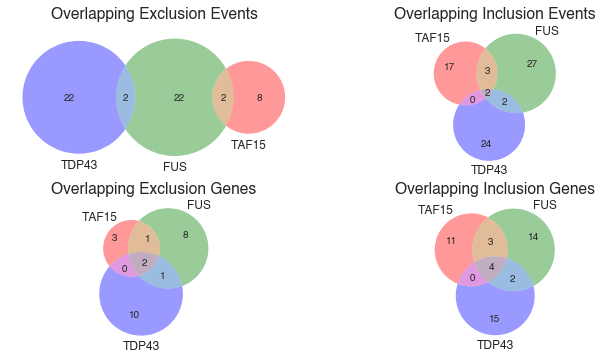

In [471]:
with dataviz.Figure(os.path.join(img_dir, "inclusion_exclusion_splicing_overlap.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(2,2,1)
    venn3([confident_exclusion_splicing_events.ix['TAF15'].index,
    confident_exclusion_splicing_events.ix['FUS'].index,
    confident_exclusion_splicing_events.ix['TDP43'].index,],
            set_labels=("TAF15", "FUS", "TDP43"), ax =ax )
    ax.set_title("Overlapping Exclusion Events")
    
    ax = fig.add_subplot(2,2,2)
    venn3([confident_inclusion_splicing_events.ix['TAF15'].index,
           confident_inclusion_splicing_events.ix['FUS'].index,
           confident_inclusion_splicing_events.ix['TDP43'].index,],
            set_labels=("TAF15", "FUS", "TDP43"), ax =ax )
    ax.set_title("Overlapping Inclusion Events")
        
    ax = fig.add_subplot(2,2,3)
    venn3([set(confident_exclusion_splicing_events.ix['TAF15'].target_gene),
    set(confident_exclusion_splicing_events.ix['FUS'].target_gene),
    set(confident_exclusion_splicing_events.ix['TDP43'].target_gene),],
            set_labels=("TAF15", "FUS", "TDP43"), ax =ax )
    ax.set_title("Overlapping Exclusion Genes")
    
    ax = fig.add_subplot(2,2,4)
    venn3([set(confident_inclusion_splicing_events.ix['TAF15'].target_gene),
           set(confident_inclusion_splicing_events.ix['FUS'].target_gene),
           set(confident_inclusion_splicing_events.ix['TDP43'].target_gene),],
            set_labels=("TAF15", "FUS", "TDP43"), ax =ax )
    ax.set_title("Overlapping Inclusion Genes")

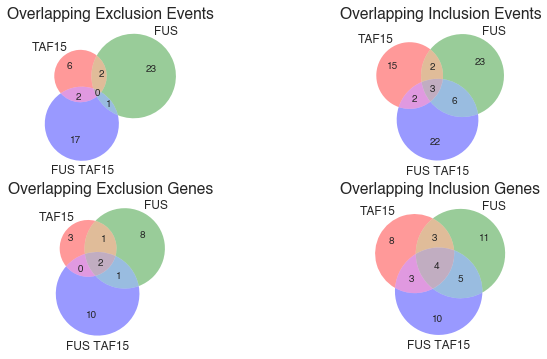

In [472]:
with dataviz.Figure(os.path.join(img_dir, "inclusion_exclusion_splicing_overlap_fus_taf15.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(2,2,1)
    venn3([confident_exclusion_splicing_events.ix['TAF15'].mRNA_starts.index,
    confident_exclusion_splicing_events.ix['FUS'].mRNA_starts.index,
    confident_exclusion_splicing_events.ix['FUS_TAF15'].mRNA_starts.index,],
            set_labels=("TAF15", "FUS", "FUS TAF15"), ax =ax )
    ax.set_title("Overlapping Exclusion Events")
    
    ax = fig.add_subplot(2,2,2)
    venn3([confident_inclusion_splicing_events.ix['TAF15'].index,
           confident_inclusion_splicing_events.ix['FUS'].index,
           confident_inclusion_splicing_events.ix['FUS_TAF15'].index,],
            set_labels=("TAF15", "FUS", "FUS TAF15"), ax =ax )
    ax.set_title("Overlapping Inclusion Events")
    
    ax = fig.add_subplot(2,2,3)
    venn3([set(confident_exclusion_splicing_events.ix['TAF15'].target_gene),
    set(confident_exclusion_splicing_events.ix['FUS'].target_gene),
    set(confident_exclusion_splicing_events.ix['FUS_TAF15'].target_gene),],
            set_labels=("TAF15", "FUS", "FUS TAF15"), ax =ax )
    ax.set_title("Overlapping Exclusion Genes")
    
    ax = fig.add_subplot(2,2,4)
    venn3([set(confident_inclusion_splicing_events.ix['TAF15'].target_gene),
           set(confident_inclusion_splicing_events.ix['FUS'].target_gene),
           set(confident_inclusion_splicing_events.ix['FUS_TAF15'].target_gene),],
            set_labels=("TAF15", "FUS", "FUS TAF15"), ax =ax )
    ax.set_title("Overlapping Inclusion Genes")

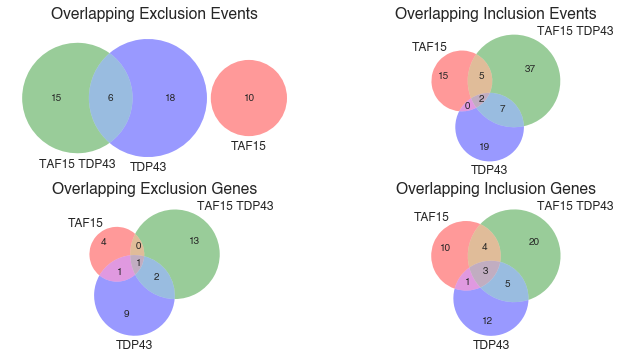

In [473]:
with dataviz.Figure(os.path.join(img_dir, "inclusion_exclusion_splicing_overlap_tdp43_taf15.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(2,2,1)
    venn3([confident_exclusion_splicing_events.ix['TAF15'].mRNA_starts.index,
    confident_exclusion_splicing_events.ix['TAF15_TDP43'].mRNA_starts.index,
    confident_exclusion_splicing_events.ix['TDP43'].mRNA_starts.index,],
            set_labels=("TAF15", "TAF15 TDP43", "TDP43"), ax =ax )
    ax.set_title("Overlapping Exclusion Events")
    
    ax = fig.add_subplot(2,2,2)
    venn3([confident_inclusion_splicing_events.ix['TAF15'].index,
           confident_inclusion_splicing_events.ix['TAF15_TDP43'].index,
           confident_inclusion_splicing_events.ix['TDP43'].index,],
            set_labels=("TAF15", "TAF15 TDP43", "TDP43"), ax =ax )
    ax.set_title("Overlapping Inclusion Events")
    
    ax = fig.add_subplot(2,2,3)
    venn3([set(confident_exclusion_splicing_events.ix['TAF15'].target_gene),
    set(confident_exclusion_splicing_events.ix['TAF15_TDP43'].target_gene),
    set(confident_exclusion_splicing_events.ix['TDP43'].target_gene),],
            set_labels=("TAF15", "TAF15 TDP43", "TDP43"), ax =ax )
    ax.set_title("Overlapping Exclusion Genes")
    
    ax = fig.add_subplot(2,2,4)
    venn3([set(confident_inclusion_splicing_events.ix['TAF15'].target_gene),
           set(confident_inclusion_splicing_events.ix['TAF15_TDP43'].target_gene),
           set(confident_inclusion_splicing_events.ix['TDP43'].target_gene),],
            set_labels=("TAF15", "TAF15 TDP43", "TDP43"), ax =ax )
    ax.set_title("Overlapping Inclusion Genes")

In [474]:
change_direction = Counter()
incorrect = []
for index, sig_item in significant_splicing_events.groupby(level=['rbp', 'splice_type', 'event']):
    if len(sig_item) >= 4:
        if all([event > 0 for event in sig_item['diff']]):
            change_direction['correct_incl'] += 1
        elif  all([event < 0 for event in sig_item['diff']]):
            change_direction['correct_excl'] += 1
        else:
            change_direction['incorrect'] += 1
            incorrect.append(sig_item)

In [475]:
change_direction

Counter({'correct_incl': 168, 'correct_excl': 101, 'incorrect': 9})

Ok so this is my list of high confident Splicing Changes, next thing to do is try to figure out if relaxing those paramaters screws with things, and how

In [476]:
confident_inclusion_splicing_events

sample1_posterior_mean  \
rbp         splice_type event                                                                        
FUS         A3SS        chr11:67374429:67374547:+@chr11:67374770|673748...                    0.94   
                        chr20:23383630:23383709:-@chr20:23377819|233778...                    0.76   
            A5SS        chr14:51094749:51095180|51095189:+@chr14:510989...                    0.60   
                        chr2:182779943:182781154|182781732:+@chr2:18278...                    0.57   
                        chr3:122439102:122439235|122440500:+@chr3:12244...                    0.78   
            AFE         118424@uc001adm.1@uc001adn.1                                          0.89   
                        118424@uc001adm.1@uc001ado.1uc001adp.1                                0.87   
                        23268@uc001kqh.2@uc001kqj.2                                           0.91   
                        26289@uc001dho.1@uc001dhm.1uc001dhn.1                                 0.93   
                        488@uc001tqn.2@uc001tql.2uc001tqk.2                                   0.52   
                        55249@uc001flg.1@uc009wqw.1                                           0.76   
            ALE         164312@uc002wmp.2@uc002wmo.2                                          0.76   
                        56001@uc004eiy.2uc004ejb.2uc004eja.2@uc010noa.1                       0.73   
            SE          chr10:75156277:75156341:-@chr10:75155802:751558...                    0.75   
                        chr12:95645716:95645847:+@chr12:95650326:956503...                    0.43   
                        chr16:71322989:71323315:-@chr16:71322781:713228...                    0.83   
                        chr17:34858937:34859040:-@chr17:34857692:348578...                    0.79   
                        chr17:80407046:80407168:-@chr17:80405456:804055...                    0.68   
                        chr1:225695653:225695719:-@chr1:225692693:22569...                    0.61   
                        chr1:54325729:54325826:-@chr1:54320674:54320724...                    0.82   
                        chr1:78412215:78412261:-@chr1:78411191:78411327...                    0.88   
                        chr2:229966:230044:-@chr2:224864:224920:-@chr2:...                    0.72   
                        chr3:183353411:183353581:+@chr3:183361268:18336...                    0.71   
                        chr5:68800004:68800121:+@chr5:68804968:68805646...                    0.86   
                        chr6:31773852:31773919:-@chr6:31765767:31765826...                    0.96   
                        chr7:99110076:99110214:+@chr7:99117450:99117532...                    0.81   
                        chr8:145012319:145012408:-@chr8:145011917:14501...                    0.78   
            TANDEMUTR   chr15:47206960:47207437:-@chr15:47206837:472069...                    0.93   
                        chr1:203572268:203573148:-@chr1:203571850:20357...                    0.82   
                        chr22:30004427:30005720:+@chr22:30005721:300060...                    0.79   
...                                                                                            ...   
TAF15_TDP43 TANDEMUTR   chr3:49042367:49042887:-@chr3:49042164:49042366:-                     0.68   
                        chr4:57592011:57592238:-@chr4:57591698:57592010:-                     0.99   
TDP43       A3SS        chr8:120592356:120592407:-@chr8:120583081|12058...                    0.66   
                        chrX:108939373:108939425:-@chrX:108926601|10892...                    0.90   
                        chrY:21872262:21872358:-@chrY:21871695|21872146...                    0.51   
            A5SS        chr19:35168567:35168738|35168761:+@chr19:351696...                    0.74   
                        chr1:150600068:150599788|150599874:-@chr1:15059...                    0.73

#GO Analysis on Splicing Genes

In [477]:
def robust_mapper(lst):
    result = []
    for item in lst:
        try:
            result.append(name_to_gene_id[item].split(".")[0])
        except KeyError:
            pass
    return result

In [478]:
significant_splicing_events

sample1_posterior_mean  \
rbp       rbp_rep control_rep splice_type event                                                                        
FUS_TAF15 1       1           A3SS        chr20:33622926:33623111:-@chr20:33609135|336091...                    0.49   
                                          chr20:34800194:34800298:+@chr20:34802279|348022...                    0.83   
                                          chr20:18447506:18447645:-@chr20:18446021|184460...                    0.35   
                                          chr20:25187158:25187226:+@chr20:25187712|251877...                    0.43   
                                          chr3:12944273:12944322:-@chr3:12940933|12943022...                    0.91   
                                          chr3:48225290:48225326:-@chr3:48224517|48224520...                    0.40   
                                          chr3:50387362:50387453:-@chr3:50387259|50387264...                    0.85   
                                          chr3:133372189:133372368:-@chr3:133371458|13337...                    0.43   
                                          chr3:138310696:138310798:-@chr3:138291756|13829...                    0.31   
                                          chr3:49723293:49723395:-@chr3:49723165|49723262...                    0.57   
                                          chr3:119180809:119180995:-@chr3:119177031|11917...                    0.58   
                                          chr17:60759198:60759298:+@chr17:60759417|607595...                    0.43   
                                          chr17:35913217:35914161:-@chr17:35902532|359026...                    0.81   
                                          chr17:41256139:41256278:-@chr17:41251894|412518...                    0.30   
                                          chr17:38191169:38191225:-@chr17:38189709|381900...                    0.47   
                                          chr17:27898609:27898737:+@chr17:27898850|278988...                    0.66   
                                          chr17:42400652:42400711:-@chr17:42399896|423999...                    0.74   
                                          chr17:18155313:18155460:-@chr17:18155127|181551...                    0.39   
                                          chr1:148560847:148561115:+@chr1:148566782|14856...                    0.79   
                                          chr1:225706900:225707267:-@chr1:225705008|22570...                    0.75   
                                          chr1:44457519:44457676:+@chr1:44459476|44459562...                    0.33   
                                          chr1:161136890:161137024:+@chr1:161137129|16113...                    0.11   
                                          chr1:78414840:78414985:-@chr1:78413232|78413237...                    0.79   
                                          chr1:24304401:24304763:-@chr1:24301560|24301570...                    0.67   
                                          chr1:173915614:173915746:-@chr1:173912726|17391...                    0.68   
                                          chr1:162560113:162560301:+@chr1:162562522|16256...                    0.36   
                                          chr1:93677658:93677818:+@chr1:93680300|93680303...                    0.29   
                                          chr1:220101143:220101993:-@chr1:220100447|22010...                    0.65   
                                          chr1:101487197:101487321:-@chr1:101467100|10146...                    0.54   
                                          chr1:111889532:111889671:+@chr1:111891138|11189...                    0.81   
...                                                                                                              ...   
TDP43     2       2           TANDEMUTR   chr16:15037633:15039045:+@chr16:15039046:150396...                    0.94   
              

In [479]:
go_result = {}
for index, lst in significant_splicing_events.groupby(level="rbp"):
    go_result[index] = hg19go.enrichment(gencode_to_ensembl(lst.target_gene))
significant_splicing_events_go = pd.concat(go_result)

In [480]:
significant_splicing_events_go

GO Term Description  \
      GO Term Accession                                                      
FUS   GO:0005634                                                   nucleus   
      GO:0003723                                               RNA binding   
      GO:0005829                                                   cytosol   
      GO:0005813                                                centrosome   
      GO:0000166                                        nucleotide binding   
      GO:0005737                                                 cytoplasm   
      GO:0045202                                                   synapse   
      GO:0003676                                      nucleic acid binding   
      GO:0051539                          4 iron, 4 sulfur cluster binding   
      GO:0005794                                           Golgi apparatus   
      GO:0004385                                 guanylate kinase activity   
      GO:0044431                                      Golgi apparatus part   
      GO:0005801                                         cis-Golgi network   
      GO:0071777             positive regulation of cell cycle cytokinesis   
      GO:0016363                                            nuclear matrix   
      GO:0060271                                      cilium morphogenesis   
      GO:0006260                                           DNA replication   
      GO:0007067                                                   mitosis   
      GO:0000910                                               cytokinesis   
      GO:0003713                        transcription coactivator activity   
      GO:0016192                                vesicle-mediated transport   
      GO:0005488                                                   binding   
      GO:0032981         mitochondrial respiratory chain complex I asse...   
      GO:0003887                      DNA-directed DNA polymerase activity   
      GO:0005739                                             mitochondrion   
      GO:0016567                                    protein ubiquitination   
      GO:0016709         oxidoreductase activity, acting on paired dono...   
      GO:0031054                                      pre-miRNA processing   
      GO:0032407                                 MutSalpha complex binding   
      GO:0000445          THO complex part of transcription export complex   
...                                                                    ...   
TDP43 GO:2001212                              regulation of vasculogenesis   
      GO:2001213                     negative regulation of vasculogenesis   
      GO:2001214                     positive regulation of vasculogenesis   
      GO:2001220         negative regulation of G2 phase of mitotic cel...   
      GO:2001222                            regulation of neuron migration   
      GO:2001223                   negative regulation of neuron migration   
      GO:2001224                   positive regulation of neuron migration   
      GO:2001234         negative regulation of apoptotic signaling pat...   
      GO:2001235         positive regulation of apoptotic signaling pat...   
      GO:2001237         negative regulation of extrinsic apoptotic sig...   
      GO:2001238         positive regulation of extrinsic apoptotic sig...   
      GO:2001240         negative regulation of extrinsic apoptotic sig...   
      GO:2001241         positive regulation of extrinsic apoptotic sig...   
      GO:2001242         regulation of intrinsic apoptotic signaling pa...   
      GO:2001243         negative regulation of intrinsic apoptotic sig...   
      GO:2001246         negative regulation of phosphatidylcholine bio...   
      GO:2001247         positive regulation of phosphatidylcholine bio...   
      GO:2001250         positive regulation of ammonia assimilation cycle   
      GO:2001251            negative regulation of chromosome organization   

#Inclusion

In [481]:
go_result = {}
for index, lst in confident_inclusion_splicing_events.groupby(level="rbp"):
    go_result[index] = hg19go.enrichment(gencode_to_ensembl(lst.target_gene))
confident_inclusion_splicing_events_go = pd.concat(go_result)

In [482]:
confident_inclusion_splicing_events_go

GO Term Description  \
      GO Term Accession                                                      
FUS   GO:0003779                                             actin binding   
      GO:0005515                                           protein binding   
      GO:0005886                                           plasma membrane   
      GO:0005829                                                   cytosol   
      GO:0005634                                                   nucleus   
      GO:0005737                                                 cytoplasm   
      GO:0016021                                      integral to membrane   
      GO:0000002                          mitochondrial genome maintenance   
      GO:0000003                                              reproduction   
      GO:0000009                    alpha-1,6-mannosyltransferase activity   
      GO:0000010                 trans-hexaprenyltranstransferase activity   
      GO:0000012                                single strand break repair   
      GO:0000014         single-stranded DNA specific endodeoxyribonucl...   
      GO:0000015                         phosphopyruvate hydratase complex   
      GO:0000016                                          lactase activity   
      GO:0000018                           regulation of DNA recombination   
      GO:0000019                       regulation of mitotic recombination   
      GO:0000022                                mitotic spindle elongation   
      GO:0000023                                 maltose metabolic process   
      GO:0000026                    alpha-1,2-mannosyltransferase activity   
      GO:0000028                          ribosomal small subunit assembly   
      GO:0000030                              mannosyltransferase activity   
      GO:0000033                    alpha-1,3-mannosyltransferase activity   
      GO:0000035                                              acyl binding   
      GO:0000036         ACP phosphopantetheine attachment site binding...   
      GO:0000038              very long-chain fatty acid metabolic process   
      GO:0000042                                protein targeting to Golgi   
      GO:0000045                               autophagic vacuole assembly   
      GO:0000046                                 autophagic vacuole fusion   
      GO:0000049                                              tRNA binding   
...                                                                    ...   
TDP43 GO:2001213                     negative regulation of vasculogenesis   
      GO:2001214                     positive regulation of vasculogenesis   
      GO:2001220         negative regulation of G2 phase of mitotic cel...   
      GO:2001222                            regulation of neuron migration   
      GO:2001223                   negative regulation of neuron migration   
      GO:2001224                   positive regulation of neuron migration   
      GO:2001234         negative regulation of apoptotic signaling pat...   
      GO:2001235         positive regulation of apoptotic signaling pat...   
      GO:2001237         negative regulation of extrinsic apoptotic sig...   
      GO:2001238         positive regulation of extrinsic apoptotic sig...   
      GO:2001240         negative regulation of extrinsic apoptotic sig...   
      GO:2001241         positive regulation of extrinsic apoptotic sig...   
      GO:2001242         regulation of intrinsic apoptotic signaling pa...   
      GO:2001243         negative regulation of intrinsic apoptotic sig...   
      GO:2001244         positive regulation of intrinsic apoptotic sig...   
      GO:2001246         negative regulation of phosphatidylcholine bio...   
      GO:2001247         positive regulation of phosphatidylcholine bio...   
      GO:2001250         positive regulation of ammonia assimilation cycle   
      GO:2001251            negative regulation of chromosome organization   

#Exclusion Relative to Control

In [483]:
go_result = {}
for index, lst in confident_exclusion_splicing_events.groupby(level="rbp"):
    go_result[index] = hg19go.enrichment(gencode_to_ensembl(lst.target_gene))
confident_exclusion_splicing_events_go = pd.concat(go_result)

In [484]:
confident_exclusion_splicing_events_go

GO Term Description  \
      GO Term Accession                                                      
FUS   GO:0005634                                                   nucleus   
      GO:0005737                                                 cytoplasm   
      GO:0005515                                           protein binding   
      GO:0000002                          mitochondrial genome maintenance   
      GO:0000003                                              reproduction   
      GO:0000009                    alpha-1,6-mannosyltransferase activity   
      GO:0000010                 trans-hexaprenyltranstransferase activity   
      GO:0000012                                single strand break repair   
      GO:0000014         single-stranded DNA specific endodeoxyribonucl...   
      GO:0000015                         phosphopyruvate hydratase complex   
      GO:0000016                                          lactase activity   
      GO:0000018                           regulation of DNA recombination   
      GO:0000019                       regulation of mitotic recombination   
      GO:0000022                                mitotic spindle elongation   
      GO:0000023                                 maltose metabolic process   
      GO:0000026                    alpha-1,2-mannosyltransferase activity   
      GO:0000028                          ribosomal small subunit assembly   
      GO:0000030                              mannosyltransferase activity   
      GO:0000033                    alpha-1,3-mannosyltransferase activity   
      GO:0000035                                              acyl binding   
      GO:0000036         ACP phosphopantetheine attachment site binding...   
      GO:0000038              very long-chain fatty acid metabolic process   
      GO:0000042                                protein targeting to Golgi   
      GO:0000045                               autophagic vacuole assembly   
      GO:0000046                                 autophagic vacuole fusion   
      GO:0000049                                              tRNA binding   
      GO:0000050                                                urea cycle   
      GO:0000052                              citrulline metabolic process   
      GO:0000054                     ribosomal subunit export from nucleus   
      GO:0000056               ribosomal small subunit export from nucleus   
...                                                                    ...   
TDP43 GO:2001213                     negative regulation of vasculogenesis   
      GO:2001214                     positive regulation of vasculogenesis   
      GO:2001220         negative regulation of G2 phase of mitotic cel...   
      GO:2001222                            regulation of neuron migration   
      GO:2001223                   negative regulation of neuron migration   
      GO:2001224                   positive regulation of neuron migration   
      GO:2001234         negative regulation of apoptotic signaling pat...   
      GO:2001235         positive regulation of apoptotic signaling pat...   
      GO:2001237         negative regulation of extrinsic apoptotic sig...   
      GO:2001238         positive regulation of extrinsic apoptotic sig...   
      GO:2001240         negative regulation of extrinsic apoptotic sig...   
      GO:2001241         positive regulation of extrinsic apoptotic sig...   
      GO:2001242         regulation of intrinsic apoptotic signaling pa...   
      GO:2001243         negative regulation of intrinsic apoptotic sig...   
      GO:2001244         positive regulation of intrinsic apoptotic sig...   
      GO:2001246         negative regulation of phosphatidylcholine bio...   
      GO:2001247         positive regulation of phosphatidylcholine bio...   
      GO:2001250         positive regulation of ammonia assimilation cycle   
      GO:2001251            negative regulation of chromosome organization   

#What is the overlap between Stabalized and Destabalized Genes and all my significantly changing RBPs

In [485]:
# count = 0
# with dataviz.Figure(os.path.join(img_dir, "up_and_down_regulation_overlap_taf15_tdp43.svg"), figsize=(10, 10)) as fig:
#     for (downregulated_name, downregluated_df), (upregulated_name, upregluated_df) in zip(signifcant_downregulated.groupby(level=["cell_type", "rbp"]), signifcant_upregulated.groupby(level=["cell_type", "rbp"])):
#         count += 1
#         ax = fig.add_subplot(10,2,count)
#         venn2([set(gencode_to_ensembl(downregluated_df.index.get_level_values(level='gene'))),
#                set(destabalized_genes.index),],
#                 set_labels=(" ".join(downregulated_name), "Destabalized_Genes"), ax =ax 
#                 )
#         ax.set_title(" ".join(downregulated_name) + " Downregulated Genes and destabalized genes")

#         count +=1
#         ax = fig.add_subplot(10,2,count)
#         venn2([set(gencode_to_ensembl(upregluated_df.index.get_level_values(level='gene'))),
#                set(destabalized_genes.index),],
#                 set_labels=(" ".join(upregulated_name), "Destabalized_Genes"), ax =ax 
# )
        
#         ax.set_title(" ".join(downregulated_name) + " Upregulated Genes and destabalized genes")


In [486]:
# count = 0
# with dataviz.Figure(os.path.join(img_dir, "up_and_down_regulation_overlap_taf15_tdp43.svg"), figsize=(10, 10)) as fig:
#     for (downregulated_name, downregluated_df), (upregulated_name, upregluated_df) in zip(signifcant_downregulated.groupby(level=["cell_type", "rbp"]), signifcant_upregulated.groupby(level=["cell_type", "rbp"])):
#         count += 1
#         ax = fig.add_subplot(10,2,count)
#         venn2([set(gencode_to_ensembl(downregluated_df.index.get_level_values(level='gene'))),
#                set(stabalized_genes.index),],
#                 set_labels=(" ".join(downregulated_name), "Destabalized_Genes"), ax =ax 
#                 )
#         ax.set_title(" ".join(downregulated_name) + " Downregulated Genes and destabalized genes")

#         count +=1
#         ax = fig.add_subplot(10,2,count)
#         venn2([set(gencode_to_ensembl(upregluated_df.index.get_level_values(level='gene'))),
#                set(stabalized_genes.index),],
#                 set_labels=(" ".join(upregulated_name), "Destabalized_Genes"), ax =ax 
# )
        
#         ax.set_title(" ".join(downregulated_name) + " Upregulated Genes and destabalized genes")


In [487]:
# count = 0
# with dataviz.Figure(os.path.join(img_dir, "up_and_down_regulation_overlap_taf15_tdp43.svg"), figsize=(10, 20)) as fig:
#     for (downregulated_name, downregluated_df), (upregulated_name, upregluated_df) in zip(signifcant_downregulated.groupby(level=["cell_type", "rbp"]), signifcant_upregulated.groupby(level=["cell_type", "rbp"])):
#         count += 1
#         ax = fig.add_subplot(10,2,count)
#         venn2([set(gencode_to_ensembl(downregluated_df.index.get_level_values(level='gene'))),
#                set(delta_stabality.index),],
#                 set_labels=(" ".join(downregulated_name), "Destabalized_Genes"), ax =ax 
#                 )

#         count +=1
#         ax = fig.add_subplot(10,2,count)
#         venn2([set(gencode_to_ensembl(upregluated_df.index.get_level_values(level='gene'))),
#                set(delta_stabality.index),],
#                 set_labels=(" ".join(upregulated_name), "Destabalized_Genes"), ax =ax 
# )
        


#Look at overlap between RBPs and TFs and Up/down regulated genes

In [488]:
rbps = pd.read_excel("nrg3813-s3.xls", "RBP table", index_col=2)
tfs = pd.read_excel("nrg3813-s4.xls", "human TFs", index_col=1)

In [489]:
with open("/nas3/gpratt/Dropbox/TAF15/Data/networks/rbp_network.csv", 'w') as fn:

    for name, df in signifcant_downregulated.ix['mn'].groupby(level=[ "rbp"]):
        rbp_overlap = set(gencode_to_ensembl(df.index.get_level_values("gene"))) & set(rbps.index)
        print name,  len(df.index), len(rbp_overlap) #rbp_overlap
        for gene in rbp_overlap:
            fn.write(",".join([name, rbps.ix[gene]['gene name'], "downregulated"]) + "\n")
    print
    for name, df in signifcant_upregulated.ix['mn'].groupby(level=["rbp"]):
        rbp_overlap = set(gencode_to_ensembl(df.index.get_level_values("gene"))) & set(rbps.index)
        print name,  len(df.index), len(rbp_overlap) #rbp_overlap
        for gene in rbp_overlap:
            fn.write(",".join([name, rbps.ix[gene]['gene name'], "upregulated"]) + "\n")

fus 427 13
fus_taf15 490 11
taf15 106 4
taf15_tdp43 925 25
tdp43 882 26

fus 57 6
fus_taf15 64 3
taf15 20 1
taf15_tdp43 190 10
tdp43 186 10


In [490]:
!mkdir /nas3/gpratt/Dropbox/TAF15/Data/networks/ 

mkdir: cannot create directory '/nas3/gpratt/Dropbox/TAF15/Data/networks/': File exists


In [491]:
with open("/nas3/gpratt/Dropbox/TAF15/Data/networks/tf_network.csv", 'w') as fn:
    for name, df in signifcant_downregulated.ix['mn'].groupby(level=["rbp"]):
        rbp_overlap = set(gencode_to_ensembl(df.index.get_level_values("gene"))) & set(tfs.index)
        print name,  len(df.index), len(rbp_overlap) #rbp_overlap
        for gene in rbp_overlap:
            fn.write(",".join([name, tfs.ix[gene]['gene name'], "downregulated"]) + "\n")
    print
    for name, df in signifcant_upregulated.ix['mn'].groupby(level=["rbp"]):
        rbp_overlap = set(gencode_to_ensembl(df.index.get_level_values("gene"))) & set(tfs.index)
        print name,  len(df.index), len(rbp_overlap) #rbp_overlap
        for gene in rbp_overlap:
            fn.write(",".join([name, tfs.ix[gene]['gene name'], "upregulated"]) + "\n")


fus 427 21
fus_taf15 490 28
taf15 106 3
taf15_tdp43 925 45
tdp43 882 44

fus 57 4
fus_taf15 64 6
taf15 20 1
taf15_tdp43 190 9
tdp43 186 16


In [492]:
intersting_genes = set(['ENSG00000186868', 'ENSG00000186868', 'ENSG00000186868',
       'ENSG00000186868', 'ENSG00000186868', 'ENSG00000186868',
       'ENSG00000186868', 'ENSG00000186868', 'ENSG00000186868',
       'ENSG00000186868', 'ENSG00000186868', 'ENSG00000186868',
       'ENSG00000140983', 'ENSG00000140983', 'ENSG00000140983',
       'ENSG00000140983', 'ENSG00000140983', 'ENSG00000140983',
       'ENSG00000140983', 'ENSG00000140983', 'ENSG00000140983',
       'ENSG00000140983', 'ENSG00000140983', 'ENSG00000140983',
       'ENSG00000140983', 'ENSG00000140983', 'ENSG00000140983',
       'ENSG00000140983', 'ENSG00000140983', 'ENSG00000131711',
       'ENSG00000126858', 'ENSG00000126858', 'ENSG00000126858',
       'ENSG00000126858', 'ENSG00000126858', 'ENSG00000126858',
       'ENSG00000126858', 'ENSG00000126858', 'ENSG00000126858',
       'ENSG00000054523', 'ENSG00000054523', 'ENSG00000054523',
       'ENSG00000054523', 'ENSG00000054523', 'ENSG00000054523',
       'ENSG00000054523', 'ENSG00000054523', 'ENSG00000054523',
       'ENSG00000054523', 'ENSG00000054523'])

In [493]:
sum([item.split(".")[0] in intersting_genes for item in significant_knockdowns.index.get_level_values(level="gene")])

0

Get all the mouse data I've processed elsewhere
---

In [494]:
mouse_human_genes = pd.read_table("/nas3/gpratt/projects/taf15/mouse_human_genes.txt", index_col=0)
mouse_human_genes = dict(izip(mouse_human_genes.index, mouse_human_genes['Human Ensembl Gene ID']))

ensembl_to_name = {key.split(".")[0]: value for key, value in gene_id_to_name.items()}
def map_to_human(genes):
    for gene in genes:
        try:
            gene =  mouse_human_genes[gene]
        except:
            gene = np.nan
        yield gene
        
def map_to_name(genes):
    for gene in genes:
        try:
            gene =  ensembl_to_name[gene]
        except:
            gene = "error"
        yield gene

In [495]:
ensembl_to_gencode_dict = {gene_id.split(".")[0]: gene_id for gene_id in gene_id_to_name}
def ensembl_to_gencode(gene_id):
    try:
        return ensembl_to_gencode_dict[gene_id]
    except KeyError:
        return np.nan
    
mouse_knockdowns = pd.concat({os.path.basename(rbp).split(".")[0]: pd.read_csv(rbp, index_col=0) for rbp in glob.glob("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/deseq/*")})

results = []
for item in mouse_knockdowns.index:
   results.append(item[0].split("_") + [item[1]])
mouse_knockdowns.index = pd.MultiIndex.from_tuples(results, names=["rbp", 'cell_type', "geneid"])
mouse_knockdowns = mouse_knockdowns.sortlevel()

mouse_knockdowns['human_gene_id'] =  list(map_to_human(gencode_to_ensembl(mouse_knockdowns.index.get_level_values(level="geneid"))))
mouse_knockdowns = mouse_knockdowns.dropna()

new_index = []
for index, row in mouse_knockdowns.iterrows():
    new_index.append([index[0], index[1], ensembl_to_gencode(row.human_gene_id)])
mouse_knockdowns.index = pd.MultiIndex.from_tuples(new_index)
mouse_knockdowns = mouse_knockdowns.swaplevel(0,1)
mouse_knockdowns = mouse_knockdowns[[item is not np.nan for item in mouse_knockdowns.dropna().index.get_level_values(level=2)]]

ValueError: Length of names must match number of levels in MultiIndex.

In [ ]:
mouse_significant_knockdowns = mouse_knockdowns[(mouse_knockdowns.padj <= .05) & (abs(mouse_knockdowns.log2FoldChange) > np.log2(1.5))]
mouse_significant_knockdowns = mouse_significant_knockdowns.dropna()
mouse_signifcant_upregulated = mouse_significant_knockdowns[mouse_significant_knockdowns.log2FoldChange > 0]
mouse_signifcant_downregulated = mouse_significant_knockdowns[mouse_significant_knockdowns.log2FoldChange < 0]

#Add in the sALS Specific Genes

In [ ]:
sALS = pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/sALS/sALS.csv", index_col=0)
sALS.index.names = ["gene_id"]
sALS['gene_name'] = [gene_id_to_name[gene_id] for gene_id in sALS.index]

new_index = []
for index in sALS.index:
    new_index.append(['mn', 'sALS', index])
sALS.index = pd.MultiIndex.from_tuples(new_index)

significant_sALS = sALS[(sALS.padj <= .05) & (abs(sALS.log2FoldChange) > np.log2(1.5))]
significant_sALS_upregulated = significant_sALS[significant_sALS.log2FoldChange > 0]
significant_sALS_downregulated = significant_sALS[significant_sALS.log2FoldChange < 0]

print len(significant_sALS_upregulated) + len(significant_sALS_downregulated), len(significant_sALS_upregulated), len(significant_sALS_downregulated)

significant_sALS_downregulated_go = hg19go.enrichment(gencode_to_ensembl(significant_sALS_downregulated.index.get_level_values(level=2)), background=expressed_genes['mn'])
significant_sALS_upregulated_go = hg19go.enrichment(gencode_to_ensembl(significant_sALS_upregulated.index.get_level_values(level=2)), background=expressed_genes['mn'])
sALS_go = pd.concat({"down": significant_sALS_downregulated_go, 
                    "up": significant_sALS_upregulated_go}, names=['direction'])
sALS_go = sALS_go[sALS_go['Bonferroni-corrected Hypergeometric p-Value'] < .05]

In [ ]:
HTML(sALS_go.to_html())

In [ ]:
HTML(significant_sALS_upregulated.to_html())

In [ ]:
HTML(significant_sALS_downregulated.to_html())

In [ ]:
# def convert_to_gene_id(gene_name):
#     try:
#         return name_to_gene_id[gene_name]
#     except:
#         return np.nan
    
# sals = pd.read_excel("/nas3/gpratt/Dropbox/TAF15/Data/sALS/Supplementary_Table_2.xlsx", "2(A) Gene-expression_MPR", skiprows=1)
# sals['gene_id'] = sals.gene_symbol.apply(convert_to_gene_id)
# sals = sals.dropna(subset=["gene_id"])

# upregulated_sals = sals[sals['Ratio MPR'] > .85]
# downregulated_sals = sals[sals['Ratio MPR'] < .15]

#Combine Everything

In [ ]:
all_knockdowns = pd.concat([mouse_knockdowns, knockdowns, ips_knockdowns, sALS])
all_knockdowns = all_knockdowns.drop(["gene_name", "gene_names", "human_gene_id"], axis=1)
all_knockdowns["gene_name"] = [gene_id_to_name[gene_id] for gene_id in all_knockdowns.index.get_level_values(level=2)]
all_knockdowns.index.names = ['cell_type', 'rbp', 'gene_id']
all_knockdowns = all_knockdowns.drop(["ews", "hur", "tia1", "hnrnpa2b1"], level="rbp")
all_knockdowns = all_knockdowns.drop(["N352S", "T198C", "G298S"], level="cell_type")

significant_all_knockdowns = all_knockdowns[(all_knockdowns.padj <= .05) & (abs(all_knockdowns.log2FoldChange) > np.log2(1.5))]
significant_all_upregulated = significant_all_knockdowns[significant_all_knockdowns.log2FoldChange > 0]
significant_all_downregulated = significant_all_knockdowns[significant_all_knockdowns.log2FoldChange < 0]

coding_all_knockdowns = all_knockdowns[[gene_id_to_type[gene] == 'protein_coding' for gene in all_knockdowns.index.get_level_values(level="gene_id")]]
coding_significant_all_knockdowns = significant_all_knockdowns[[gene_id_to_type[gene] == 'protein_coding' for gene in significant_all_knockdowns.index.get_level_values(level="gene_id")]]
coding_significant_all_upregulated = significant_all_upregulated[[gene_id_to_type[gene] == 'protein_coding' for gene in significant_all_upregulated.index.get_level_values(level="gene_id")]]
coding_significant_all_downregulated = significant_all_downregulated[[gene_id_to_type[gene] == 'protein_coding' for gene in significant_all_downregulated.index.get_level_values(level="gene_id")]]


In [ ]:
significant_all_knockdowns.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/all_significant_knockdowns.csv")

In [ ]:
!head /nas3/gpratt/Dropbox/TAF15/Data/all_significant_knockdowns.csv

In [ ]:
result = {}
for (rbp, cell_type), df in significant_all_downregulated.groupby(level=["cell_type", "rbp"]):
    result[cell_type, rbp, "downregulated"] = Counter(gencode_to_ensembl(df.index.get_level_values(level="gene_id")))

for (rbp, cell_type), df in significant_all_upregulated.groupby(level=["cell_type", "rbp"]):
    result[cell_type, rbp, "upregulated"] = Counter(gencode_to_ensembl(df.index.get_level_values(level="gene_id")))

all_changing_genes = pd.DataFrame(result).fillna(0)
all_changing_genes.index = map_to_name(all_changing_genes.index)
all_changing_genes[all_changing_genes > 1] = 1
all_changing_genes.columns.names = ['rbp', 'cell_type', 'direction']


In [ ]:
overlapping_changing_genes = all_changing_genes[all_changing_genes.sum(axis=1) > 4]

sns.clustermap(overlapping_changing_genes, linewidth=.1,figsize= (15,60))

In [ ]:
just_mutants_and_rons_data = pd.concat([all_changing_genes.T.xs("R521G", level="cell_type", axis=0, drop_level=False),
                                        all_changing_genes.T.xs("mn", level="cell_type", axis=0, drop_level=False),
                                       ])

In [ ]:
just_mutants_and_rons_data_downregulated = just_mutants_and_rons_data.xs("downregulated", level="direction")

In [ ]:
sns.clustermap(just_mutants_and_rons_data.ix[:,just_mutants_and_rons_data.sum() >= 3],linewidth=.1,figsize= (70,5))

#Follow Up on Observation that Upregulated Genes in sALS appear to be down-regulated in the rest of my stuff

In [ ]:
#print len(sals_down.index & mutant_down.index), len(mn_expressed_genes),len(sals_down), len(mutant_down)

#print len(sals_up.index & mutant_up.index), len(mn_expressed_genes), len(sals_up), len(mutant_up)
#print len(sals_down.index & mutant_up.index), len(mn_expressed_genes), len(sals_down), len(mutant_up)
#print len(sals_up.index & mutant_down.index), len(mn_expressed_genes), len(sals_up), len(mutant_down)

In [ ]:
# p_value_down = hypergeom.sf(len(sals_down.index & mutant_down.index), 
#                                         len(mn_expressed_genes), 
#                                         len(sals_down), 
#                                         len(mutant_down))
# p_value_up =  hypergeom.sf(len(sals_up.index & mutant_up.index), 
#                                 len(mn_expressed_genes), 
#                                 len(sals_up), 
#                                 len(mutant_up))
# p_value_down_up =  hypergeom.sf(len(sals_down.index & mutant_up.index), 
#                                 len(mn_expressed_genes), 
#                                 len(sals_down), 
#                                 len(mutant_up))
# p_value_up_down =  hypergeom.sf(len(sals_up.index & mutant_down.index), 
#                                 len(mn_expressed_genes), 
#                                 len(sals_up), 
#                                 len(mutant_down))

In [ ]:
#print p_value_down, p_value_up, p_value_down_up, p_value_up_down

In [ ]:
count = 0
row_num = 324
col_num = 4
gs = gridspec.GridSpec(row_num, col_num)
#with dataviz.Figure(os.path.join(img_dir, "up_and_down_regulation_overlap_everything.svg"), figsize=(col_num * 2.5, row_num * 2.5)) as fig:
for (ips_downregulated_name, ips_downregulated_df), (ips_upregulated_name, ips_upregulated_df) in zip(coding_significant_all_downregulated.groupby(level=['cell_type', 'rbp']), 
                                                                                                      coding_significant_all_upregulated.groupby(level=['cell_type', 'rbp'])):
    for (cell_downregulated_name, cell_downregulated_df), (cell_upregulated_name, cell_upregulated_df) in zip(coding_significant_all_downregulated.groupby(level=[ "cell_type", "rbp",]),
                                                                                                              coding_significant_all_upregulated.groupby(level=["cell_type", "rbp", ])):


        ips_down = set(ips_downregulated_df.ix[ips_downregulated_name].index)
        cell_down = set(cell_downregulated_df.ix[cell_downregulated_name].index)

        ips_up = set(ips_upregulated_df.ix[ips_upregulated_name].index)
        cell_up = set(cell_upregulated_df.ix[cell_upregulated_name].index)


        p_value_down = min(hypergeom.sf(len(ips_down & cell_down), len(mn_expressed_genes), len(ips_down), len(cell_down)) * 20, 1.0)
        p_value_up = min(hypergeom.sf(len(ips_up & cell_up), len(mn_expressed_genes), len(ips_up), len(cell_up)) * 20, 1.0)

        p_value_down_up = min(hypergeom.sf(len(ips_down & cell_up), len(mn_expressed_genes), len(ips_down), len(cell_up)) * 20, 1.0)
        p_value_up_down = min(hypergeom.sf(len(ips_up & cell_down), len(mn_expressed_genes), len(ips_up), len(cell_down)) * 20, 1.0)

        print ips_downregulated_name, cell_downregulated_name, p_value_down, p_value_up, p_value_down_up, p_value_up_down

#             ax = fig.add_subplot(gs[count, 0])
#             venn2([ips_down,
#                    cell_down,
#                    ], set_labels=(" ".join(ips_downregulated_name), cell_downregulated_name), ax =ax )
#             ax.set_title("{} vs {}\n p-value < {:.2}".format(" ".join(ips_downregulated_name), 
#                                                              cell_downregulated_name,
#                                                              p_value_down), fontsize=10)

#             ax = fig.add_subplot(gs[count, 1])
#             venn2([ips_up,
#                    cell_up,
#                    ], set_labels=(" ".join(ips_upregulated_name), cell_upregulated_name), ax =ax )
#             ax.set_title("{} vs {}\n p-value < {:.2}".format(" ".join(ips_upregulated_name), 
#                                                              cell_upregulated_name,
#                                                              p_value_up), fontsize=10)

#             ax = fig.add_subplot(gs[count, 2])
#             venn2([ips_up,
#                    cell_down,
#                    ], set_labels=(" ".join(ips_upregulated_name), cell_upregulated_name), ax =ax )
#             ax.set_title("{} vs {}\n p-value < {:.2}".format(" ".join(ips_upregulated_name), 
#                                                              cell_upregulated_name,
#                                                              p_value_up_down), fontsize=10)

#             ax = fig.add_subplot(gs[count, 3])
#             venn2([ips_down,
#                    cell_up,
#                    ], set_labels=(" ".join(ips_upregulated_name), cell_upregulated_name), ax =ax )
#             ax.set_title("{} vs {}\n p-value < {:.2}".format(" ".join(ips_upregulated_name), 
#                                                              cell_upregulated_name,
#                                                              p_value_down_up), fontsize=10)



In [ ]:
count = 0
row_num = 2
col_num = 2
gs = gridspec.GridSpec(row_num, col_num)
with dataviz.Figure(os.path.join(img_dir, "up_down_regulation_overlap_sALS_mn.svg"), figsize=(col_num * 2.0, row_num * 2.0)) as fig:
    for (cell_downregulated_name, cell_downregulated_df), (cell_upregulated_name, cell_upregulated_df) in zip(coding_significant_all_downregulated.ix['mn'].ix[['fus', 'taf15', 'tdp43', 'fus_taf15']].groupby(level=[ 'rbp']), 
                                                                                                          coding_significant_all_upregulated.ix['mn'].ix[['fus', 'taf15', 'tdp43', 'fus_taf15']].groupby(level=['rbp'])):


        ips_down = set(coding_significant_all_downregulated.ix['mn', 'sALS'].index)
        cell_down = set(cell_downregulated_df.ix[cell_downregulated_name].index)

        ips_up = set(coding_significant_all_upregulated.ix['mn', 'sALS'].index)
        cell_up = set(cell_upregulated_df.ix[cell_upregulated_name].index)


        p_value_down = min(hypergeom.sf(len(ips_down & cell_down), len(mn_expressed_genes), len(ips_down), len(cell_down)) * 20, 1.0)
        p_value_up = min(hypergeom.sf(len(ips_up & cell_up), len(mn_expressed_genes), len(ips_up), len(cell_up)) * 20, 1.0)

        p_value_down_up = min(hypergeom.sf(len(ips_down & cell_up), len(mn_expressed_genes), len(ips_down), len(cell_up)) * 20, 1.0)
        p_value_up_down = min(hypergeom.sf(len(ips_up & cell_down), len(mn_expressed_genes), len(ips_up), len(cell_down)) * 20, 1.0)

        print ips_downregulated_name, cell_downregulated_name, p_value_down, p_value_up, p_value_down_up, p_value_up_down

#             ax = fig.add_subplot(gs[0, count])
#             venn2([ips_down,
#                    cell_down,
#                    ], set_labels=(rbp_names[ips_downregulated_name], "R521G"), 
#                   set_colors=[rbp_colors[ips_downregulated_name],rbp_colors["R521G"]],
#                   ax =ax )
#             ax.set_title("{} vs {}\n p < {:.2}".format(rbp_names[ips_downregulated_name], 
#                                                              "R521G",
#                                                              p_value_down), fontsize=10)

#             ax = fig.add_subplot(gs[count, 1])
#             venn2([ips_up,
#                    cell_up,
#                    ], set_labels=(ips_upregulated_name, cell_upregulated_name), ax =ax )
#             ax.set_title("{} vs {}\n p-value < {:.2}".format(ips_upregulated_name, 
#                                                              cell_upregulated_name,
#                                                              p_value_up), fontsize=10)
        count += 1
        ax = fig.add_subplot(row_num, col_num, count)
        venn = venn2([ips_up,
               cell_down,
               ], set_labels=("sALS", rbp_names[cell_upregulated_name]), 
              set_colors=[rbp_colors["sALS"], rbp_colors[cell_upregulated_name]],
              ax =ax )
        ax.set_title("{} vs {}\n p-value < {:.2}".format("sALS", 
                                                         rbp_names[cell_upregulated_name],
                                                         p_value_up_down), fontsize=8)
        [label.set_fontsize(8) for label in venn.set_labels]
        [label.set_fontsize(8) for label in venn.subset_labels]


#         ax = fig.add_subplot(gs[1, count])
#         venn2([ips_down,
#                cell_up,
#                ], set_labels=(ips_upregulated_name, cell_upregulated_name), ax =ax )
#         ax.set_title("{} vs {}\n p-value < {:.2}".format(ips_upregulated_name, 
#                                                          cell_upregulated_name,
#                                                          p_value_down_up), fontsize=10)
        

Strangely it looks like sALS upregulated genes are downregulated in mn knockdowns

In [ ]:
def overlapping_gene_quadrants(df):
        fc_1_up_fc_2_up = df[(df.log2FoldChange_1 > np.log2(1.5)) & (df.log2FoldChange_2 > np.log2(1.5))]
        fc_1_down_fc_2_down = df[(df.log2FoldChange_1 < -1 * np.log2(1.5)) & (df.log2FoldChange_2 < -1 * np.log2(1.5))]
        fc_1_up_fc_2_down =  df[(df.log2FoldChange_1 > np.log2(1.5)) & (df.log2FoldChange_2 < -1 * np.log2(1.5))]
        fc_1_down_fc_2_up = df[(df.log2FoldChange_1 < -1 * np.log2(1.5)) & (df.log2FoldChange_2 > np.log2(1.5))]
        
        fc_1_up = df[(df.log2FoldChange_1 > np.log2(1.5))]
        fc_2_up = df[(df.log2FoldChange_2 > np.log2(1.5))]
        fc_1_down = df[(df.log2FoldChange_1 < -1 * np.log2(1.5))]
        fc_2_down = df[(df.log2FoldChange_2 < -1 * np.log2(1.5))]
        
        result = { "fc_1_up_fc_2_up": fc_1_up_fc_2_up, 
                "fc_1_down_fc_2_down": fc_1_down_fc_2_down, 
                "fc_1_up_fc_2_down": fc_1_up_fc_2_down, 
                "fc_1_down_fc_2_up": fc_1_down_fc_2_up,
#                 "fc_1_up": fc_1_up, 
#                 "fc_2_up": fc_2_up, 
#                 "fc_1_down": fc_1_down,
#                 "fc_2_down": fc_2_down,
                
            }   
        return result
    
def count_quadrants(df):

        return {key: len(value) for key, value in overlapping_gene_quadrants(df).items()}

    
def plot_regressions(merged_df, shuffled_merged_df, not_significant_merged_df, ax =ax):

        result = count_quadrants(merged_df)
        shuffled_result = count_quadrants(shuffled_merged_df)

        ax.scatter(not_significant_merged_df.log2FoldChange_1, 
                   not_significant_merged_df.log2FoldChange_2, 
                   alpha=.7,
                   s=1, 
                   color='0.75', 
                   rasterized=True
                  )
        
        ax.scatter(merged_df.log2FoldChange_1, merged_df.log2FoldChange_2, alpha=.7, s=1, color='r', label="Real")
        ax.scatter(shuffled_merged_df.log2FoldChange_1, shuffled_merged_df.log2FoldChange_2, alpha=.7, s=1, color='k', label="Shuffled")

        linregress = scipy.stats.linregress(merged_df.log2FoldChange_1, merged_df.log2FoldChange_2)

        ax.axvline(np.log2(1.5), color='k', alpha=.6, linewidth=1)
        ax.axvline(-1 * np.log2(1.5), color='k', alpha=.6, linewidth=1)
        
        ax.axhline(np.log2(1.5), color='k', alpha=.6, linewidth=1)
        ax.axhline(-1 * np.log2(1.5), color='k', alpha=.6, linewidth=1)
        
        ax.text(2.8,1.8, "R = {:.2}\np < {:.2}".format(linregress.rvalue, linregress.pvalue), fontsize=6)
        
        ax.text(-3,-3, "N = {}, {}".format(result["fc_1_down_fc_2_down"], shuffled_result["fc_1_down_fc_2_down"]), fontsize=6)
        ax.text(-3,3, "N = {}, {}".format(result["fc_1_down_fc_2_up"], shuffled_result["fc_1_down_fc_2_up"]), fontsize=6)
        ax.text(3,-3, "N = {}, {}".format(result["fc_1_up_fc_2_down"], shuffled_result["fc_1_up_fc_2_down"]), fontsize=6)
        ax.text(3,3, "N = {}, {}".format(result["fc_1_up_fc_2_up"], shuffled_result["fc_1_up_fc_2_up"]), fontsize=6)

        xlim = ax.get_xlim()
        #ax.plot(xlim, 
        #        (linregress.slope * xlim[0] + linregress.intercept, linregress.slope * xlim[1] + linregress.intercept),
        #       alpha=.7, color=".75")
        [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)

        return pd.Series(result), pd.Series(shuffled_result)
    
def plot_regressions(merged_df, shuffled_merged_df, not_significant_merged_df, ax =ax):

        result = count_quadrants(merged_df)
        shuffled_result = count_quadrants(shuffled_merged_df)

        ax.scatter(not_significant_merged_df.log2FoldChange_1, 
                   not_significant_merged_df.log2FoldChange_2, 
                   alpha=.7,
                   s=1, 
                   color='0.75', 
                   rasterized=True
                  )
        
        ax.scatter(merged_df.log2FoldChange_1, merged_df.log2FoldChange_2, alpha=.7, s=1, color='r', label="Real")
        ax.scatter(shuffled_merged_df.log2FoldChange_1, shuffled_merged_df.log2FoldChange_2, alpha=.7, s=1, color='k', label="Shuffled")

        linregress = scipy.stats.linregress(merged_df.log2FoldChange_1, merged_df.log2FoldChange_2)

        ax.axvline(np.log2(1.5), color='k', alpha=.6, linewidth=1)
        ax.axvline(-1 * np.log2(1.5), color='k', alpha=.6, linewidth=1)
        
        ax.axhline(np.log2(1.5), color='k', alpha=.6, linewidth=1)
        ax.axhline(-1 * np.log2(1.5), color='k', alpha=.6, linewidth=1)
        
        ax.text(2.8,1.8, "R = {:.2}\np < {:.2}".format(linregress.rvalue, linregress.pvalue), fontsize=6)
        
        ax.text(-3,-3, "N = {}, {}".format(result["fc_1_down_fc_2_down"], shuffled_result["fc_1_down_fc_2_down"]), fontsize=6)
        ax.text(-3,3, "N = {}, {}".format(result["fc_1_down_fc_2_up"], shuffled_result["fc_1_down_fc_2_up"]), fontsize=6)
        ax.text(3,-3, "N = {}, {}".format(result["fc_1_up_fc_2_down"], shuffled_result["fc_1_up_fc_2_down"]), fontsize=6)
        ax.text(3,3, "N = {}, {}".format(result["fc_1_up_fc_2_up"], shuffled_result["fc_1_up_fc_2_up"]), fontsize=6)

        xlim = ax.get_xlim()
        #ax.plot(xlim, 
        #        (linregress.slope * xlim[0] + linregress.intercept, linregress.slope * xlim[1] + linregress.intercept),
        #       alpha=.7, color=".75")
        [tick.set_fontsize(6) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(6) for tick in ax.get_yticklabels()]
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)

        return pd.Series(result), pd.Series(shuffled_result)

#Emperical shuffling to figure out a background distribution
I don't want to use this because I have a rigerous stastical method below for the test I'm trying tp perform

In [ ]:
result = []
for name, df in coding_all_knockdowns.groupby(level=['cell_type', 'rbp']):
    df = df.copy()
    df.index = pd.MultiIndex.from_tuples(np.random.permutation(df.index))
    result.append(df)
    
shuffled_all_knockdowns = pd.concat(result, names=coding_all_knockdowns.index.names)
shuffled_all_knockdowns.index.names = coding_all_knockdowns.index.names

shuffled_significant_all_knockdowns = shuffled_all_knockdowns[(shuffled_all_knockdowns.padj <= .05) & (abs(shuffled_all_knockdowns.log2FoldChange) > np.log2(1.5))]
shuffled_significant_all_upregulated = shuffled_significant_all_knockdowns[shuffled_significant_all_knockdowns.log2FoldChange > 0]
shuffled_significant_all_downregulated = significant_all_knockdowns[significant_all_knockdowns.log2FoldChange < 0]

#shuffled_not_significant_changes = shuffled_all_knockdowns[shuffled_all_knockdowns.padj > .05]
shuffled_not_signficant_sals_all = shuffled_all_knockdowns.ix['mn', 'sALS']

In [ ]:
sALS_all = coding_significant_all_knockdowns.ix['mn', 'sALS']
sALS_upregulated = coding_significant_all_upregulated.ix['mn', 'sALS']
sALS_all_all = coding_all_knockdowns.ix['mn', 'sALS']

shuffled_all_sals = shuffled_significant_all_knockdowns.ix['mn', 'sALS']
not_significant_changes = coding_all_knockdowns[coding_all_knockdowns.padj > .05]
not_signficant_sals_all = not_significant_changes.ix['mn', 'sALS']

In [ ]:
row_num = 1
col_num = 4

real_result = {}
go_result = defaultdict(dict)
shuffled_result = {}
with dataviz.Figure(os.path.join(img_dir, "significant_regulation.svg"), figsize=(col_num * 2.0, row_num * 2.0)) as fig:
    overlapping_mn_kds = coding_significant_all_knockdowns.ix['mn'].drop(['sALS', "taf15_tdp43"], level="rbp")
    for x, (name, df) in enumerate(overlapping_mn_kds.groupby(level="rbp")):
        ax = fig.add_subplot(row_num, col_num, x)

        merged_df = sALS_all.join(df, lsuffix="_1", rsuffix="_2")
        shuffled_merged_df = shuffled_all_sals.join(shuffled_significant_all_knockdowns.ix['mn', name], lsuffix="_1", rsuffix="_2").dropna()

        not_significant_merged_df = sALS_all_all.join(all_knockdowns.ix['mn', name], lsuffix="_1", rsuffix="_2")
        not_significant_merged_df = not_significant_merged_df[(np.abs(not_significant_merged_df.log2FoldChange_1) < np.log2(1.5)) |  (np.abs(not_significant_merged_df.log2FoldChange_2) < np.log2(1.5))]

        real_result[name], shuffled_result[name] = plot_regressions(merged_df, shuffled_merged_df, not_significant_merged_df, ax=ax)
        
        if ax.is_last_col() and ax.is_first_row():
            ax.legend(loc=0, fontsize=6)
        sns.despine(ax=ax)
        if ax.is_last_row():
            ax.set_xlabel("sALS Log2 Fold Change", fontsize=6)
            
        ax.set_ylabel("{} Log2 Fold Change".format(rbp_names[name]), fontsize=6)
        results = {}
        for change, df in overlapping_gene_quadrants(merged_df).items():
            result = hg19go.enrichment(gencode_to_ensembl(df.index.get_level_values(level="gene_id")), 
                                       background=mn_expressed_genes).dropna()
            go_result[("sals", name, change)] = result[result['Bonferroni-corrected Hypergeometric p-Value'] < .05]
            
real_result = pd.DataFrame(real_result)
shuffled_result = pd.DataFrame(shuffled_result)

#GO analysis of different quadrent analysis for sALS and KD lines

In [ ]:
quadrant_go_result = pd.concat(go_result)

In [ ]:
HTML(quadrant_go_result.xs("fc_1_up_fc_2_down", level=2).to_html())

In [ ]:
dataviz.plot_go_enrichment(quadrant_go_result.xs("fc_1_up_fc_2_down", level=2), figsize=(10,10), max_terms=50)

In [ ]:
row_num = 1
col_num = 4

real_result = {}
shuffled_result = {}
with dataviz.Figure(os.path.join(img_dir, "significant_regulation.svg"), figsize=(col_num * 2.0, row_num * 2.0)) as fig:
    overlapping_mn_kds = coding_significant_all_knockdowns.ix['mn'].drop(['sALS', "taf15_tdp43"], level="rbp")
    for x, (name, df) in enumerate(overlapping_mn_kds.groupby(level="rbp")):
        ax = fig.add_subplot(row_num, col_num, x)

        merged_df = sALS_all.join(df, lsuffix="_1", rsuffix="_2")
        
        not_significant_merged_df = sALS_all_all.join(all_knockdowns.ix['mn', name], lsuffix="_1", rsuffix="_2")
        not_significant_merged_df = not_significant_merged_df[(np.abs(not_significant_merged_df.log2FoldChange_1) < np.log2(1.5)) |  (np.abs(not_significant_merged_df.log2FoldChange_2) < np.log2(1.5))]

        real_result[name], shuffled_result[name] = plot_regressions(merged_df, shuffled_merged_df, not_significant_merged_df, ax=ax)
        
        if ax.is_last_col() and ax.is_first_row():
            ax.legend(loc=0, fontsize=6)
        sns.despine(ax=ax)
        if ax.is_last_row():
            ax.set_xlabel("sALS Log2 Fold Change", fontsize=6)
            
        ax.set_ylabel("{} Log2 Fold Change".format(rbp_names[name]), fontsize=6)
        
real_result = pd.DataFrame(real_result)
shuffled_result = pd.DataFrame(shuffled_result)

In [ ]:
scipy.stats.chisquare(real_result, shuffled_result)

If you shuffle only the significant ones the numbers don't change because they have basically already been locked.  There are more upregulated genes that overlap with downregulated genes so the shuffling won't change that background.  But if you shuffle all the genes to see what the overlaps look like randomly...

#Chi Sq test figure out if the fraction of up and downregulated genes overlapping is higher than expected by chance

tl;dr we use a chisq distribution and calculate the expected distribution by the P(up sals) * P(up kd), P(up sals) * P(down kd) ect...

In [ ]:
fraction_downregulated = (coding_significant_all_downregulated.groupby(level=["cell_type", "rbp"]).count() / coding_significant_all_knockdowns.groupby(level=["cell_type", "rbp"]).count())['log2FoldChange']
fraction_regulated = pd.DataFrame(fraction_downregulated)
fraction_regulated.columns = ['fraction_downregulated']
fraction_regulated['fraction_upregulated'] = 1 - fraction_regulated.fraction_downregulated

In [ ]:
def pairwise_probablity(p1, p2):
    return pd.Series({"fc_1_down_fc_2_down": p1.fraction_downregulated * p2.fraction_downregulated,
    "fc_1_down_fc_2_up": p1.fraction_downregulated * p2.fraction_upregulated,
    "fc_1_up_fc_2_down": p1.fraction_upregulated  * p2.fraction_downregulated,
    "fc_2_up_fc_2_up": p1.fraction_upregulated  * p2.fraction_upregulated,})

In [ ]:
# for name, count in real_df.sum().iteritems():
#     expected = count * pairwise_probablity(fraction_regulated.ix['mn', 'sALS'], fraction_regulated.ix['mn', name])
#     result = scipy.stats.chisquare(real_result[name].values, expected.values)
#     print name, result.pvalue

In [ ]:
# count = r532g_result['real'].sum()
# expected = count * pairwise_probablity(fraction_regulated.ix['mn', 'sALS'], fraction_regulated.ix['R521G', 'fus'])
# result = scipy.stats.chisquare(r532g_result['real'].values, expected.values)
# print name, result.pvalue

The distribution of sALS overlap with the knockdowns appears to be independent

#Now for the subset hail mary to see if its significant in R521G

In [ ]:
significant_all_upregulated.groupby(level=["cell_type", "rbp"]).count()

In [ ]:
all_knockdowns[all_knockdowns.gene_name == 'FUS']

In [ ]:
significant_all_downregulated.groupby(level=["cell_type", "rbp"]).count()

In [ ]:
coding_significant_all_knockdowns.groupby(level=["cell_type", "rbp"]).count()

In [ ]:
count = 0
row_num = 2
col_num = 3
gs = gridspec.GridSpec(row_num, col_num)
with dataviz.Figure(os.path.join(img_dir, "sALS_and_R521G_mn_overlap.svg"), figsize=(col_num * 3.0, row_num * 3.0)) as fig:
    for name, df in coding_significant_all_knockdowns.ix['mn'].groupby(level="rbp"):
        count += 1
        ax = fig.add_subplot(row_num, col_num, count)
        venn3([df.ix[name].index, 
               coding_significant_all_knockdowns.ix['R521G', 'fus'].index, 
               coding_significant_all_knockdowns.ix['mn', 'sALS'].index],
             set_labels=[name, 'R521G', 'sALS'])
        

In [ ]:
count = 0
row_num = 2
col_num = 2
gs = gridspec.GridSpec(row_num, col_num)
with dataviz.Figure(os.path.join(img_dir, "sALS_vs_R521G_overlaps.svg"), figsize=(col_num * 2.5, row_num * 2.5)) as fig:
    ips_downregulated_name = "sALS"
    ips_downregulated_df = coding_significant_all_downregulated.ix['mn', 'sALS']
    ips_upregulated_name = "sALS"
    ips_upregulated_df = coding_significant_all_upregulated.ix['mn', 'sALS']

    cell_downregulated_name = "R521G"
    cell_downregulated_df = coding_significant_all_downregulated.ix['R521G', 'fus']
    cell_upregulated_name = "R521G"
    cell_upregulated_df = coding_significant_all_upregulated.ix['R521G', 'fus']



    ips_down = set(ips_downregulated_df.index)
    cell_down = set(cell_downregulated_df.index)

    ips_up = set(ips_upregulated_df.index)
    cell_up = set(cell_upregulated_df.index)


    p_value_down = min(hypergeom.sf(len(ips_down & cell_down), len(mn_expressed_genes), len(ips_down), len(cell_down)) * 20, 1.0)
    p_value_up = min(hypergeom.sf(len(ips_up & cell_up), len(mn_expressed_genes), len(ips_up), len(cell_up)) * 20, 1.0)

    p_value_down_up = min(hypergeom.sf(len(ips_down & cell_up), len(mn_expressed_genes), len(ips_down), len(cell_up)) * 20, 1.0)
    p_value_up_down = min(hypergeom.sf(len(ips_up & cell_down), len(mn_expressed_genes), len(ips_up), len(cell_down)) * 20, 1.0)

    print ips_downregulated_name, cell_downregulated_name, p_value_down, p_value_up, p_value_down_up, p_value_up_down

    ax = fig.add_subplot(gs[0, 0])
    venn2([ips_down,
           cell_down,
           ], set_labels=(ips_downregulated_name, cell_downregulated_name), ax =ax )
    ax.set_title("Up {} vs Up {}\n p < {:.2}".format(ips_downregulated_name, 
                                                     cell_downregulated_name,
                                                     p_value_down), fontsize=10)

    ax = fig.add_subplot(gs[0, 1])
    venn2([ips_up,
           cell_up,
           ], set_labels=(ips_upregulated_name, cell_upregulated_name), ax =ax )
    ax.set_title("Down {} vs Down {}\n p < {:.2}".format(" ".join(ips_upregulated_name), 
                                                     cell_upregulated_name,
                                                     p_value_up), fontsize=10)

    ax = fig.add_subplot(gs[1, 0])
    venn2([ips_up,
           cell_down,
           ], set_labels=(ips_upregulated_name, cell_upregulated_name), ax =ax )
    ax.set_title("Up {} vs Down {}\n p < {:.2}".format(ips_upregulated_name, 
                                                     cell_upregulated_name,
                                                     p_value_up_down), fontsize=10)

    ax = fig.add_subplot(gs[1, 1])
    venn2([ips_down,
           cell_up,
           ], set_labels=(ips_upregulated_name, cell_upregulated_name), ax =ax )
    ax.set_title("Down {} vs Up {}\n p < {:.2}".format(ips_upregulated_name, 
                                                     cell_upregulated_name,
                                                     p_value_down_up), fontsize=10)

In [ ]:
img_dir

In [ ]:
row_num = 1
col_num = 2

mutant_all = coding_significant_all_knockdowns.ix[('R521G', 'fus')]
shuffled_mutant_all = shuffled_significant_all_knockdowns.ix[('R521G', 'fus')]
r532g_result = {}
with dataviz.Figure(os.path.join(img_dir, "sals_r521g_scatter.svg"), figsize=(col_num * 2.5, row_num * 2.5)) as fig:
        ax = fig.add_subplot(1, 2, 1)
        merged_df = sALS_all.join(mutant_all, lsuffix="_1", rsuffix="_2").dropna()
        shuffled_merged_df = shuffled_all_sals.join(shuffled_mutant_all, lsuffix="_1", rsuffix="_2").dropna()

        not_significant_merged_df = sALS_all_all.join(all_knockdowns.ix[('R521G', 'fus')], lsuffix="_1", rsuffix="_2")
        not_significant_merged_df = not_significant_merged_df[(np.abs(not_significant_merged_df.log2FoldChange_1) < np.log2(1.5)) |  (np.abs(not_significant_merged_df.log2FoldChange_2) < np.log2(1.5))]

        r532g_result['real'], r532g_result['random'] = plot_regressions(merged_df, shuffled_merged_df, not_significant_merged_df, ax=ax)

        sns.despine(ax=ax)
        ax.set_xlabel("sALS Log2 Fold Change", fontsize=6)
        ax.set_ylabel("{} Log2 Fold Change".format("R521G"), fontsize=6)
        ax.legend(loc=0)
        ax.set_xlim(-4,4)
        ax.set_ylim(-4,4)

In [ ]:
print scipy.stats.chisquare(r532g_result['real'].values, r532g_result['random'].values)

count = r532g_result['real'].sum()
expected = count * pairwise_probablity(fraction_regulated.ix['mn', 'sALS'], fraction_regulated.ix['R521G', 'fus'])
result = scipy.stats.chisquare(r532g_result['real'].values, expected.values)
print "R521G Estimated Chi Sq value", result.pvalue

#Overlap R521G changing genes with the knockdowns that are already changing

In [ ]:
row_num = 2
col_num = 2

r521g_real_result = {}
r521g_shuffled_result = {}

r521g_kd = significant_all_knockdowns.ix['R521G', 'fus']
shuffled_r521g_kd = shuffled_significant_all_knockdowns.ix['R521G', 'fus']

with dataviz.Figure(os.path.join(img_dir, "r521g_significant_regulation.svg"), figsize=(col_num * 2.0, row_num * 2.0)) as fig:
    overlapping_mn_kds = significant_all_knockdowns.ix['mn'].drop(['sALS', "taf15_tdp43"], level="rbp")
    for x, (name, df) in enumerate(overlapping_mn_kds.groupby(level="rbp")):
        ax = fig.add_subplot(row_num, col_num, x)
        df = r521g_kd.ix[df.index.get_level_values(level="gene_id")].dropna()
        merged_df = sALS_all.join(df, lsuffix="_1", rsuffix="_2").dropna()
        
        
        df = shuffled_r521g_kd.ix[shuffled_significant_all_knockdowns.ix['mn', name].index].dropna()
        shuffled_merged_df = shuffled_all_sals.join(df, lsuffix="_1", rsuffix="_2").dropna()

        not_significant_merged_df = sALS_all_all.join(all_knockdowns.ix['mn', name], lsuffix="_1", rsuffix="_2")
        not_significant_merged_df = not_significant_merged_df[(np.abs(not_significant_merged_df.log2FoldChange_1) < np.log2(1.5)) |  (np.abs(not_significant_merged_df.log2FoldChange_2) < np.log2(1.5))]

        r521g_real_result[name], r521g_shuffled_result[name] = plot_regressions(merged_df, shuffled_merged_df, not_significant_merged_df, ax=ax)
        
        if ax.is_last_col() and ax.is_first_row():
            ax.legend(loc=0, fontsize=6)
        sns.despine(ax=ax)
        if ax.is_last_row():
            ax.set_xlabel("sALS Log2 Fold Change", fontsize=6)
            
        ax.set_ylabel("{} Log2 Fold Change".format(rbp_names[name]), fontsize=6)
        
real_result = pd.DataFrame(real_result)
shuffled_result = pd.DataFrame(shuffled_result)

In [ ]:
fraction_downregulated = (significant_all_downregulated.groupby(level=["cell_type", "rbp"]).count() / significant_all_knockdowns.groupby(level=["cell_type", "rbp"]).count())['log2FoldChange']
fraction_regulated = pd.DataFrame(fraction_downregulated)
fraction_regulated.columns = ['fraction_downregulated']
fraction_regulated['fraction_upregulated'] = 1 - fraction_regulated.fraction_downregulated

In [ ]:
# for name, count in real_df.sum().iteritems():
#     expected = count * pairwise_probablity(fraction_regulated.ix['mn', 'sALS'], fraction_regulated.ix['mn', name])
#     result = scipy.stats.chisquare(r521g_real_result[name].values, expected.values)
#     print name, result.pvalue

I don't know if I feel alright with doing the regression on the subset of genes in R521G mutants that overlap.  We are specifically very small subset of genes (see venn of mn knockdowns, R521G and sALS differentially expressed genes) to perform a regression that we know will work.  

Anyhow it doesn't work.  None of the regressions are significant.  (see regression figure).  

Pretty sure there isn't a strong link between the sALS data and the R521G mutants.  

In [ ]:
sns.clustermap(just_mutants_and_rons_data_downregulated.ix[:,just_mutants_and_rons_data_downregulated.sum() >= 2],linewidth=.1,figsize= (70,5))

In [ ]:
r521g_down = significant_all_downregulated.ix['R521G', 'fus']
downregulated_sals = significant_all_downregulated.ix['mn', 'sALS']

In [ ]:
co_downregulated_gene_names = set(r521g_down.gene_name.values) & set(downregulated_sals.gene_name.values)
co_downregulated_genes = list(gencode_to_ensembl([name_to_gene_id[gene] for gene in co_downregulated_gene_names]))
co_downregulated_genes_go = hg19go.enrichment(co_downregulated_genes, background=mn_expressed_genes)

In [ ]:
co_downregulated_genes_go[co_downregulated_genes_go['Bonferroni-corrected Hypergeometric p-Value'] < .05].dropna()

In [ ]:
overlapping_doublekds = just_mutants_and_rons_data_downregulated.ix[['fus', 'fus_taf15', 'tdp43', 'tdp43_taf15']]
overlapping_doubleds_names = overlapping_doublekds.ix[:,overlapping_doublekds.sum() >= 4].columns
print sorted(list(overlapping_doubleds_names))

In [ ]:
co_downregulated_genes = list(gencode_to_ensembl([name_to_gene_id[gene] for gene in overlapping_doubleds_names]))
co_downregulated_genes_go = hg19go.enrichment(co_downregulated_genes, background=mn_expressed_genes)

In [ ]:
co_downregulated_genes_go[co_downregulated_genes_go['Bonferroni-corrected Hypergeometric p-Value'] < .05].dropna()

In [ ]:
overlapping_doublekds = just_mutants_and_rons_data_downregulated.ix[['fus', 'fus_taf15', 'tdp43', 'tdp43_taf15', 'taf15']]
overlapping_doubleds_names = overlapping_doublekds.ix[:,overlapping_doublekds.sum() >= 5].columns
print sorted(list(overlapping_doubleds_names))

In [ ]:
print sorted(list(overlapping_doubleds_names))

In [ ]:
co_downregulated_genes_go[co_downregulated_genes_go['Bonferroni-corrected Hypergeometric p-Value'] < .05].dropna()

#Do a Quick overlap of all the differentally expressed genes with all the sbatlized / destabalized genes

In [ ]:
delta_halflife = pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/mRNA_stab/delta_halflife.csv", index_col=0)

In [ ]:
taf15_delta = delta_halflife.ix['TAF15']
fus_delta = delta_halflife.ix['FUS']
results = pd.concat({("taf15", "destabalized"): taf15_delta[taf15_delta < -1.5],
("taf15", "unchanging"): taf15_delta[(taf15_delta > -1.5) & (taf15_delta < 1.5)],
("taf15", "stabalized"): taf15_delta[taf15_delta > 1.5],
("fus", "destabalized"): fus_delta[fus_delta < -1.5],
("fus", "unchanging"): fus_delta[(fus_delta > -1.5) & (fus_delta < 1.5)],
("fus", "stabalized"): fus_delta[fus_delta > 1.5],}, names=['rbp', 'direction', 'gene_id'])

In [ ]:
count = 0
#with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(col_num * 1.5, row_num * 1.5)) as fig:
result = {}
for name_stabalized, df_stabalized in results.groupby(level=['rbp', 'direction']):
    for name_kd, df_all in significant_all_knockdowns.groupby(level=['cell_type', 'rbp']):
        #ax = fig.add_subplot(gs[count, 0])


        p_value_all = min(hypergeom.sf(len(df_stabalized.index & df_all.index), len(mn_expressed_genes), len(df_stabalized), len(df_all)), 1.0)
        try:
            df_down = significant_all_downregulated.ix[name_kd]
            p_value_down = min(hypergeom.sf(len(df_stabalized.index & df_down.index), len(mn_expressed_genes), len(df_stabalized), len(df_down)), 1.0)
        except:
            p_value_down = np.nan
            
        try:
            df_up = significant_all_upregulated.ix[name_kd]
            p_value_up = min(hypergeom.sf(len(df_stabalized.index & df_up.index), len(mn_expressed_genes), len(df_stabalized), len(df_up)), 1.0)
        except:
            p_value_up = np.nan
            
        result[("_".join(name_stabalized), "_".join(name_kd))] = {'all': p_value_all, "downregulated": p_value_down, "upregulated": p_value_up}
        count += 1
        
overlap_result = pd.DataFrame(result).T

In [ ]:
overlap_result[overlap_result < .05].dropna(how="all")

In [ ]:
significant_all_knockdowns

In [ ]:
for name, df in significant_all_knockdowns.groupby(level=["cell_type", "rbp"]):
    df.to_csv("/nas3/gpratt/Dropbox/TAF15_Manuscript/Tables/human_{}.csv".format("_".join(name)))

This in non-bonferoni corrected I don't see a major over representation 

#Presence of Motifs in co-up and downregulated targets

In [ ]:
with dataviz.Figure(os.path.join(img_dir, "mn_up_and_down_regulation_overlap.svg"), figsize=(4, 2)) as fig:
    ax = fig.add_subplot(1,2,1)
    venn = venn3([signifcant_downregulated.ix['mn', 'fus'].index,
    signifcant_downregulated.ix['mn', 'taf15'].index,
    signifcant_downregulated.ix['mn', 'tdp43'].index,],
            set_labels=("FUS", "TAF15", "TDP43"), 
        set_colors=(rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['tdp43']), ax=ax)
    ax.set_title("Downregulated Genes", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels]
    [label.set_fontsize(10) for label in venn.set_labels]

    
    ax = fig.add_subplot(1,2,2)
    venn = venn3([signifcant_upregulated.ix['mn', 'fus'].index,
    signifcant_upregulated.ix['mn', 'taf15'].index,
    signifcant_upregulated.ix['mn', 'tdp43'].index,],
            set_labels=("FUS", "TAF15", "TDP43"), 
            set_colors=(rbp_colors['fus'], rbp_colors['taf15'], rbp_colors['tdp43']), ax=ax)
    ax.set_title("Upregulated Genes", fontsize=10)

    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels]

In [ ]:
row_num = 2
col_num = 2

r521g_real_result = {}
r521g_shuffled_result = {}

r521g_kd = significant_all_knockdowns.ix['R521G', 'fus']
shuffled_r521g_kd = shuffled_significant_all_knockdowns.ix['R521G', 'fus']

with dataviz.Figure(os.path.join(img_dir, "r521g_significant_regulation.svg"), figsize=(col_num * 2.0, row_num * 2.0)) as fig:
    overlapping_mn_kds = significant_all_knockdowns.ix['mn'].drop(['sALS', "taf15_tdp43"], level="rbp")
    for x, (name, df) in enumerate(overlapping_mn_kds.groupby(level="rbp")):
        ax = fig.add_subplot(row_num, col_num, x)
        df = r521g_kd.ix[df.index.get_level_values(level="gene_id")].dropna()
        merged_df = sALS_all.join(df, lsuffix="_1", rsuffix="_2").dropna()
        
        
        df = shuffled_r521g_kd.ix[shuffled_significant_all_knockdowns.ix['mn', name].index].dropna()
        shuffled_merged_df = shuffled_all_sals.join(df, lsuffix="_1", rsuffix="_2").dropna()

        not_significant_merged_df = sALS_all_all.join(all_knockdowns.ix['mn', name], lsuffix="_1", rsuffix="_2")
        not_significant_merged_df = not_significant_merged_df[(np.abs(not_significant_merged_df.log2FoldChange_1) < np.log2(1.5)) |  (np.abs(not_significant_merged_df.log2FoldChange_2) < np.log2(1.5))]

        r521g_real_result[name], r521g_shuffled_result[name] = plot_regressions(merged_df, shuffled_merged_df, not_significant_merged_df, ax=ax)
        
        if ax.is_last_col() and ax.is_first_row():
            ax.legend(loc=0, fontsize=6)
        sns.despine(ax=ax)
        if ax.is_last_row():
            ax.set_xlabel("sALS Log2 Fold Change", fontsize=6)
            
        ax.set_ylabel("{} Log2 Fold Change".format(rbp_names[name]), fontsize=6)
        
real_result = pd.DataFrame(real_result)
shuffled_result = pd.DataFrame(shuffled_result)

#Charcterization of iPSC MNs

In [616]:
neuron_markers = pd.read_excel("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/13-02-12 Neuron 96 marker panel.xlsx", "Sheet2").dropna()

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()} 
ensembl_to_refseq = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/ensembl_to_refseq.txt.gz").dropna()
refseq_to_gencode = {row['RefSeq mRNA [e.g. NM_001195597]']: row['Ensembl Gene ID'] for name, row in ensembl_to_refseq.iterrows()}
ensembl_to_refseq = {value: key for key, value in refseq_to_gencode.items()} 
ensembl_to_gencode = {key.split(".")[0]: key for key in gene_id_to_name}

In [617]:
result = []
for gene_symbol in neuron_markers['Accession Number']:
    try:
        ensembl = refseq_to_gencode[gene_symbol.strip()]
    except:
        print gene_symbol
        ensembl = "ENSG00000104725" #NEFL oddly its the one error
    result.append(ensembl_to_gencode[ensembl])
    
neuron_markers['gencode_id'] = result

ENSG00000075624.9
ENSG00000116251.5
ENSG00000131469.8
NM_006158


#Motif Analysis on differentally regulated genes

In [674]:
import subprocess

In [618]:
def annotatePeaks_stranded(peaks, motif, species="hg19", hist=10, size=1000):
    
    """
    
    runs homer with standard args
    output location is saved
    
    foreground - str, location of fasta file for the foreground distribution
    background - str, location of fasta file for the background distribution
    k - different k-mers to examine
    outloc - directory to output homer results 

    --make optional make work off locations and not fasta files 
    
    """
    #findMotifs.pl clusters.fa fasta outloc -nofacts p 4 -rna -S 10 -len 5,6,7,8,9 -noconvert -nogo -fasta background.fa
    #converts k to a string for use in subprocess
    #I'm forgetting strand specific information here
    try:
        with open("tmp.txt", 'w') as out:
            subprocess.call(["annotatePeaks.pl",
                             peaks,
                             species,
                             "-m", motif,
                             #"-hist", str(hist),
                             "-size", "given",
                             "-noann"], shell=False, stdout=out)
    except OSError:
        print "Homer not installed, ignoring motif generation, install homer for this to work"  
        raise   
    annotation = pd.read_table("tmp.txt", index_col=0)
    annotation['stranded_peaks'] = annotation.apply(only_stranded_motifs, axis=1)
    return annotation

def only_stranded_motifs(row):
    motifs = row[-1]
    try:
        true_peaks = "),".join([motif for motif in motifs.split("),") if row.Strand in motif])
        if len(true_peaks) == 0:
            return np.nan
        
        return true_peaks
    except AttributeError:
        return motifs
    
def num_motifs(motifs):
    try:
        true_peaks = "),".join([motif for motif in motifs.split("),")])
        return len(true_peaks)
    except AttributeError:
        return 0

In [619]:
from clipper.src import get_genomic_regions

In [ ]:
genomic_features = get_genomic_regions.GenomicFeatures("hg19")
genomic_regions = genomic_features.get_genomic_regions()

foo


In [ ]:
filtered_regions = defaultdict(dict)
for region in genomic_regions:
    filtered_regions[region]["fus_up"] = genomic_regions[region].filter(lambda x: x.name in signifcant_upregulated.ix['mn', 'fus'].index).saveas("fus_up_{}.bed".format(region))
    filtered_regions[region]["taf15_up"] = genomic_regions[region].filter(lambda x: x.name in signifcant_upregulated.ix['mn', 'taf15'].index).saveas("taf15_up_{}.bed".format(region))
    filtered_regions[region]["tdp43_up"] = genomic_regions[region].filter(lambda x: x.name in signifcant_upregulated.ix['mn', 'tdp43'].index).saveas("tdp43_up_{}.bed".format(region))
    filtered_regions[region]["fus_down"] = genomic_regions[region].filter(lambda x: x.name in signifcant_downregulated.ix['mn', 'fus'].index).saveas("fus_down_{}.bed".format(region))
    filtered_regions[region]["taf15_down"] = genomic_regions[region].filter(lambda x: x.name in signifcant_downregulated.ix['mn', 'taf15'].index).saveas("taf15_down_{}.bed".format(region))
    filtered_regions[region]["tdp43_down"] = genomic_regions[region].filter(lambda x: x.name in signifcant_downregulated.ix['mn', 'tdp43'].index).saveas("tdp43_down_{}.bed".format(region))

In [713]:
def bound_in_same_strand(row):
    try:
        motifs = row['1-TGCATG,BestGuess:A2BP1_ENSG00000078328_M298_0.6(0.999) Distance From Peak(sequence,strand,conservation)'].split("),")
        return any(row.Strand in item.split(",")[1] for item in motifs)
    except:
        return False
    
def findMotifsGenome(peaks, motif, species="hg19"):
    !findMotifsGenome.pl $peaks $species foo -size given -rna -find $motif > tmp.txt
    return pd.read_table("tmp.txt", index_col=0)  

In [ ]:
def get_motifs_in_regions(regions, motif):
    motifs_in_regions = defaultdict(dict)
    for region in regions:
        for condition in regions[region]:
            annotated_peak = findMotifsGenome(regions[region][condition].fn, motif)
            genes = [item.split("-")[0] for item in annotated_peak.index]
            motifs_in_regions[region][condition] = {"peaks_with_motif": len(set(genes)), "num_peaks": len(regions[region][condition])}

    return motifs_in_regions

motifs_in_regions = get_motifs_in_regions(filtered_regions, "gguag.motif")
fus_motifs_in_regions = get_motifs_in_regions(filtered_regions, "gugg.motif")
taf15_long_motifs_in_regions = get_motifs_in_regions(filtered_regions, "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif2.motif")


	Position file = fus_up_three_prime_utrs.bed
	Genome = hg19
	Output Directory = foo
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Operating in RNA mode
	Will find motif(s) in gguag.motif
	Found mset for "human", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 177
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 177
		Redundant Peak IDs: 122
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Redunant Peaks found: Remove or rename these or some programs may have trouble...

	122 duplicate peak IDs out of 177 total peaks
	Background fragment size set to 940 (avg size of targets)
	Background files for 940 bp fragments found.

	Extracting sequences from directory: /nas3/yeolab/Software/homer2_4.7/.//data/genomes/hg19//
	Extracting 3 sequences from

In [ ]:
# def get_motifs_in_regions(regions, motif):
#     motifs_in_regions = defaultdict(dict)
#     print "Foo"
#     for region in regions:
#         for condition in regions[region]:
#             motifs_in_regions[region][condition] = annotatePeaks_stranded(filtered_regions[region][condition].fn, motif)

#             motifs_in_regions[region][condition]['num_motifs'] = motifs_in_regions[region][condition].stranded_peaks.apply(num_motifs)
#             motifs_in_regions[region][condition]['gene_id'] = motifs_in_regions[region][condition].index.map(lambda x: x.split("-")[0])

#     return motifs_in_regions

# motifs_in_regions = get_motifs_in_regions(filtered_regions, "gguag.motif")
# fus_motifs_in_regions = get_motifs_in_regions(filtered_regions, "gugg.motif")
# taf15_long_motifs_in_regions = get_motifs_in_regions(filtered_regions, "/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed_homer/all/homerResults/motif2.motif")

#Do same motif analysis on double knockdown genes

#Look at mouse binding on human genes

In [631]:
def move_name(interval):
    interval.name = interval[12]
    return interval

In [633]:
from clipper.src import CLIP_analysis

In [635]:
regions, all_regions = CLIP_analysis.regions_generator()


In [636]:
genes = pybedtools.BedTool("/nas3/gpratt/clipper/clipper/data/regions/mm9_genes.bed")


# rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed"),
#         'tdp43': pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TDP43_WholeBrain.merged.peaks.kasey.bed"),
#         'fus': pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TLS_WholeBrain.merged.peaks.kasey.bed"),}

rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed"),
        "fus": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TLS_hiseq_notrim_ingenes_clusters_mm950.bed"),
        "tdp43": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TDP43brainclip_MP41_kcomb_notrim_ingenes_clusters_mm950.bed"),
 }

binding_df = []
assigned_peaks = {}
for name, rbp in rbps.items():
    overlapping_genes = rbp.intersect(genes, wo=True, s=True).each(move_name).saveas()

    cluster_regions = CLIP_analysis.assign_to_regions(overlapping_genes, name, 
                                    regions, "assigned", nrand=3, species="mm9")
    assigned_peaks[name] = cluster_regions
    for region in cluster_regions.keys():
        gene_names = pd.Series(Counter([interval.name.split(",")[0] for interval in cluster_regions[region]['real']]),
                                name=name + "_" + region)
        gene_names.name = (name, region)
        binding_df.append(gene_names)
binding_df = pd.concat(binding_df,axis=1)
binding_df.columns = pd.MultiIndex.from_tuples(binding_df.columns)
binding_df = binding_df.T
binding_df = binding_df.stack()
binding_df.index.names = ['rbp', 'region', 'gene_id']
binding_df = binding_df.sort_index()

binding_df = pd.DataFrame(binding_df)
binding_df['human_genes'] = list(map_to_human(gencode_to_ensembl(binding_df.index.get_level_values(level="gene_id"))))

There are a total 69657 clusters I'll examine
For region: cds found 521 that overlap and 69136 that don't
For region: three_prime_utrs found 2999 that overlap and 66137 that don't
For region: five_prime_utrs found 194 that overlap and 65943 that don't
For region: proxintron500 found 8425 that overlap and 57518 that don't
For region: distintron500 found 57457 that overlap and 61 that don't
After assigning 61 un-categorized regions
There are a total 155599 clusters I'll examine
For region: cds found 13193 that overlap and 142406 that don't
For region: three_prime_utrs found 10705 that overlap and 131701 that don't
For region: five_prime_utrs found 944 that overlap and 130757 that don't
For region: proxintron500 found 21211 that overlap and 109546 that don't
For region: distintron500 found 109329 that overlap and 217 that don't
After assigning 217 un-categorized regions
There are a total 44610 clusters I'll examine
For region: cds found 1470 that overlap and 43140 that don't
For region: t